In [94]:
import collections
import traceback
from enum import Enum
from typing import Union, Tuple, List
from dataclasses import replace
import numpy as np
from pvtrace.geometry.utils import (
    distance_between, close_to_zero, points_equal, flip, angle_between, norm
)
from pvtrace.material.distribution import Distribution
import logging
logger = logging.getLogger(__name__)


gaussian = lambda x, c1, c2, c3: c1*np.exp(-((c2 - x)/c3)**2)

bandgap = lambda x, cutoff, alpha: (1 - np.heaviside(x-cutoff, 0.5)) * alpha


def isotropic():
    g1, g2 = np.random.uniform(0, 1, 2)
    phi = 2 * np.pi * g1
    mu = 2 * g2 - 1 # mu = cos(theta)
    theta = np.arccos(mu)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = mu
    return norm([x, y, z])


def henyey_greenstein(g=0.0):
    # https://www.astro.umd.edu/~jph/HG_note.pdf
    p = np.random.uniform(0, 1)
    s = 2 * p - 1
    mu = 1/(2*g) * (1 + g**2 - ((1 - g**2)/(1 + g*s))**2)
    # Inverse is not defined at g=0 but in the limit 
    # tends to the isotropic case.
    if close_to_zero(g):
        return isotropic()
    phi = 2 * np.pi * np.random.uniform()
    theta = np.arccos(mu)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = mu
    return (x, y, z)


def fresnel_reflectivity(angle, n1, n2):
    # Catch TIR case
    if n2 < n1 and angle > np.arcsin(n2/n1):
        return 1.0
    c = np.cos(angle)
    s = np.sin(angle)
    k = np.sqrt(1 - (n1/n2 * s)**2)
    Rs1 = n1 * c - n2 * k
    Rs2 = n1 * c + n2 * k
    Rs = (Rs1/Rs2)**2
    Rp1 = n1 * k - n2 * c
    Rp2 = n1 * k + n2 * c
    Rp = (Rp1/Rp2)**2
    r = 0.5 * (Rs + Rp)
    return r


def specular_reflection(direction, normal):
    # print("Reflection", (direction, normal))
    
    direction = np.array(direction)
    normal = np.array(normal)
    if np.dot(normal, direction) < 0.0:
        normal = flip(normal)
    d = np.dot(normal, direction)
    reflected_direction = direction - 2 * d * normal
    return reflected_direction

# def reflect_vector(normal, vector):
#     d = np.dot(normal, vector)
#     return vector - 2 * d * normal


def fresnel_refraction(direction, normal, n1, n2):
    # print("Refraction", (direction, normal, n1, n2))
    vector = np.array(direction)
    normal = np.array(normal)
    if np.dot(normal, vector) < 0.0:
        normal = flip(normal)
    n = n1/n2
    dot = np.dot(vector, normal)
    c = np.sqrt(1 - n**2 * (1 - dot**2))
    sign = 1
    if dot < 0.0:
        sign = -1
    refracted_direction = n * vector + sign*(c - sign*n*dot) * normal
    return refracted_direction


class Surface(object):
    """ Surface of a geometry which handles details of reflection at an interface.
    """

    def is_reflected(self, ray, geometry, container, adjacent):
        """ Monte-Carlo sampling. Default is to transmit.
        """
        return False

    def reflect(self, ray, geometry, container, adjacent):
        """ Specular reflection.
        """
        normal = geometry.normal(ray.position)
        direction = ray.direction
        print("Incident ray", direction)
        reflected_direction = specular_reflection(direction, normal)
        print("Reflected ray", reflected_direction)
        ray = replace(
            ray,
            direction=tuple(reflected_direction.tolist())
        )
        return ray

    def transmit(self, ray, geometry, container, adjacent):
        """ Simply propgate."""
        return ray


class FresnelSurface(Surface):
    """ Implements reflection and refraction at an interface of two dielectrics.
    """
    
    def is_reflected(self, ray, geometry, container, adjacent):
        """ Monte-Carlo sampling. Default is to transmit.
        """
        # to-do: express ray in local coordinate system
        n1 = container.geometry.material.refractive_index
        n2 = adjacent.geometry.material.refractive_index
        # Be tolerance with definition of surface normal
        normal = geometry.normal(ray.position)
        if np.dot(normal, ray.direction) < 0.0:
            normal = flip(normal)
        angle = angle_between(normal, np.array(ray.direction))
        print("angle {}".format(angle))
        gamma = np.random.uniform()
        return gamma < fresnel_reflectivity(angle, n1, n2)

    def transmit(self, ray, geometry, container, adjacent):
        """ Refract through the interface.
        """
        # to-do: express ray in local coordinate system
        n1 = container.geometry.material.refractive_index
        n2 = adjacent.geometry.material.refractive_index
        # Be tolerance with definition of surface normal
        normal = geometry.normal(ray.position)
        if np.dot(normal, ray.direction) < 0.0:
            normal = flip(normal)
        refracted_direction = fresnel_refraction(ray.direction, normal, n1, n2)
        ray = replace(
            ray,
            direction=tuple(refracted_direction.tolist())
        )
        return ray


class Hit(object):
    """ Describes the hit location of a ray.
    """
    def __init__(self, node, position, distance):
        #: The node that has been hit
        self.node = node
        #: The hit point on node's surface
        self.position = position 
        #: Distance the ray tracelled to reach the point
        self.distance = distance


class Component(object):
    """ Base class for all things that can be added to a host material.
    """
    def __init__(self):
        super(Component, self).__init__()

    def is_radiative(self, ray):
        return False


class Scatterer(Component):
    """Describes a scatterer center with attenuation coefficient per unit length."""
    
    def __init__(self, coefficient, x=None, quantum_yield=1.0, phase_function=None):
        super(Scatterer, self).__init__()
        
        # Make absorption/scattering spectrum distribution
        self._coefficient = coefficient
        if coefficient is None:
            raise ValueError("Coefficient must be specified.")
        elif isinstance(coefficient, (float, np.float)):
            self._abs_dist = Distribution(x=None, y=coefficient)
        elif isinstance(coefficient, np.ndarray):
            self._abs_dist = Distribution(x=coefficient[:, 0], y=coefficient[:, 1])
        elif isinstance(coefficient, (list, tuple)):
            if x is None:
                raise ValueError("Requires `x`.")
            self._abs_dist = Distribution.from_functions(x, coefficient)
            
        self.quantum_yield = quantum_yield
        self.phase_function = phase_function if phase_function is not None else isotropic

    def coefficient(self, wavelength):
        value = self._abs_dist(wavelength)
        if value < 0:
            import pdb; pdb.set_trace()
        return value

    def is_radiative(self, ray):
        """ Monte-Carlo sampling to determine of the event is radiative.
        """
        return np.random.uniform() < self.quantum_yield
    
    def emit(self, ray: "Ray") -> "Ray":
        """ Change ray direction or wavelength based on physics of the interaction.
        """
        direction = self.phase_function()
        ray = replace(
            ray,
            direction=direction
        )
        return ray


class Absorber(Scatterer):
    """ Absorption only.
    """
    
    def __init__(self, coefficient, x=None):
        super(Absorber, self).__init__(coefficient, x=x, quantum_yield=0.0, phase_function=None)

    def is_radiative(self, ray):
        return False


class Luminophore(Scatterer):
    """Describes molecule, nanocrystal or material which absorbs and emits light."""
    
    def __init__(self, coefficient, emission=None, x=None, quantum_yield=1.0, phase_function=None):
        super(Luminophore, self).__init__(
            coefficient,
            x=x,
            quantum_yield=quantum_yield,
            phase_function=phase_function
        )
        
        # Make emission spectrum distribution
        self._emission = emission
        if emission is None:
            self._ems_dist = Distribution.from_functions(
                x, [lambda x: gaussian(x, 1.0, 600.0, 40.0)]
            )
        elif isinstance(emission, np.ndarray):
            self._ems_dist = Distribution(x=emission[:, 0], y=emission[:, 1])
        elif isinstance(emission, (tuple, list)):
            if x is None:
                raise ValueError("Requires `x`.")
            self._ems_dist = Distribution.from_functions(x, emission)
        else:
            raise ValueError("Lumophore `emission` arg has wrong type.")

    def emit(self, ray: "Ray") -> "Ray":
        """ Change ray direction or wavelength based on physics of the interaction.
        """
        direction = self.phase_function()
        dist = self._ems_dist
        p1 = dist.lookup(ray.wavelength)
        p2 = 1.0
        gamma = np.random.uniform(p1, p2)
        wavelength = dist.sample(gamma)
        ray = replace(
            ray,
            direction=direction,
            wavelength=wavelength
        )
        return ray


class Material(object):
    
    def __init__(self, refractive_index: float, components=None):
        self.refractive_index = refractive_index
        self.components = [] if components is None else components

    # Cache this function!
    def total_attenutation_coefficient(self, wavelength: float) -> float:
        coefs = [x.coefficient(wavelength) for x in self.components]
        alpha = np.sum(coefs)
        return alpha

    def is_absorbed(self, ray, full_distance) -> Tuple[bool, float]:
        distance = self.penetration_depth(ray.wavelength)
        return (distance < full_distance, distance)

    def penetration_depth(self, wavelength: float) -> float:
        """ Monte-Carlo sampling to find penetration depth of ray due to total
            attenuation coefficient of the material.
        
            Arguments
            --------
            wavelength: float
                The ray wavelength in nanometers.

            Returns
            -------
            depth: float
                The penetration depth in centimetres or `float('inf')`.
        """
        alpha = self.total_attenutation_coefficient(wavelength)
        logger.info('Got alpha({}) = {}'.format(wavelength, alpha))
        if np.isclose(alpha, 0.0):
            return float('inf')
        elif not np.isfinite(alpha):
            return 0.0
        # Sample exponential distribution
        depth = -np.log(1 - np.random.uniform())/alpha
        return depth

    def component(self, wavelength: float) -> Union[Scatterer, Luminophore]:
        """ Monte-Carlo sampling to find which component captures the ray.
        """
        coefs = np.array([x.coefficient(wavelength) for x in self.components])
        if np.any(coefs < 0.0):
            raise ValueError("Must be positive.")
        count = len(self.components)
        bins = list(range(0, count + 1))
        cdf = np.cumsum(coefs)
        pdf = cdf / max(cdf)
        pdf = np.hstack([0, pdf[:]])
        pdfinv_lookup = np.interp(np.random.uniform(), pdf, bins)
        index = int(np.floor(pdfinv_lookup))
        component = self.components[index]
        return component


def find_container(intersections):
    # Find container node that has two properties:
    # 1. only appears in the intersection list once
    # 2. of the above is the has closest intersection to ray position
    if len(intersections) == 1:
        return intersections[0].hit
    count = collections.Counter([x.hit for x in intersections]).most_common()
    candidates = [x[0] for x in count if x[1] == 1]
    pairs = []
    for intersection in intersections:
        node = intersection.hit
        if node in candidates:
            pairs.append((node, intersection.distance))
    # [(node, dist), (node, dist)... ]
    pairs = sorted(pairs, key=lambda tup: tup[1])
    containers, _ = zip(*pairs)
    container = containers[0]
    return container


def next_hit(scene, ray):
    # Intersections are in the local node's coordinate system
    intersections = scene.intersections(ray.position, ray.direction)
    
    # Remove on surface intersections
    intersections = \
        [x for x in intersections if not close_to_zero(x.distance)]
    
    print(intersections)
    # Convert intersection points to world node
    intersections = [x.to(scene.root) for x in intersections]
    
    # Node which owns the surface
    if len(intersections) == 0:
        return None

    # The surface being hit
    hit = intersections[0]
    if len(intersections) == 1:
        hit_node = hit.hit
        return hit_node, (hit_node, None), hit.point, hit.distance
    
    container = find_container(intersections)
    hit = intersections[0]
    # Intersection point and distance from ray
    point = hit.point
    hit_node = hit.hit
    distance = distance_between(ray.position, point)
    if container == hit_node:
        adjacent = intersections[1].hit
    else:
        adjacent = hit_node
    return hit_node, (container, adjacent), point, distance

class Event(Enum):
    GENERATE = 0
    REFLECT = 1
    TRANSMIT = 2
    ABSORB = 3
    SCATTER = 4
    EMIT = 5
    EXIT = 6
    MAXSTEP = 7

def trace(scene, ray, maxsteps=20):
    count = 0
    history = [(ray, Event.GENERATE)]
    while True:
        count += 1
        if count > maxsteps:
            history.append([ray, Event.MAXSTEP])
            break

        info = next_hit(scene, ray)
        #print("Info: ", info)
        if info is None:
            #print("[1] Exit.")
            break

        hit, (container, adjacent), point, full_distance = info
        #print("interface: {}|{} (hit: {})".format(container, adjacent, hit))
        if hit is scene.root:
            history.append((ray.propagate(full_distance), Event.EXIT))
            break

        material = container.geometry.material
        absorbed, at_distance = material.is_absorbed(ray, full_distance)
        if absorbed:
            ray = ray.propagate(at_distance)
            component = material.component(ray.wavelength)
            if component.is_radiative(ray):
                ray = component.emit(ray.representation(scene.root, container))
                ray = ray.representation(container, scene.root)
                if isinstance(component, Luminophore):
                    event = Event.EMIT
                elif isinstance(component, Scatterer):
                    event = Event.SCATTER
                history.append((ray, event))
                #print("Step", ray)
                continue
            else:
                history.append((ray, Event.ABSORB))
                #print("[3] Exit.")
                break
        else:
            ray = ray.propagate(full_distance)
            surface = hit.geometry.surface
            ray = ray.representation(scene.root, hit)
            if surface.is_reflected(ray, hit.geometry, container, adjacent):
                ray = surface.reflect(ray, hit.geometry, container, adjacent)
                ray = ray.representation(hit, scene.root)
                history.append((ray, Event.REFLECT))
                #print("REFLECT", ray)
                continue
            else:
                ref_ray = surface.transmit(ray, hit.geometry, container, adjacent)
                #if points_equal(ref_ray.direction, ray.direction):
                #    raise ValueError("Ray did not refract.")
                ray = ref_ray
                ray = ray.representation(hit, scene.root)
                history.append((ray, Event.TRANSMIT))
                #print("TRANSMIT", ray)
                continue
    return history


In [95]:
from pvtrace.scene.renderer import MeshcatRenderer
from pvtrace.scene.scene import Scene
from pvtrace.scene.node import Node
from pvtrace.light.ray import Ray
from pvtrace.geometry.sphere import Sphere
from pvtrace.geometry.box import Box


air = Material(refractive_index=1.0)

plastic = Material(
    refractive_index=1.5,
    components=[
        Absorber(coefficient=0.1),
        #Scatterer(coefficient=1.0, phase_function=lambda : henyey_greenstein(g=0.99)),
        Luminophore(
           coefficient=[lambda x: bandgap(x, 555, 2.0)],
           emission=[lambda x: gaussian(x, 1.0, 600, 50)],
           x=np.linspace(300, 800, 500),
           phase_function=isotropic
        )
    ]
)
world = Node(
    name="world",
    geometry=Sphere(
        radius=10,
        material=air,
        surface=FresnelSurface()
    )
)
ball = Node(
    name="ball",
    parent=world,
#     geometry=Sphere(
#         radius=1,
#         material=plastic,
#         surface=FresnelSurface()
#     )
    geometry=Box(
        (1,1,1),
        material=plastic,
        surface=FresnelSurface()
    )
)

# There is a coordinate system bug... reflections occuring from outside the cube!
ball.translate((0, 0, 0.25))
ball.rotate(np.pi/8, (1, 0, 0))
ray = Ray(position=(0, 0., 0), direction=(0, 0, 1), wavelength=540)
scene = Scene(root=world) 
vis = MeshcatRenderer()
vis.render(scene)
vis.vis.jupyter_cell()

DEBUG:trimesh:`triangles`: 3.60E-05s, `cache.verify`: 6.91E-06s
DEBUG:trimesh:`triangles_cross`: 1.64E-04s, `cache.verify`: 1.00E-05s
DEBUG:trimesh:`mass_properties`: 3.15E-03s, `cache.verify`: 8.82E-06s


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [96]:
from pvtrace.scene.renderer import MeshcatRenderer
from pvtrace.scene.scene import Scene
from pvtrace.scene.node import Node
from pvtrace.light.ray import Ray
from pvtrace.geometry.sphere import Sphere
from pvtrace.geometry.box import Box


air = Material(refractive_index=1.0)

plastic = Material(
    refractive_index=3.5,
    components=[
        #Absorber(coefficient=0.1),
        #Scatterer(coefficient=1.0, phase_function=lambda : henyey_greenstein(g=0.99)),
        Luminophore(
           coefficient=[lambda x: bandgap(x, 860, 100.)],
           emission=[lambda x: gaussian(x, 1.0, 880, 20)],
           x=np.linspace(400, 1000, 500),
           phase_function=isotropic
        )
    ]
)
world = Node(
    name="world",
    geometry=Sphere(
        radius=10,
        material=air,
        surface=FresnelSurface()
    )
)
ball = Node(
    name="rect",
    parent=world,
    geometry=Box(
        (1, 1, 0.005),
        material=plastic,
        surface=FresnelSurface()
    )
)

# There is a coordinate system bug... reflections occuring from outside the cube!
ray = Ray(position=(0.2, 0.2, 0), direction=(0, 0, 1), wavelength=540)
scene = Scene(root=world) 
vis = MeshcatRenderer()
vis.render(scene)
vis.vis.jupyter_cell()

DEBUG:trimesh:`triangles`: 3.19E-05s, `cache.verify`: 5.25E-06s
DEBUG:trimesh:`triangles_cross`: 2.10E-04s, `cache.verify`: 1.62E-05s
DEBUG:trimesh:`mass_properties`: 3.41E-03s, `cache.verify`: 5.01E-06s


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [141]:
def run(seed):
    
    np.random.seed(seed)  # Emits a photon along the normal of a surface
    all_history = []
    for _ in range(20):
        position = (
            ray.position[0],# + np.random.uniform(-0.1, 0.1),
            ray.position[1],# + np.random.uniform(-0.1, 0.1),
            ray.position[2]
        )
        start_ray = replace(ray, position=position)
        history = trace(scene, start_ray, maxsteps=1000)
        all_history.append(history)
        for _ray, event in history:
            print(event, _ray)
        path, events = zip(*history)
        if len(path)>1:
            pass
    return all_history

from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor() as executor:
    seeds = np.random.randint(0, 2**32 - 1, 4).tolist()
    result = list(executor.map(run, seeds))
result

[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(540) = 100.0


[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]


INFO:__main__:Got alpha(540) = 100.0


angle 0.0


INFO:__main__:Got alpha(540) = 100.0


angle 0.0
angle 0.0
angle 0.0
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99349919967984)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99349919967984)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99349919967984)]
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(

INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(540) = 100.0


Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.EXIT Ray(position=(0.20, 0.20, 10.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
angle 0.0
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
Incident ray (0.0, 0.0, 1.0)


INFO:__main__:Got alpha(540) = 100.0


Reflected ray [ 0.  0. -1.]
[Intersection(coordsys=Node(world), point=(0.20365882691227483, 0.19619347322711023, -0.0025000000000000005), hit=Node(rect), distance=0.007223741276380952), Intersection(coordsys=Node(world), point=(5.265888244126932, -5.070388485731233, -6.823604736803699), hit=Node(world), distance=10.001748343946826)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.0
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -0.0025), hit=Node(rect), distance=0.005), Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99849919967984)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(540) = 100.0


angle 0.0
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Incident ray (0.0, 0.0, 1.0)
Reflected ray [ 0.  0. -1.]
angle 0.0
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99349919967984)]
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
[Intersection(coordsys=Node(world), point=(0.20736953772272543, 0.192332968102081, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.267616676001477, -5.072186691102333, 6.8209337135993), hit=Node(world), distance=9.997937102079389)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99349919967984)]
Event.EXIT Ray(position=(0.20, 0.20, 10.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
[In

INFO:__main__:Got alpha(879.3109818415128) = 0.0


Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)


INFO:__main__:Got alpha(540) = 100.0


Event.REFLECT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Event.TRANSMIT Ray(position=(0.20, 0.20, -0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Event.EXIT Ray(position=(0.20, 0.20, -10.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(540) = 100.0


[Intersection(coordsys=Node(world), point=(0.21041481872818762, 0.24941730961957412, -0.0025), hit=Node(rect), distance=0.050520316837054886), Intersection(coordsys=Node(world), point=(2.212428736134108, 9.748780111910166, -0.257770085837765), hit=Node(world), distance=9.761911370221364)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
angle 0.0


INFO:__main__:Got alpha(864.192205398308) = 0.0


Incident ray (0.0, 0.0, 1.0)


INFO:__main__:Got alpha(540) = 100.0


[Intersection(coordsys=Node(world), point=(0.21108024853317603, 0.18847246297705178, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.269344431154762, -5.073984192434224, -6.818261778546342), hit=Node(world), distance=9.994022088067151)]
Reflected ray [ 0.  0. -1.]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 1.5445076633684258
Incident ray (0.2061510968305865, 0.9781670566113362, -0.026285635542274477)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.20520975059152505, 0.1982109647300359, -0.0025), hit=Node(rect), distance=0.007280500179905853), Intersection(coordsys=Node(world), point=(7.287017932334215, -2.2336913671912324, -6.473792746912351), hit=Node(world), distance=9.903935788268008)]
Reflected ray [0.2061511  0.97816706 0.02628564]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -0.0025), hit=Node(rect), distance=0.005), Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99849919967984)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.0
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.2496284600531309, 0.4354822527780107, 0.0025000000000000005), hit=Node(rect), distance=0.19021796113541312), Intersection(coordsys=Node(world), point=(2.212455051558664, 9.748904976059702, 0.25277344122936685), hit=Node(world), distance=9.711518704534173)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(864.192205398308) = 0.0


[Intersection(coordsys=Node(world), point=(0.21479095934362663, 0.18461195785202256, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.27107150958653, -5.075780989726644, 6.815588931644482), hit=Node(world), distance=9.99010573798156)]
angle 1.5445076633684258
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99349919967984)]
[Intersection(coordsys=Node(world), point=(0.21068146115903233, 0.19633197205652286, 0.0025), hit=Node(rect), distance=0.007646582897064975), Intersection(coordsys=Node(world), point=(7.289334493109634, -2.234486877237142, 6.470909599354415), hit=Node(world), distance=9.899892625623924)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.2061510968305865, 0.9781670566113362, 0.026285635542274477)
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.2061511   0.97816706 -0.02628564]
Event.REFLECT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Event.TRANSMIT Ray(position=(0.20, 0.20, -0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
angle 0.8196402937433998
angle 0.8580859119421121
Event.EXIT Ray(position=(0.20, 0.20, -10.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.2632257328962056, 0.5, 0.0007662573043904434), hit=Node(rect), distance=0.06595780013845298), Intersection(coordsys=Node(world), point=(2.2124808518993113, 9.749027396185808, -0.24777673094434555), hit=Node(world), distance=9.521425895973955)]
[Intersection(coord

INFO:__main__:Got alpha(864.192205398308) = 0.0


[Intersection(coordsys=Node(world), point=(0.21850167015407723, 0.18075145272699333, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.272797911296257, -5.077577082979044, -6.812915172893012), hit=Node(world), distance=9.986188051821577)]


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.2161531717265396, 0.19445297938300982, -0.0025), hit=Node(rect), distance=0.0076465828970649794), Intersection(coordsys=Node(world), point=(7.2916500293922555, -2.2352820354708642, -6.468025515624157), hit=Node(world), distance=9.895481948558823)]
angle 0.2093459120290671
angle 0.0
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.0, 0.0, 1.0)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.  0. -1.]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(7.092685011043866, 6.995488408114707, -0.8700352096590371), hit=Node(world), distance=9.46526169140058)]
angle 0.8580859119421121
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Event.REFLECT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -0.0025), hit=Node(rect), distance=0.005), Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99849919967984)]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Event.EMIT Ray(position=(0.20, 0.20, -0.00), direction=(0.21, 0.98, -0.03), wa

INFO:__main__:Got alpha(540) = 100.0


Event.REFLECT Ray(position=(0.21, 0.25, -0.00), direction=(0.21, 0.98, 0.03), wavelength=864.19, is_alive=True)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Event.REFLECT Ray(position=(0.25, 0.44, 0.00), direction=(0.21, 0.98, -0.03), wavelength=864.19, is_alive=True)
Event.TRANSMIT Ray(position=(0.26, 0.50, 0.00), direction=(0.72, 0.69, -0.09), wavelength=864.19, is_alive=True)
angle 0.0
angle 0.8196402937433998
Event.EXIT Ray(position=(7.09, 7.00, -0.87), direction=(0.72, 0.69, -0.09), wavelength=864.19, is_alive=True)
[Intersection(coordsys=Node(world), point=(0.2216248822940469, 0.19257398670949677, 0.0025), hit=Node(rect), distance=0.007646582897064977), Intersection(coordsys=Node(world), point=(7.293964541171771, -2.2360768418888597, 6.4651404957121565), hit=Node(world), distance=9.891069839775465)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99349919967984)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
angle 0.8580859119421121
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)


INFO:__main__:Got alpha(540) = 100.0


Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Event.REFLECT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Event.TRANSMIT Ray(position=(0.20, 0.20, -0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
angle 0.0
Event.EXIT Ray(position=(0.20, 0.20, -10.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
[Intersection(coordsys=Node(world), point=(0.22592309177497844, 0.1730304424769349, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.276248684546124, -5.081167157360185, -6.807564919836572), hit=Node(world), distance=9.978348671271593)]
Incident ray (0.0, 0.0, 1.0)
Reflected ray [ 0.  0. -1.]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
[Intersection(coordsys=Node(world), point=(0.22709659286155418, 0.19069499403598372, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.296278028437429, -2.2368712964874367, -6.46225453960859), hit=Node(world), distance=9.886656299258823)]


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.0
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -0.0025), hit=Node(rect), distance=0.005), Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99849919967984)]
Incident ray (0.0, 0.0, 1.0)


INFO:__main__:Got alpha(540) = 100.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.  0. -1.]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.0
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -0.0025), hit=Node(rect), distance=0.005), Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99849919967984)]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.22963380258542904, 0.16916993735190566, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.277973056083851, -5.082961138486417, 6.804888425528354), hit=Node(world), distance=9.974426976876833)]


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.0
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99349919967984)]
[Intersection(coordsys=Node(world), point=(0.23256830342906146, 0.18881600136247068, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.298590491178041, -2.2376653992627524, 6.4593676473032335), hit=Node(world), distance=9.882241326993261)]
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Event.REFLECT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2, 0.2, -9.99599919967984), hit=Node(world), distance=9.99349919967984)]
Event.TRANSMIT Ray(position=(0.20, 0.20, -0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Event.EXIT Ray(position=(0.20, 0.20, -10.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.REFLECT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
Event.TRANSMIT Ray(position=(0.20, 0.20, -0.00), direction=(0.00, 0.00, -1.00), wavelength=540.00, is_alive=True)
Incident ray (0.715575916872294

INFO:__main__:Got alpha(540) = 100.0


[Intersection(coordsys=Node(world), point=(0.23334451339587964, 0.16530943222687644, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.279696750894716, -5.084754415567614, -6.802211019364029), hit=Node(world), distance=9.970503946398162)]


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.0
angle 0.0
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.23804001399656874, 0.18693700868895763, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.300901929381981, -2.2384591502108147, -6.456479818785462), hit=Node(world), distance=9.877824922962532)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99349919967984)]
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99349919967984)]
Event.EXIT Ray(position=(0.20, 0.20, 10.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
angle 0.8580859119421121
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Event.EXIT Ray(position=(0.20, 0.20, 10.00), direction=(

INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(540) = 100.0


[Intersection(coordsys=Node(world), point=(0.24351172456407602, 0.18505801601544458, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.303212343037173, -2.239252549327477, 6.453591054044242), hit=Node(world), distance=9.87340708714976)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.0
angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99349919967984)]
[Intersection(coordsys=Node(world), point=(0.20072526328601903, 0.19970026042680897, 0.0025000000000000005), hit=Node(rect), distance=0.00218807941465459), Intersection(coordsys=Node(world), point=(3.500277229961669, -1.163951143522887, 9.29479838667325), hit=Node(world), distance=9.956754752015597)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Event.EXIT Ray(position=(0.20, 0.20, 10.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.24076593501678084, 0.157588421976818, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.283142110328054, -5.088338857586784, -6.796853471456543), hit=Node(world), distance=9.962653877173679)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.2489834351315833, 0.18317902334193154, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.30552173213111, -2.2400455966084434, -6.450701353068144), hit=Node(world), distance=9.868987819537468)]


INFO:__main__:Got alpha(540) = 100.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.20250068623811007, 0.19896650686703016, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285752), Intersection(coordsys=Node(world), point=(3.5018182134716507, -1.1645880070571102, -9.294138151201377), hit=Node(world), distance=9.959215735033181)]
angle 0.0
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.24447664582723144, 0.15372791685178877, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.284863774945944, -5.09013002251999, 6.794173329707208), hit=Node(world), distance=9.958726838418821)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99349919967984)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.25445514569909056, 0.1813000306684185, 0.0025), hit=Node(rect), distance=0.007646582897064958), Intersection(coordsys=Node(world), point=(7.307830096650839, -2.240838292049267, 6.447810715845333), hit=Node(world), distance=9.864567120107555)]
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Event.TRANSMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.20427610919020112, 0.19823275330725135, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.503359090336983, -1.1652248265168264, 9.293477615393607), hit=Node(world), distance=9.958508122399097)]
angle 0.8580859119421121
Event.EXIT Ray(position=(0.20, 0.20, 10.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.2, 0.2, 0.0025), hit=Node(rect), distance=0.0025), Intersection(coordsys=Node(world), point=(0.2, 0.2, 9.99599919967984), hit=Node(world), distance=9.99599919967984)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(540) = 100.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.24818735663768204, 0.14986741172675955, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.286584762827811, -5.0919204833986305, -6.791492276089421), hit=Node(world), distance=9.954798463561964)]
[Intersection(coordsys=Node(world), point=(0.25992685626659784, 0.17942103799490547, -0.0025), hit=Node(rect), distance=0.007646582897064963), Intersection(coordsys=Node(world), point=(7.310137436582971, -2.2416306356453486, -6.44491914236357), hit=Node(world), distance=9.860144988841304)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.20605153214229216, 0.19749899974747254, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.50489986055707, -1.1658616019017893, -9.29281677924826), hit=Node(world), distance=9.957800188022178)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.1979394368271226, 0.20495428856739667, -0.0024999999999999996), hit=Node(rect), distance=0.0068014154319376505), Intersection(coordsys=Node(world), point=(-2.803037459679914, 7.420314499351248, -6.0894920749064765), hit=Node(world), distance=9.912292711915219)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.25189806744813265, 0.14600690660173032, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.288305073970684, -5.0937102402196155, 6.788810310599182), hit=Node(world), distance=9.950868752597245)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.2653985668341051, 0.1775420453213924, 0.0025), hit=Node(rect), distance=0.0076465828970649794), Intersection(coordsys=Node(world), point=(7.312443751913672, -2.2424226273919396, 6.442026632610219), hit=Node(world), distance=9.85572142571939)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.2078269550943832, 0.19676524618769373, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.506440524131306, -1.1664983332117491, 9.292155642763632), hit=Node(world), distance=9.957091931900596)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.25560877825858325, 0.1421464014767011, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.290024708371322, -5.095499292979572, -6.786127433232121), hit=Node(world), distance=9.946937705518264)]
[Intersection(coordsys=Node(world), point=(0.19547436306032856, 0.2108811569795711, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.803959999572525, 7.42253259627887, 6.08636329658154), hit=Node(world), distance=9.9085363752)]
[Intersection(coordsys=Node(world), point=(0.2708702774016124, 0.17566305264787935, -0.0025), hit=Node(rect), distance=0.007646582897064976), Intersection(coordsys=Node(world), point=(7.314749042628668, -2.2432142672841366, -6.439133186572233), hit=Node(world), distance

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.20960237804647425, 0.19603149262791492, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.507981081059074, -1.1671350204464501, -9.291494205937983), hit=Node(world), distance=9.95638335403249)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.25931948906903385, 0.13828589635167188, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.291743666026214, -5.09728764167485, 6.78344364398351), hit=Node(world), distance=9.943005322318092)]
[Intersection(coordsys=Node(world), point=(0.2763419879691197, 0.1737840599743663, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.3170533087132466, -2.2440055553168876, 6.4362388042361705), hit=Node(world), distance=9.84687000382816)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.19300928929353453, 0.21680802539174554, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.804882067874569, 7.424749559343775, -6.08323356171207

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.2113778009985653, 0.1952977390681361, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5095215313397468, -1.1677716636056332, 9.290832468769548), hit=Node(world), distance=9.955674454415966)]
angle 0.9090356373627129
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.26303019987948445, 0.13442539122664265, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.293461946931577, -5.0990752863015105, -6.780758942848251), hit=Node(world), distance=9.939071602989257)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.28181369853662697, 0.17190506730085325, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.319356550152257, -2.244796491484991, -6.4333434855881855), hit=Node(world), distance=9.842442145017113)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.21315322395065633, 0.1945639855083573, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5110618749726887, -1.1684082626890364, -9.290170431256536), hit=Node(world), distance=9.95496523304911)]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.19054421552674047, 0.22273489380391998, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.805803664581939, 7.426965388536092, 6.080102870289736), hit=Node(world), distance=9.898348650724166)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.28728540910413425, 0.1700260746273402, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.3216587669301, -2.2455870757830887, 6.430447230614022), hit=Node(world), distance=9.838012854266918)]
[Intersection(coordsys=Node(world), point=(0.26674091068993505, 0.13056488610161343, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.295179551083356, -5.1008622268553365, 6.778073329820878), hit=Node(world), distance=9.935136547523754)]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.18807914175994642, 0.2286617622160944, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.806724789690309, 7.429180083845417, -6.076971222305766), hit=Node(world), distance=9.89325245354383)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.21492864690274738, 0.19383023194857849, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5126021119572526, -1.1690448176963915, 9.289508093397126), hit=Node(world), distance=9.954255689929967)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.29275711967164153, 0.16814708195382716, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.323959959030744, -2.2463773082056755, -6.4275500392990335), hit=Node(world), distance=9.833582131555174)]
[Intersection(coordsys=Node(world), point=(0.27045162150038565, 0.1267043809765842, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.296896478477226, -5.102648463331827, -6.775386804895564), hit=Node(world), distance=9.931200155913043)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.18561406799315236, 0.23458863062826885, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.807645443195134, 7.431393645260823, 6.073838617750938), hit=Node(world), distance=9.88815469971545)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.21670406985483842, 0.19309647838879967, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.514142242292779, -1.1696813286274261, -9.288845455189458), hit=Node(world), distance=9.953545825056546)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.2982288302391488, 0.1662680892803141, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.326260126437711, -2.2471671887470936, 6.42465191162816), hit=Node(world), distance=9.829149976858853)]
[Intersection(coordsys=Node(world), point=(0.27416233231083625, 0.122843875851555, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(5.298612729108586, -5.104433995726199, 6.772699368066112), hit=Node(world), distance=9.927262428148044)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.1831489942263583, 0.24051549904044328, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8085656250916458, 7.4336060727708455, -6.070705056615582), hit=Node(world), distance=9.883055389223289)]
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.27787304312128686, 0.11898337072652579, -0.0024999999999999996), hit=Node(rect), distance=0.00732617734832919), Intersection(coordsys=Node(world), point=(5.300328302972573, -5.1062188240333874, -6.770011019325966), hit=Node(world), distance=9.92332336421915)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.21847949280692947, 0.19236272482902086, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.51568226597

INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3037005408066561, 0.16438909660680107, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.328559269134086, -2.247956717401533, -6.421752847585947), hit=Node(world), distance=9.824716390154315)]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.18068392045956425, 0.24644236745261772, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8094853353748555, 7.43581736636349, 6.067570538889578), hit=Node(world), distance=9.877954522050882)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.28158375393173746, 0.11512286560149658, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.30204320006404, -5.108002948248043, 6.767321758668194), hit=Node(world), distance=9.919382964116206)]
[Intersection(coordsys=Node(world), point=(0.2202549157590205, 0.19162897126924205, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5172221830140415, -1.1709542182594275, -9.287519277721817), hit=Node(world), distance=9.952125130038803)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.1782188466927702, 0.25236923586479215, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.810404574039556, 7.438027526026237, -6.064435064562367), hit=Node(world), distance=9.872852098181038)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3091722513741634, 0.16251010393328802, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.330857387102509, -2.2487458941630343, 6.418852847156528), hit=Node(world), distance=9.820281371417302)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.28529446474218806, 0.11126236047646737, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.303757420377581, -5.109786368364537, -6.764631586085507), hit=Node(world), distance=9.91544122782853)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.22203033871111155, 0.19089521770946324, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.518761993398411, -1.1715905969598297, 9.286855738457994), hit=Node(world), distance=9.951414299890358)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.17575377292597613, 0.2582961042769666, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8113233410803193, 7.440236551746034, 6.061298633622934), hit=Node(world), distance=9.867748117595843)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.31464396194167066, 0.16063111125977497, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.3331544803251845, -2.249534719025485, -6.415951910323645), hit=Node(world), distance=9.815844920622942)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.28900517555263866, 0.10740185535143816, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.305470963907507, -5.1115690843769555, 6.761940501570246), hit=Node(world), distance=9.911498155344901)]
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.2238057616632026, 0.19016146414968443, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5203016971310115, -1.1722269315827822, -9.286191898838219), hit=Node(world), distance=9.950703147979388)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.17328869915918207, 0.264222972689141, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.812241636491497, 7.442444443509301, -6.058161246059827), hit=Node(world), distance=9.86264258027665)]
angle 0.8196402937433998
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.32011567250917794, 0.15875211858626193, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.335450548783871, -2.250323191982621, 6.413050037070627), hit=Node(world), distance=9.811407037745747)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.22558118461529364, 0.18942771058990562, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5218412942111326, -1.1728632221279918, 9.285527758860496), hit=Node(world), distance=9.949991674303762)]
[Intersection(coordsys=Node(world), point=(0.29271588636308926, 0.10354135022640895, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.307183830647868, -5.1133510962791044, -6.759248505114387), hit=Node(world), distance=9.907553746653562)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.17082362539238802, 0.27014984110131546, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.813159460267218, 7.444651201301925, 6.055022901861135), hit=Node(world), distance=9.857535486204085)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3255873830766852, 0.15687312591274888, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.33774559245989, -2.251111313028029, -6.410147227380407), hit=Node(world), distance=9.806967722759612)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.22735660756738468, 0.1886939570301268, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.523380784638055, -1.1734994685951614, -9.284863318522799), hit=Node(world), distance=9.949279878861306)]
[Intersection(coordsys=Node(world), point=(0.29642659717353986, 0.09968084510137974, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.308896020592437, -5.115132404064507, 6.756555596709544), hit=Node(world), distance=

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.16835855162559396, 0.2760767095134899, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8140768124013937, 7.446856825109265, -6.051883601014509), hit=Node(world), distance=9.852426835358049)]
[Intersection(coordsys=Node(world), point=(0.3310590936441925, 0.15499413323923583, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.340039611334119, -2.2518990821551412, 6.4072434812355095), hit=Node(world), distance=9.802526975637814)]
angle 0.3668246259695131
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.30013730798399046, 0.09582033997635053, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.310607533734715, -5.1169130077264, -6.753861776346955), hit=Node(world), distance=9.899660920598052)]
[Intersection(coordsys=Node(world), point=(0.22913203051947573, 0.187960203470348, 0.0024999999999999996), hit=Node(rect), distance=0.00

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.1658934778587999, 0.28200357792566433, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8149936928877146, 7.449061314916149, 6.0487433435071525), hit=Node(world), distance=9.847316627717714)]
angle 0.3668246259695131
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.30384801879444107, 0.09195983485132132, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.312318370067932, -5.118692907257744, 6.751167044017504), hit=Node(world), distance=9.895712503207685)]
[Intersection(coordsys=Node(world), point=(0.23090745347156677, 0.1872264499105692, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5264594455293774, -1.1747718292941707, -9.283533536759238), hit=Node(world), distance=9.

INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.16342840409200585, 0.28793044633783876, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8159101017196493, 7.451264670706873, -6.045602129325814), hit=Node(world), distance=9.84220486326152)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.34747422534671435, 0.1493571552186967, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.346915518948245, -2.2542602779587755, -6.398526623891993), hit=Node(world), distance=9.789196141181996)]
[Intersection(coordsys=Node(world), point=(0.23268287642365781, 0.18649269635079038, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.527998615992286, -1.1754079435253941, 9.282868195329174), hit=Node(world), distance=9.9471425619108)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.30755872960489167, 0.08809932972629211, -0.0025000000000000005), hit=Node(rect), distance=0.00732617734

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.1609633303252118, 0.2938573147500132, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8168260388904462, 7.453466892465208, 6.042459958456802), hit=Node(world), distance=9.837091541967187)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.23445829937574886, 0.18575894279101157, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5295376797990157, -1.1760440136773453, -9.282202553530743), hit=Node(world), distance=9.946429479378706)]
[Intersection(coordsys=Node(world), point=(0.35294593591422163, 0.14747816254518364, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.349205438415288, -2.2550466393440165, 6.3956191317456055), hit=Node(world), distance=9.784749665238014)]
[Intersection(coordsys=Node(world), point=(0.31126944041534227, 0.0842388246012629, 0.0024999999999999996), hit=Node(rect), distance=0.0073261773

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.15849825655841773, 0.29978418316218763, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.817741504393134, 7.45566798017439, -6.039316830885976), hit=Node(world), distance=9.831976663811702)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3584176464817289, 0.1455991698716706, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.351494332978319, -2.255832648775861, -6.392710703051136), hit=Node(world), distance=9.78030175701552)]
[Intersection(coordsys=Node(world), point=(0.31498015122579287, 0.0803783194762337, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.317446818141461, -5.124028380993812, -6.74307737513127), hit=Node(world), distance=9.883859233417722)]
[Intersection(coordsys=Node(world), point=(0.2362337223278399, 0.18502518923123276, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5310766369487965, -1.176680039749707, 9.281536611361775), hit=Node(world), distance=9.945716075068466)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.15603318279162368, 0.30571105157436207, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8186564982205216, 7.457867933817128, 6.036172746598749), hit=Node(world), distance=9.826860228771325)]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.23800914527993094, 0.18429143567145395, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5326154874408457, -1.1773160217421548, -9.280870368820066), hit=Node(world), distance=9.94500234897772)]
[Intersection(coordsys=Node(world), point=(0.31869086203624347, 0.07651781435120449, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.319154947165315, -5.125805463926879, 6.740378994835833), hit=Node(world), distance=9.879905470898201)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3638893570492362, 0.14372017719815755, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.353782202615573, -2.2566183062468315, 6.389801337788689), hit=Node(world), distance=9.775852416484092)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.3224015728466941, 0.07265730922617528, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.320862399342189, -5.1275818426899455, -6.737679702522438), hit=Node(world), distance=9.875950372057618)]
[Intersection(coordsys=Node(world), point=(0.15356810902482962, 0.3116379199865365, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(wo

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3693610676167435, 0.1418411845246445, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.356069047304841, -2.2574036117493037, -6.386891035937974), hit=Node(world), distance=9.771401643612696)]
angle 0.3668246259695131
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.3261122836571447, 0.06879680410114607, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.322569174663686, -5.129357517274275, 6.734979498179769), hit=Node(world), distance=9.871993936879393)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.15110303525803556, 0.31756478839871094, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8204850708195193, 7.462264438831443, 6.029881707814493), hit=Node(world), distance=9.816622687937294)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.24155999118411303, 0.18282392855189633, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5356928684485744, -1.1785878534859977, -9.279536982609486), hit=Node(world), distance=9.943573931445133)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.37483277818425076, 0.13996219185113146, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.358354867023474, -2.2581885652754985, 6.3839797974782915), hit=Node(world), distance=9.76694943836968)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.1486379614912415, 0.3234916568108854, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.821398649575644, 7.464460990165787, -6.026734753286055), hit=Node(world), distance=9.811501582092523)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.3298229944675953, 0.06493629897611686, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.324275273121136, -5.131132487670845, -6.732278381796142), hit=Node(world), distance=9.868036165346409)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.24333541413620408, 0.18209017499211752, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.537231398962641, -1.179223703236726, 9.27886983893607), hit=Node(world), distance=9.942859239998425)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.38030448875175804, 0.1380831991776184, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.360639661748376, -2.2589731668174853, -6.38106762238854), hit=Node(world), distance=9.762495800722771)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.14617288772444745, 0.3294185252230598, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.822311756625492, 7.466656407359212, 6.0235868419783865), hit=Node(world), distance=9.80637891926062)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3335337052780459, 0.06107579385108765, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.325980694705592, -5.132906753870354, 6.729576353359508), hit=Node(world), distance=9.864077057441005)]
[Intersection(coordsys=Node(world), point=(0.24511083708829512, 0.1813564214323387, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.538769822815747, -1.1798595089062065, -9.278202394880822), hit=Node(world), distance=9.94214422676147)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.3857761993192653, 0.13620420650410536, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.362923431456019, -2.2597574163671843, 6.378154510647218), hit=Node(world), distance=9.758040730639083)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.1437078139576534, 0.33534539363523425, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.82322439196077, 7.468850690391775, -6.020437973874663), hit=Node(world), distance=9.801254699414205)]
[Intersection(coordsys=Node(world), point=(0.24688626004038616, 0.1806226678725599, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5403081400070615, -1.1804952704940956, 9.2775346504414), hit=Node(world), distance=9.941428891731762)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.3372444160884965, 0.05721528872605844, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.327685439407846, -5.134680315863216, -6.726873412857451), hit=Node(world), distance=9.860116613144996)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3912479098867726, 0.13432521383059232, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.365206176122425, -2.260541313916362, -6.375240462232416), hit=Node(world), distance=9.753584228085113)]
[Intersection(coordsys=Node(world), point=(0.14124274019085933, 0.3412722620474087, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.82413655557296, 7.471043839242998, 6.01728814895761), hit=Node(world), distance=9.796128922525169)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.2486616829924772, 0.1798889143127811, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5418463505357414, -1.1811309880000445, -9.276866605615428), hit=Node(world), distance=9.940713234906756)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.3409551268989471, 0.05335478360102923, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.32938950721841, -5.136453173639563, 6.7241695602771925), hit=Node(world), distance=9.856154832439653)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3967196204542799, 0.13244622115707927, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.3674878957231815, -2.2613248594566344, 6.372325477121822), hit=Node(world), distance=9.749126293026741)]
[Intersection(coordsys=Node(world), point=(0.13877766642406528, 0.3471991304595831, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.825048247453328, 7.47323585389188, -6.014137367209512), hit=Node(world), distance=9.791001588564678)]
[Intersection(coordsys=Node(world), point=(0.25043710594456825, 0.17915516075300228, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.543384454400932, -1.1817666614237008, 9.276198260400502), hit=Node(world), distance=9.939997256283874)]
Incident ray (0.50650027

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.3446658377093977, 0.04949427847600002, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.331092898127529, -5.138225327189243, -6.721464795605583), hit=Node(world), distance=9.852191715305713)]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.40219133102178717, 0.13056722848356622, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.369768590233429, -2.2621080529794657, -6.369409555292725), hit=Node(world), distance=9.74466692542923)]
[Intersection(coordsys=Node(world), point=(0.2522125288966593, 0.17842140719322347, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5449224516017717, -1.1824022907647076, -9.275529614794191), hit=Node(world), distance=9.939280955860514)]
[Intersection(coordsys=Node(world), point=(0.13631259265727122, 0.35312599887175755, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.825959467592915, 7.475426734316883, 6.010985628612198), hit=Node(world), distance=9.785872697503164)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.25398795184875034, 0.17768765363344466, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.546460342137385, -1.183037876022703, 9.274860668794032), hit=Node(world), distance=9.938564333634037)]
[Intersection(coordsys=Node(world), point=(0.3483765485198483, 0.04563377335097081, 0.0024999999999999996), hi

INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.13384751889047716, 0.359052867283932, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8268702159825447, 7.47761648049594, -6.007832933147051), hit=Node(world), distance=9.780742249310332)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.40766304158929445, 0.12868823581005318, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.372048259627867, -2.262890894476166, 6.366492696722003), hit=Node(world), distance=9.740206125257222)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.2557633748008414, 0.17695390007366585, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.547998126006887, -1.183673417197322, -9.274191422397536), hit=Node(world), distance=9.937847389601774)]
[Intersection(coordsys=Node(world), point=(0.3520872593302989, 0.0417732682259416, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.33449764920104, -5.1417675215665914, -6.716052529933901), hit=Node(world), distance=9.844261471672308)]
Reflected ray [ 0.71557592 -0.245

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.1313824451236831, 0.3649797356961064, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8277804926128165, 7.479805092406454, 6.004679280795008), hit=Node(world), distance=9.775610243955164)]
[Intersection(coordsys=Node(world), point=(0.41313475215680173, 0.12680924313654013, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.374326903880758, -2.2636733839378986, -6.363574901386136), hit=Node(world), distance=9.735743892474748)]
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3557979701407495, 0.03791276310091239, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.33619900934456, -5.143537562372542, 6.7133450289057), hit=Node(world), distance=9.840294345131632)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.2575387977529324, 0.17622014651388704, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5495358032093844, -1.1843089142881955, 9.273521875602183), hit=Node

INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.12891737135688905, 0.37090660410828086, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8286902974741137, 7.4819925700253, -6.00152467153656), hit=Node(world), distance=9.770476681405908)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.418606462724309, 0.1249302504630271, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(7.37660452296592, -2.264455521355672, 6.360656169261202), hit=Node(world), distance=9.731280227045222)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3595086809512001, 0.03405225797588318, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.33789969254489, -5.145306898908396, -6.710636615729899), hit=Node(world), distance=9.83632588207994)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.126452297590095, 0.3768334725204553, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-2.8295996305565945, 7.484178913328814, 5.998369105351746), hit=Node(world), distance=9.765341561630082)]
[Intersection(coordsys=Node(world), point=(0.25931422070502347, 0.17548639295410823, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5510733737439715, -1.184944367294948, -9.272852028405424), hit=Node(world), distance=9.936412536109072)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.4240781732918163, 0.12305125778951406, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(7.378881116856724, -2.2652373067203415, -6.357736500322866), hit=Node(world), distance=9.726815128931426)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.3632193917616507, 0.03019175285085397, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329193), Intersection(coordsys=Node(world), point=(5.339599698790911, -5.1470755311625895, 6.707927290391521), hit=Node(world), distance=9.832356082495282)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.12398722382330092, 0.38276034093262973, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.830508491850199, 7.486364122292811, -5.995212582220161), hit=Node(world), distance=9.76020488459448)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.2610896436571145, 0.17475263939432942, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5526108376097327, -1.1855797762172025, 9.27218188080468), hit=Node(world), distance=9.935694626643137)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.4295498838593236, 0.12117226511600103, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(7.381156685526109, -2.2660187400226146, 6.3548158945464), hit=Node(world), distance=9.722348598095547)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [-0.30296093  0.72842023  0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.12152215005650688, 0.38868720934480416, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.831416881344643, 7.488548196892564, 5.992055102120946), hit=Node(world), distance=9.755066650265157)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.3669301025721013, 0.026331247725824757, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.341299028071238, -5.148843459123276,

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.43502159442683086, 0.119293272442488, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(7.383431228946565, -2.2667998212530445, -6.351894351906666), hit=Node(world), distance=9.71788063449914)]
[Intersection(coordsys=Node(world), point=(0.26286506660920556, 0.1740188858345506, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5541481948057436, -1.1862151410545758, -9.271511432797348), hit=Node(world), distance=9.934976395360437)]
angle 0.8196402937433998
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.11905707628971283, 0.3946140777569786, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.832324799029428, 7.490731137102829, -5.988896665032805), hit=Node(world), distance=9.749926858607461)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3706408133825519, 0.022470742600795544, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.342997680374211, -5.150610682778324, 6.702505903165293), hit=Node(world), distance=9.82441247363662)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.44049330499433814, 0.11741427976897496, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(7.385704747090141, -2.2675805504020325, 6.348971872378122), hit=Node(world), distance=9.713411238103143)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.11659200252291879, 0.40054094616915303, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8332322448938276, 7.49291294289782, 5.985737270933982), hit=Node(world), distance=9.744785509585986)]
[Intersection(coordsys=Node(world), point=(0.2646404895612966, 0.1732851322747718, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5556854453310676, -1.1868504618066817, 9.270840684380792), hit=Node(world), distance=9.934257842258145)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.3743515241930025, 0.01861023747576633, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.344695655687898, -5.1523772021153205, -6.699793841245654), hit=Node(world), distance=9.820438664316034)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.26641591251338764, 0.172551378714993, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.557222589184758, -1.1874857384731285, -9.270169635552342), hit=Node(world), distance=9.933538967333407)]
[Intersection(coordsys=Node(world), point=(0.4459650155618454, 0.11553528709546193, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(7.387977239928448, -2.26836092745983, -6.346048455934827), hit=Node(world), distance=9.708940408867884)]
[Intersection(coordsys=Node(world), point=(0.11412692875612475, 0.40646781458132747, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8341392189268992, 7.495093614251223, -5.982576919802282), hit=Node(world), distance=9.739642603164612)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.8580859119421121
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3780622350034531, 0.014749732350737118, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.346392954000097, -5.15414301712157, 6.697080867099864), hit=Node(world), distance=9.816463518369336)]
[Intersection(coordsys=Node(world), point=(0.4514367261293527, 0.1136562944219489, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(7.390248707432651, -2.2691409524

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2681913354654787, 0.17181762515521418, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5587596263658585, -1.1881209710535208, 9.269498286309307), hit=Node(world), distance=9.932819770583336)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.1116618549893307, 0.4123946829935019, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8350457211174764, 7.497273151136194, 5.979415611615056), hit=Node(world), distance=9.734498139306483)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.45690843669686, 0.11177730174843586, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(7.392519149573471, -2.2699206252620923, -6.3401988121981825), hit=Node(world), distance=9.699994451717773)]
[Intersection(coordsys=Node(world), point=(0.3817729458139037, 0.010889227225707905, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.348089575298333, -5.1559081277840955, -6.694366980711113), hit=Node(world), distance=9.812487035771895)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.26996675841756973, 0.17108387159543537, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5602965568734026, -1.1887561595474596, -9.268826636648965), hit=Node(world), distance=9.932100252005014)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.10919678122253666, 0.41832155140567634, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.835951751454174, 7.499451553525356, -5.97625334634921), hit=Node(world), distance=9.729352117974019)]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.3854836566243543, 0.007028722100678691, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.349785519569857, -5.157672534089632, 6.6916521820622235), hit=Node(world), distance=9.80850921649854)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.46238014726436727, 0.10989830907492283, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(7.394788566321197, -2.2706999459862995, 6.337272584850926), hit=Node(world), distance=9.695519323720482)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2717421813696608, 0.17035011803565656, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5618333807064135, -1.1893913039545412, 9.268154686568565), hit=Node(world), distance=9.9313804115955)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.10673170745574262, 0.4242484198178508, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8368573099253847, 7.501628821390803, 5.9730901239811995), hit=Node(world), distance=9.724204539128904)]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.46785185783187455, 0.1080193164014098, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(7.397056957645661, -2.271478914578798, -6.334345420481098), hit=Node(world), distance=9.691042762719038)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.3891943674348049, 0.0031682169756494776, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.351480786801653, -5.1594362360246375, -6.688936471135653), hit=Node(world), distance=9.804530060523572)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2735176043217518, 0.16961636447587775, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5633700978639022, -1.1900264042743565, -9.267482436065324), hit=Node(world), distance=9.930660249351806)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.47332356839938183, 0.10614032372789677, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(7.399324323516262, -2.2722575310290782, 6.331417319060735), hit=Node(world), distance=9.686564768670674)]
[Intersection(coordsys=Node(world), point=(0.10426663368894858, 0.4301752882300252, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8377623965192806, 7.503804954704095, -5.969925944487036), hit=Node(world), distance=9.719055402732103)]
[Intersection(coordsys=Node(world), point=(0.3929050782452555, -0.0006922881493797361, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.353175376980427, -5.

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.27529302727384286, 0.16888261091609894, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5649067083448718, -1.1906614605064938, 9.26680988513643), hit=Node(world), distance=9.929939765270927)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.4787952789668891, 0.10426133105438373, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(7.401590663901958, -2.2730357953264804, -6.328488280561473), hit=Node(world), distance=9.682085341532012)]
[Intersection(coordsys=Node(world), point=(0.10180155992215453, 0.43610215664219965, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.838667011223812, 7.505979953436261, 5.9667608078422765), hit=Node(world), distance=9.713904708743836)]
[Intersection(coordsys=Node(world), point=(0.3966157890557061, -0.00455279327440895, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.3548692900926165, -5.16296152672746, -6.683502312377472), hit=Node(world

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.2770684502259339, 0.16814885735632012, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5664432121483145, -1.1912964726505364, -9.26613703377905), hit=Node(world), distance=9.92921895934982)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.4842669895343964, 0.1023823383808707, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(7.403855978771259, -2.273813707460191, 6.325558304954532), hit=Node(world), distance=9.677604481259044)]
[Intersection(coordsys=Node(world), point=(0.4003264998661567, -0.008413298399438163, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.356562526124389, -5.164723115466775, 6.680783864508946), hit=Node(world), distance=9.792584572123888)]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.09933648615536049, 0.4420290250543741, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.83957115402671, 7.508153817557805, -5.963594714022038), hit=Node(world), distance=9.708752457123612)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.27884387317802495, 0.16741510379654131, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5679796092732126, -1.1919314407060637, 9.26546388199031), hit=Node(world), distance=9.928497831585414)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.4897387001019037, 0.10050334570735767, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(7.4061202680922325, -2.274591267419244, -6.3226273922107366), hit=Node(world), distance=9.673122187807143)]
Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.4040372106766073, -0.012273803524467376, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.358255085061635, -5.166483999778548, -6.678064504288902), hit=Node(world), distance=9.78860006907468)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.09687141238856645, 0.4479558934665485, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.840474824915482, 7.510326547038687, 5.960427663000979), hit=Node(world), distance=9.703598647830194)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.280619296130116, 0.1666813502367625, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5695158997185352, -1.19256636467265, -9.264790429767316), hit=Node(world), distance=9.927776381974603)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.49521041066941096, 0.09862435303384463, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(7.40838353183251, -2.2753684751925256, 6.319695542300508), hit=Node(world), distance=9.66863846113108)]
[Intersection(coordsys=Node(world), point=(0.4077479214870579, -0.01613430864949659, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.359946966889977, -5.168244179647823, 6.67534423169797), hit=Node(world), distance=9.784614229187287)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.0944063386217724, 0.45388276187872295, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8413780238774162, 7.512498141848347, -5.957259654753318), hit=Node(world), distance=9.698443280821625)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.28239471908220704, 0.1659475966769837, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5710520834832447, -1.1932012445498656, 9.26411667710714), hit=Node(world), distance=9.92705461051425)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.4114586322975085, -0.0199948137745258, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.36163817159476, -5.170003655059355, -6.672623046716403), hit=Node(world), distance=9.780627052432774)]
[Intersection(coordsys=Node(world), point=(0.5, 0.09697960169872186, -0.001876683736737755), hit=Node(rect), distance=0.006693335001440261), Intersection(coordsys=Node(world), point=(7.410645769959275, -2.2761453307687645, -6.316762755193856), hit=Node(world), distance=9.664153301184989)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.7733481041464075
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2841701420342981, 0.16521384311720488, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5725881605662906, -1.1938360803372774, -9.263442624006826), hit=Node(world), distance=9.926332517201194)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.09194126485497836, 0.4598096302908974, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8422807508995787, 7.514668601955685, 5.954090689252817), hit=Node(world), distance=9.693286356055209)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.4151693431079591, -0.023855318899555014, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.363328699161064, -5.171762425997619, 6.669900949324098), hit=Node(world), distance=9.776638538781683)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.49931787876308176, 0.0967453603603316, -0.0025), hit=Node(rect), distance=0.0009532478956247113), Intersection(coordsys=Node(world), point=(-6.9238528374103625, -2.4523813191015704, -6.785726766648219), hit=Node(world), distance=10.37465440404873)]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2859455649863891, 0.16448008955742607, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.574124130966615, -1.1944708720344477, 9.262768270463395), hit=Node(world), distance=9.92561010203224)]
[Intersection(coordsys=Node(world), point=(0.08947619108818432, 0.4657364987030718, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.843183005968817, 7.516837927329076, -5.950920766472801), hit=Node(world), distance=9.688127873487534)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.3668246259695131
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.4188800539184097, -0.027715824024584227, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.365018549573694, -5.173520492446806, -6.667177939500576), hit=Node(world), distance=9.77264868820401)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.4938461681955745, 0.09486636768681857, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.926281569566315, -2.4532153489484814, 6.782946120290913), hit=Node(world), distance=10.377095250474458)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.08701111732139027, 0.47166336711524626, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8440847890717524, 7.519006117936359, 5.947749886386134), hit=Node(world), distance=9.682967833074446)]
[Intersection(coordsys=Node(world), point=(0.28772098793848017, 0.16374633599764726, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.575659994683146, -1.1951056196409335, -9.262093616473825), hit=Node(world), distance=9.92488736500415)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.4225907647288603, -0.03157632914961344, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.36670772281718, -5.175277854390822, 6.664454017224995), hit=Node(world), distance=9.768657500669216)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.08454604355459623, 0.4775902355274207, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.84498610019479, 7.5211731737448435, -5.94457804896524), hit=Node(world), distance=9.677806234771065)]
[Intersection(coordsys=Node(world), point=(0.4883744576280672, 0.09298737501330553, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.928709276000917, -2.454049026561319, -6.780164536638643), hit=Node(world), distance=10.37284132847802)]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.2894964108905712, 0.16301258243786845, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5771957517148043, -1.1957403231562889, 9.26141866203508), hit=Node(world), distance=9.92416430611367)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.4263014755393109, -0.035436834274642656, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.36839621887578, -5.177034511813294, -6.6617291824761455), hit=Node(world), distance=9.764664976146223)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.08208096978780219, 0.4835171039395951, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.845886939324109, 7.523339094721301, 5.941405254182086), hit=Node(world), distance=9.672643078531776)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.4829027470605599, 0.0911083823397925, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.931135956752104, -2.4548823519531098, 6.777382015726077), hit=Node(world), distance=10.368585973113866)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.29127183384266225, 0.16227882887808964, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5787314020604986, -1.1963749825800625, -9.260743407144085), hit=Node(world), distance=9.923440925357513)]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.4300121863497615, -0.03929733939967187, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329198), Intersection(coordsys=Node(world), point=(5.370084037733487, -5.1787904646975615, 6.659003435232453), hit=Node(world), distance=9.760671114603422)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.07961589602100815, 0.48944397235176956, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8467873064456737, 7.525503880831982, -5.9382315020082), hit=Node(world), distance=9.667478364310245)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.47743103649305263, 0.08922938966627947, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.9335616118573755, -2.455715325136732, -6.774598557587479), hit=Node(world), distance=10.364329184434407)]
angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.4337228971602121, -0.04315784452470109, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.371771179374012, -5.180545713026683, -6.656276775471975), hit=Node(world), distance=9.756675916008659)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.2930472567947533, 0.16154507531831083, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5802669457191287, -1.1970095979118, 9.260067851797743), hit=Node(world), distance=9.922717222732352)]
angle 0.8580859119421121
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.8196402937433998
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.0771508222542141, 0.495370840763944, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8476872015452193, 7.527667532042592, 5.935056792414654), hit=Node(world), distance=9.662312092059395)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.47195932592554535, 0.08735039699276644, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.935986241353784, -2.4565479461249087, 6.771814162256708), hit=Node(world), distance=10.360070962491418)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.4374336079706627, -0.047018349649730305, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329198), Intersection(coordsys=Node(world), point=(5.3734576437807995, -5.182300256783433, 6.653549203172401), hit=Node(world), distance=9.752679380329244)]
[Intersection(coordsys=Node(world), point=(0.29482267974684434, 0.16081132175853202, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.581802382689583, -1.1976441691510418, -9.259391995992921), hit=Node(world), distance=9.921993198234839)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
angle 0.3668246259695131
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.0752254852631525, 0.5, -0.0014052319995389207), hit=Node(rect), distance=0.00635506685504846), Intersection(coordsys=Node(world), point=(-2.848586624608266, 7.529830048318317, -5.931881125372074), hit=Node(world), distance=9.657144261731426)]
[Intersection(coordsys=Node(world), point=(0.46648761535803807, 0.0854714043192534, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.938409845277937, -2.457380214930211, -6.769028829767216), hit=Node(world), distance=10.35581

INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.4411443187811133, -0.05087885477475952, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.375143430937017, -5.184054095950302, -6.650820718311051), hit=Node(world), distance=9.748681507531948)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.2965981026989354, 0.1600775681987532, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5833377129707387, -1.198278696297324, 9.25871583972646), hit=Node(world), distance=9.921268851861583)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.7547830109148742
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.07468574848742006, 0.49870229082388157, -0.0025), hit=Node(rect), distance=0.0017815391850008742), Intersection(coordsys=Node(world), point=(-3.069753681743808, -7.061590218098153, -6.380482421030625), hit=Node(world), distance=10.38080759724224)]
[Intersection(coordsys=Node(world), point=(0.4448550295915639, -0.05473935989978874, 0.0025000000000000005), hit=Node(rect), distance=0.00732617734

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.29837352565102643, 0.1593438146389744, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5848729365614647, -1.198913179350179, -9.258039382995172), hit=Node(world), distance=9.920544183609175)]
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.4485657404020145, -0.058599865024817954, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.378512973429073, -5.187559660442945, -6.64536101081049), hit=Node(world), distance=9.740681750448125)]
[Intersection(coordsys=Node(world), point=(0.07222067472062602, 0.49277542241170713, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0707204795341707, -7.0639147259331105, 6.377443412631335), hit=Node(world), distance=10.382217221277804)]
[Intersection(coordsys=Node(world), point=(0.4555441942230235, 0.08171341897222734, -0.0025), hit=Node(rect), distance=0.00764658

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.30014894860311747, 0.1586100610791956, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5864080534606195, -1.1995476183091354, 9.257362625795844), hit=Node(world), distance=9.919819193474169)]
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.06975560095383197, 0.4868485539995327, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.071686805264674, -7.066238098777016, -6.374403446735629), hit=Node(world), distance=10.377270220304096)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.4500724836555162, 0.0798344262987143, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.945674503976336, -2.4598749083723175, 6.7606672096748985), hit=Node(world), distance=10.343023743098128)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.4522764512124651, -0.06246037014984717, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329198), Intersection(coordsys=Node(world), point=(5.380196728729889, -5.189311385732285, 6.642629788124089), hit=Node(world), distance=9.736679866092455)]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.3019243715552085, 0.15787630751941678, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5879430636670495, -1.2001820131737158, -9.256685568125224), hit=Node(world), distance=9.919093881453083)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.06729052718703793, 0.48092168558735826, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.072652658951908, -7.068560336669755, 6.371362523377156), hit=Node(world), distance=10.37232166123092)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.44460077308800894, 0.07795543362520127, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.948094005968719, -2.460705768568804, -6.757878128876977), hit=Node(world), distance=10.338758355592544)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.30369979450729956, 0.15714255395963797, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5894779671795916, -1.20081636394344, 9.256008209980042), hit=Node(world), distance=9.91836824754241)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.4559871620229157, -0.06632087527487639, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.381879806710093, -5.191062406358874, -6.639897652781535), hit=Node(world), distance=9.732676644480618)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.06482545342024389, 0.4749948171751838, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0736180406122364, -7.070881439650676, -6.36832064258911), hit=Node(world), distance=10.367371544112295)]
[Intersection(coordsys=Node(world), point=(0.43912906252050166, 0.07607644095168824, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.950512482565255, -2.461536276642996, 6.755088111081536), hit=Node(world), distance=10.334491535121117)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.3054752174593906, 0.15640880039985916, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5910127639970733, -1.2014506706178227, -9.255330551356991), hit=Node(world), distance=9.917642291738614)]
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.06236037965344984, 0.4690679487630094, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.074582950261805, -7.073201407758595, 6.365277804404239), hit=Node(world), distance=10.362419869001512)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.45969787283336633, -0.0701813803999056, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(5.3835622073514955, -5.192812722303786, 6.637164604758317), hit=Node(world), distance=9.728672085576697)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.433657351952

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.30725064041148165, 0.15567504684008035, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5925474541183102, -1.2020849331963759, 9.254652592252738), hit=Node(world), distance=9.916916014038119)]
angle 0.8580859119421121
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.0598953058866558, 0.46314108035083495, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0755473879165365, -7.075520241031797, -6.362234008854838), hit=Node(world), distance=10.357466635951125)]
[Intersection(coordsys=Node(world), point=(0.46340858364381693, -0.0740418855249348, -0.0024999999999999996), hit=Node(rect), distance=0.00732617734832919), Intersection(coordsys=Node(world), point=(5.3852439306356334, -5.194562333547811, -6.634430644029553), hit=Node(world), distance=9.72466618934424)]
Incident ray (0.331461134893734, -0.1369875202808199

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.3090260633635727, 0.15494129328030154, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.59408203754211, -1.202719151678605, -9.253974332663923), hit=Node(world), distance=9.916189414437326)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.05743023211986176, 0.4572142119386605, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0765113535921333, -7.0778379395080355, 6.3591892559727565), hit=Node(world), distance=10.352511845012966)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.46711929445426753, -0.07790239064996402, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.3869249765437655, -5.196311240071455, 6.631695770569997), hit=Node(world), distance=9.72065895574625)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.4227139308179798, 0.07043946293114914, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.95776176031712, -2.464025688247642, -6.746712436018342), hit=Node(world), distance=10.321682476383199)]
angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.31080148631566373, 0.15420753972052273, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.595616514267266, -1.2033533260640126, 9.25329577258715), hit=Node(world), distance=9.915462492932601)]
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.054965158353067714, 0.4512873435264861, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0774748473040745, -7.080154503224528, -6.3561435457893944), hit=Node(world), distance=10.347555496238128)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.47083000526471813, -0.08176289577499322, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.388605345056886, -5.1980594418549435, -6.628959984354035), hit=Node(world), distance=9.7166503847452)]
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.41724222025047253, 0.0685604702576361, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.960176135665389, -2.464854787947733, 6.743918670539047), hit=Node(world), distance=10.317409924516722)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3125769092677548, 0.15347378616074392, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.5971508842925646, -1.203987456352097, -9.252616912019), hit=Node(world), distance=9.914735249520279)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.05250008458627367, 0.44536047511431165, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.07843786906762, -7.082469932217966, 6.353096878335703), hit=Node(world), distance=10.342597589676982)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.47454071607516873, -0.08562340090002243, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.390285036155709, -5.199806938878212, 6.626223285355683), hit

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3143523322198458, 0.1527400326009651, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.598685147616782, -1.2046215425423519, 9.251937750956028), hit=Node(world), distance=9.914007684196667)]
[Intersection(coordsys=Node(world), point=(0.41177050968296525, 0.06668147758412307, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.962589485783157, -2.46568353558231, -6.741123968213325), hit=Node(world), distance=10.31313593991547)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.05003501081947963, 0.4394336067021372, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0794004188978072, -7.0847842265245005, -6.35004925364218), hit=Node(world), distance=10.33763812537916)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.47825142688561934, -0.08948390602505164, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.391964049820682, -5.201553731120918, -6.623485673548591), hit=Node(world), distance=9.708629230381089)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.31612775517193686, 0.1520062790411863, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.600219304238682, -1.2052555846342665, -9.25125828939475), hit=Node(world), distance=9.913279796958037)]
[Intersection(coordsys=Node(world), point=(0.40629879911545796, 0.06480248491061004, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.965001810702168, -2.4665119311622714, 6.738328329070178), hit=Node(world), distance=10.308860522623801)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.047569937052685585, 0.4335067382899628, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.080362496809453, -7.087097386179759, 6.347000671738884), hit=Node(world), distance=10.33267710339357)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.48196213769606994, -0.09334441115008085, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.393642386031973, -5.2032998185624315, 6.620747148906042), hit=Node(world), distance=9.704616646940272)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.4008270885479507, 0.062923492237097, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.967413110453718, -2.4673399746983664, -6.735531753138211), hit=Node(world), distance=10.304583672685457)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.3179031781240279, 0.1512725254814075, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6017533541570184, -1.2058895826273264, 9.250578527331658), hit=Node(world), distance=9.912551587800628)]
angle 0.8196402937433998
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.04510486328589154, 0.42757986987778834, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.081324102817153, -7.089409411218833, -6.343951132655414), hit=Node(world), distance=10.327714523768385)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.48567284850652054, -0.09720491627511006, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.395320044769487, -5.205045201181842, -6.618007711400953), hit=Node(world), distance=9.700602725940882)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3953553779804434, 0.06104449956358397, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.969823385068668, -2.468167666201192, 6.732734240445621), hit=Node(world), distance=10.30030539014356)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.31967860107611895, 0.15053877192162868, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6032872973705357, -1.2065235365210119, -9.249898464763218), hit=Node(world), distance=9.911823056720655)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.0426397895190975, 0.4216530014656139, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.082285236935279, -7.091720301676279, 6.340900636420927), hit=Node(world), distance=10.322750386551048)]
[Intersection(coordsys=Node(world), point=(0.48938355931697114, -0.10106542140013927, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.396997026012845, -5.206789878957951, 6.61526736100587), hit=Node(world), distance=9.696587467342694)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.3898836674129361, 0.05916550689007093, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.972232634577435, -2.468995005681193, -6.729935791020202), hit=Node(world), distance=10.296025675040617)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.32145402402821, 0.14980501836184987, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6048211338779694, -1.207157446314801, 9.249218101685866), hit=Node(world), distance=9.911094203714299)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.49309427012742174, -0.10492592652516848, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.398673329741403, -5.20853385186928, -6.61252609769297), hit=Node(world), distance=9.69257087110494)]
[Intersection(coordsys=Node(world), point=(0.040174715752303455, 0.4157261330534395, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0832458991779856, -7.094030057586128, -6.3378491830641295), hit=Node(world), distance=10.31778469178828)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.38441195684542884, 0.05728651421655789, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.974640859009994, -2.469821993148663, 6.727136404889343), hit=Node(world), distance=10.291744527418517)]
[Intersection(coordsys=Node(world), point=(0.32322944698030104, 0.14907126480207106, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6063548636780407, -1.2077913120081647, -9.248537438096001), hit=Node(world), distance=9.910365028777704)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.49680498093787234, -0.10878643165019769, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(5.40034895593424, -5.210277119894066, 6.60978392143407), hit=Node(world), distance=9.688552937186323)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.03770964198550941, 0.40979926464126504, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.084206089559205, -7.096338678981878, 6.334796772613282), hit=Node(world), distance=10.312817439526064)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3250048699323921, 0.14833751124229225, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6078884867694643, -1.2084251336005718, 9.247856473990003), hit=Node(world), distance=9.909635531906991)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.37894024627792156, 0.05540752154304485, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.977048058395872, -2.470648628613742, -6.724336082080032), hit=Node(world), distance=10.28746194731853)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.5, -0.11211042753507562, -0.0018051307759276436), hit=Node(rect), distance=0.006308030314439196), Intersection(coordsys=Node(world), point=(5.402023904570165, -5.212019683010258, -6.607040832200609), hit=Node(world), distance=9.684533665544999)]
[Intersection(coordsys=Node(world), point=(0.03524456821871537, 0.4038723962290906, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.085165808092646, -7.09864616589649, -6.331743405096189), hit=Node(world), distance=10.307848629809651)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 1.0396752796466942
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.3734685357104143, 0.05352852886953181, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.979454232764163, -2.4714749120864212, 6.72153482261885), hit=Node(world), distance=10.283177934781305)]
[Intersection(coordsys=Node(world), point=(0.3267802928844831, 0.14760375768251344, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.609422003150941, -1.2090589110914862, -9.247175209364215), hit=Node(world), distance=9.908905713098244)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.032779494451921326, 0.39794552781691617, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0861250547918004, -7.100952518362401, 6.328689080540218), hit=Node(world), distance=10.302878262683574)]
[Intersection(coordsys=Node(world), point=(0.49948430825167706, -0.1126469367752269, -0.0025), hit=Node(rect), distance=0.0010181470338899955), Intersection(coordsys=Node(world), point=(-4.657017758016729, -5.477307151737003, -6.950632486835103), hit=Node(world), distance=10.181668314682193)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.367996825142907, 0.051649536196018773, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.981859382143517, -2.4723008435765386, -6.718732626531978), hit=Node(world), distance=10.278892489846886)]
[Intersection(coordsys=Node(world), point=(0.32855571583657417, 0.14687000412273463, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6109554128211654, -1.2096926444803677, 9.24649364421496), hit=Node(world), distance=9.908175572347522)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.49577359744122645, -0.11650744190025611, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-4.658779654595049, -5.479140172718111, 6.948006555670322), hit=Node(world), distance=10.184128737513095)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.030314420685127283, 0.39201865940474173, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.087083829669934, -7.10325773641151, -6.325633798972277), hit=Node(world), distance=10.297906338191622)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3625251145753997, 0.049770543522505734, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.98426350656214, -2.4731264230937793, 6.715929493845189), hit=Node(world), distance=10.274605612554685)]
angle 0.9090356373627129
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.3303311387886652, 0.14613625056295582, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6124887157788175, -1.2103263337666705, -9.24581177853852), hit=Node(world), distance=9.907445109650844)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.49206288663077585, -0.12036794702528532, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-4.660540873746379, -5.480972488925792, -6.945379711706045), hit=Node(world), distance=10.18027979256336)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.02784934691833324, 0.3860917909925673, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.088042132740096, -7.105561820075189, 6.322577560418833), hit=Node(world), distance=10.292932856376865)]
[Intersection(coordsys=Node(world), point=(0.3570534040078924, 0.047891550848992694, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.9866666060477955, -2.473951650647679, -6.713125424583857), hit=Node(world), distance=10.270317302943507)]
[Intersection(coordsys=Node(world), point=(0.33210656174075626, 0.145402497003177, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.614021912022571, -1.210959978949847, 9.24512961233116), hit=Node(world),

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.48835217582032525, -0.12422845215031453, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-4.662301415483902, -5.482804100373764, 6.942751954960039), hit=Node(world), distance=10.176429510173458)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3338819846928473, 0.1446687434433982, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.615555001551086, -1.2115935800293436, -9.244447145589108), hit=Node(world), distance=9.905983218403566)]
[Intersection(coordsys=Node(world), point=(0.025384273151539197, 0.38016492258039286, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.088999964015113, -7.107864769384277, -6.319520364905902), hit=Node(world), distance=10.28795781728164)]
[Intersection(coordsys=Node(world), point=(0.35158169344038515, 0.046012558175479654, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.989068680627811, -2.474776526247621, 6.710320418772949), hit=Node(world), distance=10.266027561051537)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.48464146500987465, -0.12808895727534375, -0.0025000000000000005), hit=Node(rect), distance=0.0073261773483291985), Intersection(coordsys=Node(world), point=(-4.664061279820532, -5.484635007075463, -6.940123285449705), hit=Node(world), distance=10.172577890368887)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.022919199384745154, 0.3742380541682184, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.08995732350759, -7.110166584369082, 6.316462212459053), hit=Node(world), distance=10.282981220947555)]
[Intersection(coordsys=Node(world), point=(0.34610998287287786, 0.044133565501966614, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.991469730329068, -2.4756010499028362, -6.707514476437033), hit=Node(world), distance=10.261736386916343)]
[Intersection(coordsys=Node(world), point=(0.33565740764493834, 0.14393498988361939, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6170879843630153, -1.212227137004603, 9.243764378308565), hit=Node(world), distance=9.905251789844861)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.48093075419942405, -0.13194946240037297, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329203), Intersection(coordsys=Node(world), point=(-4.665820466768912, -5.486465209044038, 6.937493703192075), hit=Node(world), distance=10.168724933174603)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.02045412561795111, 0.368311185756044, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.090914211229911, -7.11246726505938, -6.313403103103404), hit=Node(world), distance=10.278003067415485)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3406382723053706, 0.042254572828453574, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.993869755178007, -2.476425221622405, 6.704707597600268), hit=Node(world), distance=10.257443780574874)]
[Intersection(coordsys=Node(world), point=(0.3374328305970294, 0.14320123632384057, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.618620860456998, -1.2128606498750627, -9.243081310485705), hit=Node(world), distance=9.904520039323986)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.47722004338897345, -0.1358099675254022, -0.0024999999999999996), hit=Node(rect), distance=0.0073261773483292), Intersection(coordsys=Node(world), point=(-4.667578976341409, -5.4882947062923595, -6.934863208203816), hit=Node(world), distance=10.164870638615028)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.017989051851157067, 0.36238431734386956, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0918706271942415, -7.1147668114844205, 6.310343036863631), hit=Node(world), distance=10.273023356725588)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.3351665617378633, 0.040375580154940534, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-6.996268755200628, -2.477249041415256, -6.701899782286412), hit=Node(world), distance=10.253149742063465)]
[Intersection(coordsys=Node(world), point=(0.33920825354912043, 0.14246748276406176, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.620153629831664, -1.2134941186401569, 9.242397942116666), hit=Node(world), distance=9.903787966836806)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.47350933257852285, -0.13967047265043142, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.669336808550121, -5.490123498833013, 6.932231800501229), hit=Node(world), distance=10.161015006714045)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.015523978084363024, 0.3564574489316951, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.092826571412523, -7.117065223672912, -6.307282013763954), hit=Node(world), distance=10.268042088917277)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3409836765012115, 0.14173372920428295, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6216862924856352, -1.2141275432993162, -9.241714273197568), hit=Node(world), distance=9.903055572379165)]
[Intersection(coordsys=Node(world), point=(0.329694851170356, 0.038496587481427494, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-6.99866673042249, -2.478072509290165, 6.699091030518821), hit=Node(world

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.46979862176807224, -0.14353097777546064, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.6710939634068716, -5.4919515866783, -6.929599480100245), hit=Node(world), distance=10.157158037495)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.013058904317568981, 0.3505305805195207, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0937820438964785, -7.119362501653045, 6.304220033828153), hit=Node(world), distance=10.263059264029247)]
[Intersection(coordsys=Node(world), point=(0.32422314060284874, 0.036617594807914454, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-7.001063680868709, -2.478895625255759, -6.696281342320449), hit=Node(world), distance=10.244557368673082)]
[Intersection(coordsys=Node(world), point=(0.3427590994533025, 0.14099997564450414, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6232188484175203, -1.2147609238519648, 9.241030303724491), hit=Node(world), distance=9.902322855946863)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.46608791095762164, -0.14739148290048987, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.672850440923212, -5.493778969840236, 6.926966247016431), hit=Node(world), distance=10.153299730980697)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.31875143003534145, 0.034738602134401414, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-7.003459606563963, -2.4797183893205093, 6.693470717713842), hit=Node(world), distance=10.24025903386369)]
[Intersection(coordsys=Node(world), point=(0.010593830550774938, 0.34460371210734625, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.094737044657608, -7.121658645452467, -6.301157097079553), hit=Node(world), distance=10.258074882099457)]
[Intersection(coordsys=Node(world), point=(0.34453452240539356, 0.14026622208472533, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.624751297625919, -1.2153942602975247, -9.240346033693493), hit=Node(world), distance=9.901589817535678)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
angle 0.8580859119421121
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.46237720014717104, -0.1512519880255191, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.674606241110424, -5.495605648330558, -6.924332101264984), hit=Node(world), distance=10.149440087193407)]
[Intersection(coordsys=Node(world), point=(0.3132797194678342, 0.03285960946088

INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.3463099453574846, 0.13953246852494652, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.62628364010942, -1.2160275526354125, 9.2396614631006), hit=Node(world), distance=9.90085645714135)]
[Intersection(coordsys=Node(world), point=(0.008128756783980895, 0.3386768436951718, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.095691573707193, -7.123953655098301, 6.298093203541037), hit=Node(world), distance=10.253088943165146)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131
angle 0.8580859119421121
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.45866648933672044, -0.15511249315054831, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.676361363979511, -5.497431622160717, 6.9216970428607345), hit=Node(world), distance=10.14557910615486)]
[Intersection(coordsys=Node(world), point=(0.34808536830957565, 0.1387987149651677, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), 

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.005663683017186852, 0.3327499752829974, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0966456310562935, -7.126247530617143, -6.295028353235039), hit=Node(world), distance=10.248101447262819)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.45495577852626984, -0.15897299827557754, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.678115809541214, -5.499256891341883, -6.919061071818153), hit=Node(world), distance=10.141716787886258)]
[Intersection(coordsys=Node(world), point=(0.3498607912616667, 0.1380649614053889, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.629348004896035, -1.217294004985818, 9.23829142021309), hit=Node(world), distance=9.89938877038609)]
[Intersection(coordsys=Node(world), point=(0.3023362983328196, 0.029101624113862294, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.010641235384071, -2.48

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.003198609250392808, 0.32682310687082294, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0975992167157473, -7.128540272035049, 6.291962546183541), hit=Node(world), distance=10.24311239442825)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.2968645877653123, 0.027222631440349258, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.013033062313401, -2.483005926735265, 6.682218855641939), hit=Node(world), distance=10.223051374647863)]
[Intersection(coordsys=Node(world), point=(0.35163621421375774, 0.1373312078456101, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.630880027196275, -1.2179271649971481, -9.237605947910378), hit=Node(world), distance=9.898654444016486)]
[Intersection(coordsys=Node(world), point=(0.45124506771581924, -0.16283350340060676, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.679869577805989, -5.501081455884938, 6.916424188151332), hit=Node(world), distance=10.13785313240825)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.0007335354835987643, 0.3208962384586485, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0985523306961738, -7.130831879377549, -6.288895782408082), hit=Node(world), distance=10.238121784696489)]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3534116371658488, 0.13659745428583128, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.632411942765871, -1.2185602808984308, 9.236920175029587), hit=Node(world), distance=9.897919795646404)]
[Intersection(coordsys=Node(world), point=(0.29139287719780504, 0.02534363876683622, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.015423864608529, -2.4838269314176107, -6.679403549318288), hit=Node(world), distance=10.218745880010978)]
[Intersection(coordsys=Node(world), point=(0.44753435690536864, -0.16669400852563598, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.681622668784033, -5.502905315800488, -6.913786391874007), hit=Node(world), distance=10.13398813974096)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.614506831

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.00173153828319528, 0.3149693700464741, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.0995049730079702, -7.133122352669644, 6.285828061929751), hit=Node(world), distance=10.233129618101856)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.28592116663029776, 0.023464646093323185, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.0178136422914825, -2.4846475842467757, 6.6765873067132295), hit=Node(world), distance=10.21443895350341)]
[Intersection(coordsys=Node(world), point=(0.3551870601179398, 0.13586370072605247, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.633943751603359, -1.219193352689062, -9.236234101566597), hit=Node(world), distance=9.897184825271427)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.44382364609491803, -0.1705545136506652, 0.0024

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.004196612049989324, 0.30904250163429964, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.100457143661313, -7.135411691935802, -6.282759384769192), hit=Node(world), distance=10.228135894677942)]
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.2804494560627905, 0.021585653419810148, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.020202395383857, -2.4854678852301753, -6.673770127846495), hit=Node(world), distance=10.210130595155343)]
[Intersection(coordsys=Node(world), point=(0.35696248307003087, 0.13512994716627366, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersectio

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.009126759583577412, 0.29718876480995077, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.102360070032245, -7.139986968485534, -6.27661916048172), hit=Node(world), distance=10.218143777473001)]
[Intersection(coordsys=Node(world), point=(0.43640222447401683, -0.17827552390

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.011591833350371457, 0.29126189639777633, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1033108257690856, -7.1422729058153935, 6.273547613393854), hit=Node(world), distance=10.213145383755517)]
[Intersection(coordsys=Node(world), point=(0.43269151366356623, -0.1821360290

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.0140569071171655, 0.2853350279856019, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1042611098859743, -7.144557709211887, -6.270475109701854), hit=Node(world), distance=10.208145433335837)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.362288751926304, 0.13292868648693723, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6400699196026243, -1.2217251987328284, -9.233486801809237), hit=Node(world), distance=9.894241723633248)]
[Intersection(coordsys=Node(world), point=(0.42898080285311563, -0.1859965341507821, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.6903779647108585, -5.512014046316881, 6.900583721784718), hit=Node(world), distance=10.114643119231838)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.26403432436026864, 0.01594867539927104, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.027362507326761, -2.4879266771776405, 6.665312973867467), hit=Node(world), distance=10.197196929360567)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.016521980883959543, 0.27940815957342746, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.105210922391986, -7.146841378696834, 6.2674016494241265), hit=Node(world), distance=10.203143926243914)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.425270092042665, -0.18985703927581132, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.6921269921672595, -5.513833678674175, -6.89794045011218), hit=Node(world), distance=10.110770103821272)]
[Intersection(coordsys=Node(world), point=(0.36406417487839504, 0.13219493292715842, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6416011947572753, -1.2223580499609839, 9.232799225372442), hit=Node(world), distance=9.893505143166527)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.25856261379276135, 0.014069682725758004, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.02974716226388, -2.488745570849084, -6.662492050143247), hit=Node(world), distance=10.192882843939858)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.8580859119421121
Reflected ray [-0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.018987054650753586, 0.273481291161253, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1061602632959735, -7.149123914291518, -6.264327232578626), hit=Node(world), distance=10.19814086250897)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.4215593812322144, -0.19371754440084055, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.693875342400642, -5.515652606470248, 6.895296265914989), hit=Node(world), distance=10.106895751347217)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3658395978304861, 0.1314611793673796, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6431323631708254, -1.2229908570747705, -9.232111348328122), hit=Node(world), distance=9.89276824066778)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.25309090322525407, 0.012190690052244968, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.032130792711753, -2.489564112709561, 6.659670190249951), hit=Node(world), distance=10.188567326820259)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.02145212841754763, 0.2675544227490786, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.107109132606572, -7.1514053160167, 6.261251859182868), hit=Node(world), distance=10.193136242159502)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.2476191926577468, 0.010311697378731931, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.034513398689324, -2.490382302765575, -6.65684739420489), hit=Node(world), distance=10.184250378028246)]
[Intersection(coordsys=Node(world), point=(0.4178486704217638, -0.19757804952586977, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.695623015419021, -5.51747082971344, -6.892651169203944), hit=Node(world), distance=10.103020061825498)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.36761502078257713, 0.1307274258076008, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.644663424841741, -1.2236236200735542, 9.23142317067195), hit=Node(world), distance=9.892031016132377)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8196402937433998
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.023917202184341672, 0.26162755433690416, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.108057530332191, -7.153685583892603, -6.258175529253911), hit=Node(world), distance=10.188130065223275)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.2421474820902395, 0.008432704705218895, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.036894980215095, -2.491200141023482, 6.6540236620249695), hit=Node(world), distance=10.179931997589671)]
[Intersection(coordsys=Node(world), point=(0.4141379596113132, -0.201438554650899, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.6973700112301335, -5.519288348411801, 6.890005159989473), hit=Node(world), distance=10.099143035271393)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.3693904437346682, 0.129993672247822, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6461943797684744, -1.2242563389566963, -9.230734692399578), hit=Node(world), distance=9.891293469555654)]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.026382275951135715, 0.2557006859247297, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1090054564810257, -7.155964717938928, 6.255098242808378), hit=Node(world), distance=10.183122331727338)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.23667577152273223, 0.006553712031705857, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.039275537307133, -2.4920176274894836, -6.651198993726699), hit=Node(world), distance=10.175612185529785)]
[Intersection(coordsys=Node(world), point=(0.4104272488008626, -0.20529905977592822, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.699116329841451, -5.521105162573104, -6.887358238281642), hit=Node(world), distance=10.09526467169965)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3711658666867592, 0.12925991868804318, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.647725227949472, -1.224889013723554, 9.230045913506624), hit=Node(world), distance=9.890555600932922)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.02884734971792976, 0.24977381751255529, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1099529110610455, -7.158242718174837, -6.252019999862431), hit=Node(world), distance=10.178113041697992)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.23120406095522494, 0.00467471935819282, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.041655069983061, -2.492834762169634, 6.648373389326183), hit=Node(world), distance=10.171290941873213)]
[Intersection(coordsys=Node(world), point=(0.406716537990412, -0.20915956490095744, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.700861971260173, -5.522921272204838, 6.884710404090153), hit=Node(world), distance=10.091384971124485)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.37294128963885026, 0.12852616512826437, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6492559693831668, -1.2255216443734798, -9.229356833988676), hit=Node(world), distance=9.889817410259452)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.0313124234847238, 0.24384694910038085, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.110899894080003, -7.160519584618969, 6.2489408004317974), hit=Node(world), distance=10.17310219516083)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.22573235038771766, 0.0027957266846797826, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.044033578260061, -2.493651545069832, -6.645546848839123), hit=Node(world), distance=10.16696826664397)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.4030058271799614, -0.21302007002598666, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.702606935493225, -5.524736677314209, -6.882061657424335), hit=Node(world), distance=10.08750393355957)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.3747167125909413, 0.12779241156848556, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.650786604067982, -1.2261542309058222, 9.228667453841293), hit=Node(world), distance=9.889078897530489)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8196402937433998
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.033777497251517845, 0.23792008068820641, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.111846405545429, -7.162795317289431, -6.24586064453175), hit=Node(world), distance=10.168089792140707)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.22026063982021038, 0.0009167340111667455, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.046411062154879, -2.4944679761958284, 6.64271937228082), hit=Node(world), distance=10.1626441

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.3992951163695108, -0.2168805751510159, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.70435122254726, -5.526551377908137, 6.879411998293153), hit=Node(world), distance=10.08362155901804)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.37649213554303235, 0.12705865800870675, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6523171320023304, -1.2267867733199247, -9.227977773060006), hit=Node(world), distance=9.888340062741243)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.03624257101831189, 0.23199321227603198, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1127924454646334, -7.165069916203801, 6.242779532177119), hit=Node(world), distance=10.163075832661752)]
[Intersection(coordsys=Node(world), point=(0.2147889292527031, -0.0009622586623462917, -0.0025), hit=Node(rect), distance=0.00764

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.3782675584951234, 0.12632490444892794, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6538475531846175, -1.227419271615129, 9.227287791640325), hit=Node(world), distance=9.887600905886904)]
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.3918736947486096, -0.22460158540107433, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.707837765143529, -5.53017866557594, 6.87410994266873), hit=Node(world), distance=10.075852799054994)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.03870764478510593, 0.22606634386385754, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.113738013844706, -7.167343381379123, -6.239697463382282), hit=Node(world), distance=10.15806031674737)]
[Intersection(coordsys=Node(world), point=(0.20931721868519582, -0.0028412513358593286, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.051162956862725, -2.496099783147455, 6.637061611009659), hit=Node(world), distance=10.15399165175111)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.38004298144721443, 0.12559115088914913, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(3.6553778676132334, -1.2280517257907693, -9.226597509577712), hit=Node(world), distance=9.88686142696261)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.388162983938159, -0.22846209052610356, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.709580020697713, -5.5319912526622455, -6.871457546191587), hit=Node(world), distance=10.071966413657067)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.3818184043993055, 0.1248573973293703, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(3.65690807528656, -1.228684135846177, 9.225906926867617), hit=Node(world), distance=9.88612162596349)]
[Intersection(coordsys=Node(world), point=(-0.041172718551899974, 0.2201394754516831, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.114683110692518, -7.169615712831916, 6.236614438161177), hit=Node(world), distance=10.153043244420237)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.20384550811768853, -0.004720244009372366, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.053537367707041, -2.49691515898383, -6.634231326325393), hit=Node(world), distance=10.149663250459001)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.3844522731277084, -0.23232259565113278, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.711321599096776, -5.53380313525797, 6.868804237281282), hit=Node(world), distance=10.068078691329706)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.3835938273513965, 0.12412364376959148, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6584381762029703, -1.22931650178068, -9.225216043505453), hit=Node(world), distance=9.885381502884627)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.19837379755018125, -0.006599236682885403, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.05591075423174, -2.497730183067488, 6.631400105627055), hit=Node(world), distance=10.145333417705055)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.04363779231869402, 0.21421260703950867, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1156277360147184, -7.171886910578167, -6.23353045652729), hit=Node(world), distance=10.1480246157023)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.3807415623172578, -0.236183100776162, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.713062500346009, -5.535614313368619, -6.866150015944942), hit=Node(world), distance=10.064189632083357)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.38536925030348756, 0.12338989020981266, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.659968170360825, -1.2299488235936007, 9.224524859486605), hit=Node(world), distance=9.88464105772108)]
angle 0.8196402937433998
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.19290208698267397, -0.00847822935639844, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.058283116451364, -2.498544855403423, -6.628567948927934), hit=Node(world), distance=10.141002153509595)]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.04610286608548806, 0.20828573862733424, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.116571889817736, -7.174156974633338, 6.230445518493662), hit=Node(world), distance=10.14300443061478)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.3770308515068072, -0.24004360590119123, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(co

INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3871446732555786, 0.12265613665003383, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6614980577584753, -1.230581101284257, -9.223833374806429), hit=Node(world), distance=9.883900290467869)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.3733201406963566, -0.24390411102622045, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.7165422714148075, -5.539234556155309, -6.860838836020866), hit=Node(world), distance=10.056407502872824)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.1874303764151667, -0.010357222029911477, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.060654454380017, -2.499359175996479, 6.625734856240918), hit=Node(world), distance=10.136669457892326)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.38892009620766965, 0.12192238309025501, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6630278383942616, -1.2312133348519638, 9.223141589460251), hit=Node(world), distance=9.883159201119994)]
[Intersection(coordsys=Node(world), point=(-0.048567939852282103, 0.2023588702151598, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.117515572107779, -7.176425905012349, -6.227359624072884), hit=Node(world), distance=10.13798268917817)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.369609429885906, -0.24776461615124967, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.718281141243601, -5.541043620840951, 6.858181877445566), hit=Node(world), distance=10.052514432926863)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.1819586658476594, -0.012236214703424514, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.063024768031354, -2.5001731448513445, -6.622900827578485), hit=Node(world), distance=10.132335330872337)]
[Intersection(coordsys=Node(world), point=(0.3906955191597607, 0.12118862953047618, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.664557512266515, -1.231845524296031, -9.222449503443372), hit=Node(world), distance=9.882417789672415)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.05103301361907615, 0.19643200180298537, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1184587828908374, -7.178693701729606, 6.224272773277107), hit=Node(world), distance=10.13295939141224)]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.3658987190754554, -0.2516251212762789, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.720019333941023, -5.542851981060721, -6.855524006469104), hit=Node(world), distance=10.048620026098355)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.17648695528015212, -0.01411520737693755, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.065394057418599, -2.500986761972561, 6.62006586295272), hit=Node(world), distance=10.127999772468105)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.39247094211185174, 0.12045487597069736, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6660870793735545, -1.232477669615764, 9.221757116751059), hit=Node(world), distance=9.881676056120064)]
[Intersection(coordsys=Node(world), point=(-0.05349808738587019, 0.19050513339081093, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.119401522172678, -7.180960364798974, -6.221184966118027), hit=Node(world), distance=10.127934537336024)]
angle 0.8580859119421121
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.17101524471264484, -0.015994200050450588, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.067762322554534, -2.5018000273645185, -6.617229962375301), hit=Node(world), distance=10.123662782697492)]
[Intersection(coordsys=Node(world), point=(0.3621880082650048, -0.2554856264013081, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.721756849511007, -5.544659636818709, 6.85286522309678), hit=Node(world), distance=10.044724282395068)]
Reflected ray [ 0.33146113 -0.13698752 -0

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.05596316115266423, 0.1845782649786365, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.120343789958851, -7.183225894233793, 6.218096202606901), hit=Node(world), distance=10.122908126967841)]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.3942463650639428, 0.11972112241091853, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6676165397136904, -1.2331097708104644, -9.22106442937855), hit=Node(world), distance=9.88093400045784)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.16554353414513756, -0.017873192723963625, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.070129563451499, -2.5026129410314524, 6.6143931258575055), hit=Node(world), distance=10.119324361577743)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.058428234919458276, 0.17865139656646206, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1212855862546807, -7.1854902900468725, -6.215006482754531), hit=Node(world), distance=10.11788016032527)]
[Intersection(coordsys=Node(world), point=(0.3584772974545542, -0.25934613152633734, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.72349368795722, -5.54646658811873, -6.850205527333531), hit=Node(world), distance=10.040827201824236)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.3960217880160338, 0.11898736885113971, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6691458932852217, -1.2337418278794292, 9.220371441321056), hit=Node(world), distance=9.880191622680611)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.16007182357763028, -0.01975218539747666, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.072495780121392, -2.5034255029774513, -6.611555353410206), hit=Node(world), distance=10.114984509125486)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.06089330868625232, 0.17272452815428763, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1222269110652783, -7.187753552250496, 6.211915806571283), hit=Node(world), distance=10.11285063742518)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.3547665866441036, -0.26320663665136657, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.725229849283047, -5.548272834964311, 6.847544919183926), hit=Node(world), distance=10.036928784392552)]
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.154600113010123, -0.021631178070989698, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.07486097257568, -2.50423771320645, 6.60871664504388), hit=Node(world), distance=10.110643225356746)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.39779721096812487, 0.11825361529136089, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6706751400864372, -1.234373840821951, -9.219678152573758), hit=Node(world), distance=9.879448922783217)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.06335838245304636, 0.1667976597421132, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(-3.123167764395529, -7.190015680856408, -6.208824174067065), hit=Node(world), distance=10.107819558283692)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.351055875833653, -0.2670671417763958, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.72696533349161, -5.550078377358695, -6.844883398652167), hit=Node(world), distance=10.033029030106174)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.14912840244261572, -0.023510170744502734, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.0772251408253775,

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.3995726339202159, 0.11751986173158206, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.672204280115616, -1.235005809637319, 9.21898456313181), hit=Node(world), distance=9.878705900760465)]
[Intersection(coordsys=Node(world), point=(-0.06582345621984041, 0.16087079132993876, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1241081462501015, -7.192276675875838, 6.205731585251345), hit=Node(world), distance=10.102786922916218)]
angle 0.8580859119421121
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.14365669187510843, -0.02538916341801577, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.07958828488107, -2.505861078528437, 6.603036420594018), hit=Node(world), distance=10.101956363930785)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.3473451650232024, -0.270927646901425, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.728700140585755, -5.551883215304843, 6.842220965742088), hit=Node(world), distance=10.029127938970722)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.06828852998663446, 0.15494392291776432, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.12504805663344, -7.194536537319469, -6.2026380401331425), hit=Node(world), distance=10.097752731337431)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.40134805687230696, 0.11678610817180324, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.673733313371026, -1.2356377343248173, -9.218290672990335), hit=Node(world), distance=9.87796255660713)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.13818498130760115, -0.027268156091528807, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.0819504047528925, -2.5066722336285383, -6.600194904529416), hit=Node(world), distance=10.09761078630252)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.3436344542127518, -0.27478815202645424, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.730434270568061, -5.553687348805438, -6.839557620457164), hit=Node(world), distance=10.025225510991284)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.0707536037534285, 0.14901705450558989, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1259874955497744, -7.196795265197471, 6.1995435387210325), hit=Node(world), distance=10.092716983561289)]
[Intersection(coordsys=Node(world), point=(0.403123479824398, 0.11605235461202441, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.675262239850924, -1.2362696148837253, 9.217596482144423), hit=Node(world), distance=9.877218890317952)]
angle 0.8196402937433998
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.13271327074009387, -0.029147148765041844, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.08431150045055, -2.5074830370258723, 6.597352452583656), hit=Node(world), distance=10.093263777415684)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.3399237434023012, -0.27864865715148346, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.732167723440825, -5.555490777862873, 6.836893362800494), hit=Node(world), distance=10.021321746172402)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.40489890277648904, 0.11531860105224559, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.676791059553558, -1.236901451313319, -9.216901990589138), hit=Node(world), distance=9.876474901887647)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.07321867752022254, 0.14309018609341545, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1269264630031097, -7.199052859519474, -6.19644808102314), hit=Node(world), distance=10.087679679601012)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3362130325918506, -0.2825091622765127, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.733900499206082, -5.557293502479263, -6.834228192774818), hit=Node(world), distance=10.017416644518091)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.1272415601725866, -0.03102614143855488, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.086671571983303, -2.508293488723618, -6.5945090647652), hit=Node(world), distance=10.088915337283218)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.4066743257285801, 0.11458484749246677, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.678319772477166, -1.23753324361287, 9.216207198319522), hit=Node(world), distance=9.875730591310898)]
angle 0.8196402937433998
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.07568375128701658, 0.13716331768124101, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1278649589972316, -7.20130932029458, 6.193351667047145), hit=Node(world), distance=10.082640819469097)]
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.3325023217814, -0.2863696674015419, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.735632597865592, -5.559095522656438, 6.8315621103825075), hit=Node(world), distance=10.013510206031826)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.12176984960507932, -0.03290513411206791, 0.0025), hit=Node(rect), distance=0.007646582897064964), Intersection(coordsys=Node(world), point=(-7.089030619359974, -2.509103588724805, 6.591664741082107), hit=Node(world), distance=10.08456546591745)]
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.40844974868067113, 0.11385109393268794, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6798483786199734, -1.2381649917816453, -9.215512105330573), hit=Node(world), distance=9.87498595858235)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.3287916109709494, -0.29023017252657113, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.737364019420845, -5.560896838395949, -6.828895115625567), hit=Node(world), distance=10.009602430716544)]
[Intersection(coordsys=Node(world), point=(-0.07814882505381063, 0.13123644926906658, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1288029835357074, -7.2035646475313655, -6.1902542968002

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.4102251716327622, 0.11311734037290912, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.681376877980198, -1.2387966958189074, 9.21481671161727), hit=Node(world), distance=9.874241003696625)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.11629813903757205, -0.034784126785580946, -0.0025), hit=Node(rect), distance=0.0076465828970649595), Intersection(coordsys=Node(world), point=(-7.091388642588941, -2.509913337032312, -6.588819481542038), hit=Node(world), distance=10.080214163330089)]
Reflected ray [-0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.3250809001604988, -0.29409067765160035, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.7390947638730525, -5.562697449699057, 6.826227208505633), hit=Node(world), distance=10.005693318574643)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.4120005945848532, 0.11238358681313029, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.682905270556044, -1.2394283557239154, -9.214121017174564), hit=Node(world), distance=9.87349572664831)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.08061389882060467, 0.12530958085689214, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.129740536621883, -7.205818841237876, 6.187155970289337), hit=Node(world), distance=10.072558430736716)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.11082642847006478, -0.03666311945909398, 0.0025), hit=Node(rect), distance=0.007646582897064962), Intersection(coordsys=Node(world), point=(-7.093745641678148, -2.5107227336488642, 6.585973286152249), hit=Node(world), distance=10.075861429532234)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3213701893500482, -0.2979511827766296, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.740824831223161, -5.564497356566747, -6.823558389023981), hit=Node(world), distance=10.001782869607991)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.41377601753694426, 0.11164983325335147, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.684433556345708, -1.2400599714959233, 9.21342502199737), hit=Node(world), distance=9.87275012743196)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.08307897258739871, 0.11938271244471771, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.130677618258884, -7.208071901421627, -6.184056687520651), hit=Node(world), distance=10.067514902157614)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.3176594785395976, -0.3018116879016588, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.742554221471844, -5.566296558999719, 6.820888657181516), hit=Node(world), distance=9.997871083817916)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.10535471790255752, -0.03854211213260701, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.096101616635096, -2.51153177857704, -6.583126154919594), hit=Node(world), distance=10.07150726453437)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.4155514404890353, 0.11091607969357264, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.685961735347376, -1.2406915431341812, -9.21272872608058), hit=Node(world), distance=9.872004206042105)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121
Reflected ray [-0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.08554404635419276, 0.11345584403254327, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.131614228449617, -7.210323828089605, 6.180956448500119), hit=Node(world), distance=10.062469817449603)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.313948767729147, -0.305672193026688, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.744282934619503, -5.568095056998389, -6.818218012978779), hit=Node(world), distance=9.993957961205208)]
angle 0.3668246259695131


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.09988300733505025, -0.040421104806120045, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.098456567466845, -2.5123404718192615, 6.580278087850525), hit=Node(world), distance=10.067151668346364)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.41732686344112635, 0.11018232613379382, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6874898075592206, -1.2413230706379343, 9.21203212941905), hit=Node(world), distance=9.87125796247323)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.0880091201209868, 0.10752897562036884, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1325503671967656, -7.212574621248262, -6.177855253233184), hit=Node(world), distance=10.057423176621539)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.09441129676754298, -0.04230009747963308, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.1008104941800205, -2.5131488133778066, -6.577429084951097), hit=Node(world), distance=10.062794640977472)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3102380569186964, -0.30953269815171724, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.746010970666263, -5.569892850562891, 6.815546456415942), hit=Node(world), distance=9.99004350177012)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.08893958620003571, -0.04417909015314611, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.1031633967808006, -2.513956803254795, 6.574579146226956), hit=Node(world), distance=10.058436182436331)]
[Intersection(coordsys=Node(world), point=(-0.09047419388778084, 0.1016021072081944, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1334860345027984, -7.214824280903535, 6.174753101724853), hit=Node(world), distance=10.05237497

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3065273461082458, -0.31339320327674647, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.747738329611982, -5.571689939693075, -6.812873987492812), hit=Node(world), distance=9.98612770551237)]
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.08346787563252844, -0.046058082826659144, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.105515275274931, -2.5147644414522, -6.57172827168335), hit=Node(world), distance=10.054076292730969)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.09293926765457489, 0.09567523879601997, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.134421230369959, -7.217072807060819, -6.171649993979678), hit=Node(world), distance=10.04732522663711)]
[Intersection(coordsys=Node(world), point=(0.42087770934530844, 0.10871481901423617, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.690545631606092, -1.2425859932388892, 9.21063803384107), hit=Node(world), distance=9.869764508776255)]
Reflected ray [-0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.09540434142136893, 0.08974837038384553, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.135355954800272, -7.21932019972498, 6.168545930001764), hit=Node(world), distance=10.042273917494832)]
[Intersection(coordsys=Node(world), point=(0.3028166352977952, -0.3172537084017757, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.749465011456248, -5.57348632438851, 6.810200606208831), h

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.4226531322973995, 0.10798106545445735, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6920733834374175, -1.243217388334561, -9.209940534914198), hit=Node(world), distance=9.869017298636987)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.07799616506502118, -0.04793707550017218, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.107866129667713, -2.5155717279718424, 6.568876461325125), hit=Node(world), distance=10.049714971868795)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.09786941518816297, 0.0838215019716711, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1362902077955437, -7.221566458900363, -6.165440909794777), hit=Node(world), distance=10.037221052260701)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.07252445449751391, -0.04981606817368521, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.110215959964009, -2.5163786628153915, -6.566023715156724), hit=Node(world), distance=10.0453522198566)]
[Intersection(coordsys=Node(world), point=(0.2991059244873446, -0.3211142135268049, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.751191016198375, -5.575282004648485, -6.807526312563075), hit=Node(world), distance=9.978292102525078)]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.4244285552494905, 0.10724731189467852, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.693601028471515, -1.2438487392926678, 9.20924273522173), hit=Node(world), distance=9.868269766296361)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.10033448895495702, 0.07789463355949666, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1372239893573592, -7.223811584590777, 6.162334933361929), hit=Node(world), distance=10.03216663093995)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.06705274393000664, -0.05169506084719824, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.112564766168243, -2.5171852459843675, 6.56317003318219), hit=Node(world), distance=10.040988036700574)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.295395213676894, -0.32497471865183414, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.752916343837401, -5.577076980472, 6.804851106554253), hit=Node(world), distance=9.974372295792287)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.42620397820158157, 0.1065135583348997, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6951285667065092, -1.2444800461124343, -9.208544634758388), hit=Node(world), distance=9.86752191174872)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.10279956272175106, 0.07196776514732223, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1381572994870837, -7.226055576799505, -6.1592280007059905), hit=Node(world), distance=10.027110653537083)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.2916845028664434, -0.32883522377686336, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.754640994372098, -5.578871251857777, -6.802174988180705), hit=Node(world), distance=9.970451152230341)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.06158103336249937, -0.053574053520711276, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.114912548284399, -2.5179914774801375, -6.560315415405161), hit=Node(world), distance=10.036622422406277)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.4279794011536726, 0.10577980477512088, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6966559981405127, -1.245111308793081, 9.207846233518854), hit=Node(world), distance=9.866773734988367)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.1052646364885451, 0.06604089673514779, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1390901381858605, -7.228298435529298, 6.156120111829282), hit=Node(world), distance=10.022053120055878)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.28797379205599277, -0.3326957289018926, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.7563649678009625, -5.580664818804251, 6.799497957440408), hit=Node(world), distance=9.966528671836272)]
[Intersection(coordsys=Node(world), point=(0.42975482410576366, 0.10504605121534205, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.6981833227716283, -1.245742527333823, -9.207147531497785), hit=Node(world), distance=9.86602523600958)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.0561093227949921, -0.05545304619422431, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.1172593063160186, -2.518797357303918, 6.557459861828877), hit=Node(world), distance=10.032255376978664)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.10772971025533915, 0.06011402832297336, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.140022505454616, -7.23054016078238, -6.153011266733681), hit=Node(world), distance=10.016994030499388)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.28426308124554217, -0.3365562340269218, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.758088264122223, -5.582457681309577, -6.796820014330972),

INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.4315302470578547, 0.10431229765556323, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.699710540597946, -1.2463737017338716, 9.206448528689805), hit=Node(world), distance=9.865276414806598)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.050637612227484835, -0.05733203886773734, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.119605040266211, -2.5196028854567767, -6.554603372456176), hit=Node(world), distance=10.027886900422075)]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.28055237043509157, -0.34041673915195103, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.759810883333831, -5.584249839371628, 6.794141158849642), hit=Node(world), distance=9.958679700537225)]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.11019478402213319, 0.05418715991079894, 0.0024999999999999988), hit=Node(rect), distance=0.00813660604004932), Intersection(coordsys=Node(world), point=(-3.1409544012940547, -7.232780752560445, 6.1499014654206166), hit=Node(world), distance=10.011933384869941)]
[Intersection(coordsys=Node(world), point=(0.43330567000994574, 0.1035785440957844, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.701237651617549, -1.247004831992434, -9.205749225089512)

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.8196402937433998
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.04516590165997757, -0.059211031541250375, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.121949750137633, -2.520408061939626, 6.551745947289489), hit=Node(world), distance=10.023516992740229)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.27684165962464097, -0.34427724427698025, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.761532825433472, -5.586041292987993, -6.791461390993294), hit=Node(world), distance=9.954753209623634)]
[Intersection(coordsys=Node(world), point=(0.4350810929620368, 0.10284479053600558, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7027646558285077, -1.2476359181087133, 9.205049620691472), hit=Node(world), distance=9.86377780570487)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.11265985778892723, 0.04826029149862452, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004932), Intersection(coordsys=Node(world), point=(-3.141885825704661, -7.23502021086466, -6.14679070789107), hit=Node(world), distance=10.006871183169135)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.43685651591412783, 0.10211103697622675, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7042915532288836, -1.248266960081908, -9.204349715490228), hit=Node(world), distance=9.863028017794456)]
[Intersection(coordsys=Node(world), point=(0.27313094881419037, -0.3481377494020095, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.76325

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.0396941910924703, -0.06109002421476341, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.124293435932514, -2.521212886753232, -6.548887586330851), hit=Node(world), distance=10.019145653936237)]
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.11512493155572127, 0.0423334230864501, 0.0024999999999999988), hit=Node(rect), distance=0.00813660604004932), Intersection(coordsys=Node(world), point=(-3.142816778686699, -7.237258535695661, 6.143678994145581), hit=Node(world), distance=10.001807425397844)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.26942023800373976, -0.3519982545270387, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.76497467828622, -5.589622086872606, -6.786099118141222), hit=Node(world), distance=9.946896217242752)]
[Intersection(coordsys=Node(world), point=(0.4386319388662189, 0.10137728341644793, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.705818343816725, -1.2488979579112118, 9.203649509480284), hit=Node(world), distance=9.862277907636507)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.03422248052496303, -0.06296901688827644, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.126636097652638, -2.5220173598982067, 6.546028289581893), hit=Node(world), distance=10.014772884012594)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.11759000532251532, 0.03640655467427568, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004932), Intersection(coordsys=Node(world), point=(-3.1437472602402132, -7.2394957270535505, -6.1405663241842365), hit=Node(world), distance=9.996742111556213)]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.4404073618183099, 0.1006435298566691, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.707345027590074, -1.2495289115958153, -9.202949002656123), hit=Node(world), distance=9.861527475225111)]
[Intersection(coordsys=Node(world), point=(0.26570952719328916, -0.3558587596520679, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.766694589033332, -5.591411427134617, 6.783416613137421), hit=Node(world), distance=9.942965715763627)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.028750769957455763, -0.06484800956178947, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.128977735299352, -2.522821481375012, -6.543168057043844), hit=Node(world), distance=10.010398682971179)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.12005507908930936, 0.030479686262101256, 0.0024999999999999988), hit=Node(rect), distance=0.00813660604004932), Intersection(coordsys=Node(world), point=(-3.1446772703650288, -7.241731784937913, 6.137452698006682), hit=Node(world), distance=9.991675241643664)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.26199881638283856, -0.35971926477709715, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.7684138226564885, -5.593200062938472, -6.78073319574245), hit=Node(world), distance=9.939033877416598)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.44218278477040096, 0.09990977629689028, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7088716045469585, -1.2501598211349036, 9.202248195012196), hit=Node(world), distance=9.860776720554323)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.023279059389948495, -0.06672700223530251, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.13131834887356, -2.52362525118396, 6.540306888717532), hit=Node(world), distance=10.006023050813258)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1225201528561034, 0.024552817849926835, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004932), Intersection(coordsys=Node(world), point=(-3.14560680906075, -7.2439667093477915, -6.134338115612114), hit=Node(world), distance=9.98660681565889)]
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(0.017807348822441227, -0.06860599490881554, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.133657938375725, -2.524428669325208, -6.537444784603381), hit=Node(world), distance=10.001645987539481)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.443958207722492, 0.09917602273711146, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7103980746854, -1.2507906865276586, -9.201547086542924), hit=Node(world), distance=9.86002564361817)]
[Intersection(coordsys=Node(world), point=(0.25828810557238796, -0.36357976990212637, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.770132379152011, -5.594987994280341, 6.778048865951354), hit=Node(world), distance=9.935100702194402)]
[Intersection(coordsys=Node(world), point=(-0.12498522662289745, 0.018625949437752413, 0.0024999999999999988), hit=Node(rect), distance=0.00813660604004932), Intersection(coordsys=Node(world), point=(-3.1465358763267592, -7.246200500281707, 6.131222576999284), hit=Node(world), distance=9.981536833599858)]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.012335638254933957, -0.07048498758232857, 0.0025), hit=Node(rect), distance=0.007646582897064962), Intersection(coordsys=Node(world), point=(-7.1359965038058775, -2.5252317357987684, 6.534581744701417), hit=Node(world), distance=9.997267493149886)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.1274503003896915, 0.012699081025577992, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004932), Intersection(coordsys=Node(world), point=(-3.1474644721622216, -7.248433157737648, -6.128106082166495), hit=Node(world), distance=9.976465295463806)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.44573363067458305, 0.09844226917733263, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.711924438003404, -1.2514215077732567, 9.200845677242697), hit=Node(world), distance=9.859274244410638)]
[Intersection(coordsys=Node(world), point=(0.25457739476193736, -0.3674402750271556, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.771850258515953, -5.596775221156119, -6.77536362375881), hit=Node(world), distance=9.931166190089245)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.006863927687426688, -0.0723639802558416, -0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.138334045163605, -2.526034450604497, -6.531717769011261), hit=Node(world), distance=9.992887567643896)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.12991537415648552, 0.006772212613403569, 0.0024999999999999988), hit=Node(rect), distance=0.008136606040049319), Intersection(coordsys=Node(world), point=(-3.1483925965660813, -7.250664681713079, 6.124988631111607), hit=Node(world), distance=9.971392201247253)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.25086668395148676, -0.3713007801521848, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.773567460744092, -5.598561743561414, 6.7726774691591345), hit=Node(world), distance=9.927230341092793)]
[Intersection(coordsys=Node(world), point=(0.4475090536266741, 0.09770851561755381, -0.0024999999999999996), hit=Node(rect), distan

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.13238044792327955, 0.0008453442012291493, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-3.1493202495370625, -7.25289507220493, -6.12187022383203), hit=Node(world), distance=9.966317550945986)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.00407949344758785, -0.07612196560286767, -0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.143006055657921, -2.527638825211138, -6.525987010262855), hit=Node(world), distance=9.984123423277342)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.24715597314103616, -0.37516128527721404, -0.0025000000000000005), hit=Nod

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.13484552169007358, -0.005081524210945271, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049319), Intersection(coordsys=Node(world), point=(-3.1502474310736694, -7.255124329209605, 6.118750860324731), hit=Node(world), distance=9.961241344555066)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.44928447657876514, 0.09697476205777499, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7149768441700894, -1.2526830178196702, 9.199441956126808), hit=Node(world), distance=9.857770479157265)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.009551204015095119, -0.0780009582763807, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.145340524791488, -2.528440485011011, 6.523120227201841), hit=Node(world), distance=9.979739204412553)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.24344526233058555, -0.37902179040224326, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.776999833774722, -5.602132674941581, 6.767302422713807), hit=Node(world), distance=9.919354632389998)]
[Intersection(coordsys=Node(world), point=(-0.1373105954568676, -0.01100839262311969, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.1511741411741836, -7.257352452722973, -6.115630540586226), hit=Node(world), distance=9.956163582068823)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.4510598995308562, 0.09624100849799616, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7165028870147365, -1.2533137066188187, -9.198739644299787), hit=Node(world), distance=9.857018113099254)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.015022914582602388, -0.07987995094989374, -0.0025), hit=Node(rect), distance=0.007646582897064962), Intersection(coordsys=Node(world), point=(-7.147673969846575, -2.5292417931409754, -6.520252508347105), hit=Node(world), distance=9.975353554422911)]
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.23973455152013495, -0.3828822955272725, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.778715004567414, -5.603917083906256, -6.764613530854949), hit=Node(world), distance=9.915414772664304)]
[Intersection(coordsys=Node(world), point=(-0.13977566922366164, -0.016935261035294108, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.4528353224829472, 0.09550725493821734, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.718028823030878, -1.2539443512674755, 9.198037031619084), hit=Node(world), distance=9.856265424745521)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.14224074299045567, -0.022862129447468526, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.153026147058973, -7.261805299256647, -6.109387032399446), hit=Node(world), distance=9.946003388784096)]
[Intersection(coordsys=Node(world), point=(0.23602384070968435, -0.3867428006523017, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.780429498204703, -5.605700788380058, 6.761923726562549), hit=Node(world), distance=9.91147357600862)]
[Intersection(coordsys=Node(world), point=(-0.020494625150109656, -0.08175894362340677, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.150006390820574, -2.5300427496001343, 6.517383853696263), hit=Node(

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.45461074543503827, 0.09477350137843851, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7195546522164724, -1.2545749517647966, -9.197334118078954), hit=Node(world), distance=9.855512414089908)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1447058167572497, -0.028788997859642944, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.1539514428387143, -7.264030022266052, 6.106263843941976), hit=Node(world), distance=9.940920957970643)]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.025966335717616924, -0.0836379362969198, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.15233778771043, -2.530843354387439, -6.514514263246524), hit=Node(world), distance=9.966577961053856)]
[Intersection(coordsys=Node(world), point=(0.23231312989923375, -0.39060330577733093, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.782143314681009, -5.60748378835718, -6.759233009829085), hit=Node(world), distance=9.907531042411925)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.4563861683871293, 0.09403974781865969, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.721080374569465, -1.2552055081099334, 9.196630903673608), hit=Node(world), distance=9.854759081126215)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.22860241908878315, -0.39446381090236016, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.783856453990479, -5.609266083831534, 6.756541380646674), hit=Node(world), distance=9.903587171862668)]
[Intersection(coordsys=Node(world), point=(-0.14717089052404372, -0.034715866271817365, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049319), Intersection(coordsys=Node(world), point=(-3.1548762671732984, -7.266253611762354, -6.103139699234912), hit=Node(world), distance=9.935836971031947)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.03143804628512419, -0.08551692897043284, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.154668160512654, -2.531643607501691, 6.511643736994699), hit=Node(world), distance=9.9621880176653)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.45816159133922035, 0.09330599425888086, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7226059900877937, -1.2558360203020333, -9.195927388397239), hit=Node(world), distance=9.854005425848221)]
[Intersection(coordsys=Node(world), point=(0.22489170827833255, -0.3983243160273894, -0.00250000000000000

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.03690975685263146, -0.08739592164394587, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.156997509223316, -2.5324435089415402, -6.508772274937197), hit=Node(world), distance=9.957796643133607)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.22118099746788195, -0.4021848211524186, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.787280701084154, -5.612828561246175, 6.75115538490164), hit=Node(world), distance=9.895695419857576)]
[Intersection(coordsys=Node(world), point=(0.4599370142913114, 0.09257224069910204, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7241314987693817, -1.256466488340238, 9.195223572243998), hit=Node(world), distance=9.853251448249662)]
[Intersection(coordsys=Node(world), point=(-0.15210103805

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.04238146742013873, -0.0892749143174589, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.159325833838041, -2.5332430587054864, 6.505899877070022), hit=Node(world), distance=9.953403837452665)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.21747028665743134, -0.4060453262774478, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.788991808855291, -5.6146087431728695, -6.7484610183214135), hit=Node(world), distance=9.891747538375945)]
[Intersection(coordsys=Node(world), point=(0.46171243724340244, 0.09183848713932322, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.725656900612145, -1.2570969122236868, -9.194519455208018), hit=Node(world), distance=9.852497148324248)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.1545661118244258, -0.05249647150834062, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.157647911476831, -7.27291757910227, 6.093761527556785), hit=Node(world), distance=9.920575673367772)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.047853177987645996, -0.09115390699097194, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.161653134352021, -2.5340422567918757, -6.503026543388778), hit=Node(world), distance=9.949009600615753)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.21375957584698074, -0.40990583140247705, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.790702239433468, -5.616388220569615, 6.745765739257036), hit=Node(world), distance=9.887798319890171)]
[Intersection(coordsys=Node(world), point=(0.4634878601954935, 0.09110473357954439, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.72718219561399, -1.2577272919515134, 9.1938150372834), hit=Node(world), distance=9.851742526065665)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.15703118559121984, -0.058423339920515044, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.158570850000413, -7.275136634473139, -6.090633557789742), hit=Node(world), distance=9.91548546182785)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.053324888555153264, -0.09303289966448497, 0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.163979410760008, -2.534841103198908, 6.50015227388867), hit=Node(world), distance=9.944613932

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.4652632831475845, 0.09037098001976557, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.72870738377281, -1.258357627522848, -9.193110318464214), hit=Node(world), distance=9.850987581467557)]
[Intersection(coordsys=Node(world), point=(0.21004886503653014, -0.4137663365275063, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.792411992811473, -5.618166993428909, -6.743069547698788), hit=Node(world), distance=9.883847764386013)]
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.05879659912266053, -0.094911892337998, -0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.166304663056308, -2.535639597924628, -6.497277068564497), hit=Node(world), distance=9.940216833444063)]
[Intersection(coordsys=Node(world), point=(-0.15949625935801387, -0.06435020833268947, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.15949331706255, -7.277354556291748, 6.0875046

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.20633815422607954, -0.4176268416525355, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.794121068981819, -5.619945061742967, 6.740372443636588), hit=Node(world), distance=9.879895871848698)]
[Intersection(coordsys=Node(world), point=(0.46703870609967557, 0.08963722645998674, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7302324650864898, -1.2589879189368158, 9.192405298744498), hit=Node(world), distance=9.85023231452354)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.06426830969016781, -0.09679088501151104, 0.0025), hit=Node(rect), distance=0.0076465828970649664), Intersection(coordsys=Node(world), point=(-7.168628891234793, -2.5364377409669294, 6.4944009274106556), hit=Node(world), distance=9.935818303092761)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.1619613331248079, -0.07027707674486389, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.1604153126593264, -7.279571344548678, -6.084374749399825), hit=Node(world), distance=9.905300370198068)]
[Intersection(coordsys=Node(world), point=(0.4688141290517666, 0.08890347290020792, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.731757439552901, -1.2596181661925379, -9.191699978118265), hit=Node(world), distance=9.849476725227197)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.20262744341562894, -0.4214873467775647, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.795829467936754, -5.621722425

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.06974002025767508, -0.09866987768502407, -0.0025), hit=Node(rect), distance=0.007646582897064963), Intersection(coordsys=Node(world), point=(-7.170952095288895, -2.5372355323235585, -6.491523850421148), hit=Node(world), distance=9.931418341552458)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.16442640689160193, -0.07620394515703831, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.161336836786603, -7.28178699923398, 6.081243910760613), hit=Node(world), distance=9.900205490081621)]
[Intersection(coordsys=Node(world), point=(0.19891673260517834, -0.42534785190259394, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.7975371896682475, -5.623499084702809, 6.734975497958159), hit=Node(world), distance=9.871988075612803)]
[Intersection(coordsys=Node(world), point=(0.47058955200385766, 0.0881697193404291, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.733282

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.07521173082518234, -0.1005488703585371, 0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.173274275211602, -2.5380329719921066, 6.488645837589563), hit=Node(world), distance=9.927016948813353)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.4723649749559487, 0.08743596578065027, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.734807067935366, -1.2608785282257091, -9.190288434122152), hit=Node(world), distance=9.847964579551721)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.19520602179472774, -0.42920835702762317, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.799244234168003, -5.6252750393316076, -6.7322756563199295), hit=Node(world), distance=9.868032171881989)]
[Intersection(coordsys=Node(world), point=(-0.16689148065839596, -0.08213081356921273, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.162257889440023, -7.284001

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.08068344139268961, -0.10242786303205013, -0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.175595430995468, -2.5388300599700178, -6.485766888909099), hit=Node(world), distance=9.92261412486504)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.47414039790803975, 0.08670221222087145, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.736331721847115, -1.261508643001379, 9.18958221074015), hit=Node(world), distance=9.847208023159606)]
[Intersection(coordsys=Node(world), point=(-0.16935655442519, -0.08805768198138715, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.1631784706150063, -7.28621490784726, 6.074979364549484), hit=Node(world), distance=9.890011061173693)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.19149531098427713, -0.4330688621526524, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.800950601427446, -5.627050289381197, 6.729574902133747), hit=Node(world), distance=9.864074931053546)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.08615515196019688, -0.10430685570556317, 0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.177915562632602, -2.5396267962545807, 6.482887004372544), hit=Node(world), distance=9.918209869696492)]
[Intersection(coordsys=Node(world), point=(0.4759158208601308, 0.08596845866109262, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7378562689029864, -1.2621387136152453, -9.1888756

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.17182162819198402, -0.09398455039356157, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.164098580306756, -7.288427161752691, -6.071845656958548), hit=Node(world), distance=9.88491151235126)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.18778460017382653, -0.4369293672776816, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.802656291437733, -5.628824834842375, -6.726873235387694), hit=Node(world), distance=9.860116353110014)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.47769124381222183, 0.0852347051013138, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.739380709100803, -1.2627687400664076, 9.188168861177719), hit=Node(world), distance=9.845693943233902)]
[Intersection(coordsys=Node(world), point=(-0.17428670195877805, -0.099911418805736, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.165018218510254, -7.290638282041407, 6.0687109930306065), hit=Node(world), distance=9.879810407261338)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.09162686252770415, -0.1061858483790762, -0.0025), hit=Node(rect), distance=0.0076465828

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.18407388936337593, -0.44078987240271084, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.804361304189747, -5.630598675705653, 6.724170656069484), hit=Node(world), distance=9.856156438033386)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.17675177572557207, -0.10583828721791042, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.1659373852202592, -7.292848268700808, -6.065575372755034), hit=Node(world), distance=9.874707745886633)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.09709857309521142, -0.10806484105258923, 0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.182552753432918, -2.541219213732073, 6.477124427700319), hit=Node(world), distance=9.909397065651518)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.4794666667643129, 0.08450095154153497, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.740905042438377, -1.2633987223539618, -9.187461734984996), hit=Node(world), distance=9.844936419687144)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.18036317855292533, -0.44465037752774006, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.806065639674103, -5.632371811961272, -6.72146716416647), hit=Node(world), distance=9.852195185805137)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1792168494923661, -0.11176515563008484, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.1668560804313137, -7.295057121717768, 6.062438796120755), hit=Node(world), distance=9.869603528209122)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.4812420897164039, 0.08376719798175615, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7424292689135084, -1.2640286604769986, 9.186754307843017), hit=Node(world), distance=9.844178573742278)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.10257028366271868, -0.10994383372610227, -0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.184869812578124, -2.5420148949188284, -6.47424173554822), hit=Node(world), distance=9.90498851674997)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.17665246774247473, -0.4485108826527693, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.807769297881137, -5.634144243599175, 6.718762759665634), hit=Node(world), distance=9.848232596406188)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.18168192325916013, -0.11769202404225926, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=N

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.10804199423022595, -0.1118228263996153, 0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.187185847540643, -2.54281022439989, 6.471358107507177), hit=Node(world), distance=9.900578536577942)]
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.484792935620586, 0.0822996908621985, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.745477401267593, -1.2652884042258628, 9.185338550686376), hit=Node(world), distance=9.842661914631524)]
[Intersection(coordsys=Node(world), point=(-0.18414699702595416, -0.12361889245443368, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.168692056333634, -7.299471426769227, 6.056162773729564), hit=Node(world), distance=9.859390423869993)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.17294175693202413, -0.4523713877777985, -0.0025000000000000005), hit=Node(rect), distance

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.11351370479773322, -0.11370181907312833, -0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.1895008583103905, -2.5436052021717934, -6.4684735435679706), hit=Node(world), distance=9.896167125121337)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.16923104612157353, -0.45623189290282773, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.811174582423243, -5.6376869929802265, 6.7133512128166), hit=Node(world), distance=9.840303406017224)]
[Intersection(coordsys=Node(world), point=(-0.1866120707927482, -0.1295457608666081, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.1696093370128793, -7.301676878774822, -6.053023327948268), hit=Node(world), distance=9.854281537168694)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.48656835857267705, 0.08156593730241968, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7470013071420976, -1.2659182098498516, -9.184630220659185), hit=Node(world), distance=9.841903101452216)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.11898541536524049, -0.11558081174664137, 0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.191814844876833, -2.5443998282309224, 6.465588043720979), hit=Node(world), distance=9.89175428236544)]
[Intersection(coordsys=Node(world), point=(0.16552033531112292, -0.46009239802785695, -0.0025000000000000005), hit=Node(rect), distance=0.007326177

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.4883437815247681, 0.08083218374264085, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.748525106145258, -1.266547971305644, 9.18392158965767), hit=Node(world), distance=9.841143965847941)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.16180962450067232, -0.4639529031528862, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.814577157733338, -5.64122692376274, 6.707936015410906), hit=Node(world), distance=9.832368866703158)]
[Intersection(coordsys=Node(world), point=(-0.12445712593274776, -0.1174598044201544, -0.0025), hit=Node(rect), distance=0.007646582897064961), Intersection(coordsys=Node(world), point=(-7.1941278072290045, -2.5451941025735114, -6.4627016079561805), hit=Node(world), distance=9.887340008294924)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.19154221832633628, -0.14139949769095697, -0.0025000000000000005), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.171442483795841, -7.306084381669531, -6.046741567149981), hit=Node(world), distance=9.844059094597997)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.49011920447685914, 0.08009843018286203, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7500487982748236, -1.2671776885923103, -9.183212657675494), hit=Node(world), distance=9.840384507811914)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.12992883650025502, -0.11933879709366743, 0.0025), hit=Node(rect), distance=0.00764658289706496), Intersection(coordsys=Node(world), point=(-7.196439745355499, -2.5459880251956424, 6.459814236263153), hit=Node(world), distance=9.882924302893848)]
[Intersection(coordsys=Node(world), point=(0.15809891369022172, -0.4678134082779154, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.816277429399339, -5.64299583215141, -6.705227047712874), hit=Node(world), distance=9.828399591145823)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.19400729209313033, -0.1473263661031314, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049342), Intersection(coordsys=Node(world), point=(-3.1723583498862156, -7.3082864325265655, 6.0435992521059285), hit=Node(world), distance=9.83894553868456)]
angle 0.8196402937433998
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(0.4918946274289502, 0.0793646766230832, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.751572383528533, -1.2678073617089156, 9.182503424706287), hit=Node(world), distance=9.839624727337311)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.15438820287977112, -0.4716739134029446, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.817977023724342, -5.64476403585612, 6.702517167331218), hit=Node(world), distance=9.824428978292069)]
[Intersection(coordsys=Node(world), point=(-0.1354005470677623, -0.12121778976718046, -0.0025), hit=Node(rect), distance=0.007646582897064971), Intersection(coordsys=Node(world), point=(-7.198750659244464, -2.546781596093246, -6.456925928631064), hit=Node(world), distance=9.87850716614565)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.1964723658599244, -0.15325323451530584, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1732737444332577, -7.310487349634453, -6.04045598061315), hit=Node(world), distance=9.83383042632183)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.15067749206932052, -0.47553441852797385, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.819675940696778, -5.646531534864832, -6.69980637425035), hit=Node(world), distance=9.820457028119057)]
[Intersection(coordsys=Node(world), point=(-0.1408722576352696, -0.1230967824406935, 0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.201060548883615, -2.547574815262104, 6.454036685048689), hit=Node(world), distance=9.874088598033163)]
[Intersection(coordsys=Node(world), point=(0.4936700503810412, 0.07863092306330438, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.7530958619041153, -1.2684369906545216, -9.181793890743657), hit=Node(world), distance=9.838864624417285)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.61450683188

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.19893743962671845, -0.15918010292748028, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1741886674297457, -7.312687132975829, 6.037311752656998), hit=Node(world), distance=9.828713757485966)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.14696678125886992, -0.47939492365300307, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.8213741803048125, -5.648298329165234, 6.697094668454322), hit=Node(world), distance=9.816483740603418)]
[Intersection(coordsys=Node(world), point=(0.49544547333313227, 0.07789716950352556, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(3.754619233399286, -1.2690665754281838, 9.181084055781167), hit=Node(world), distance=9.838104199044936)]
[Intersection(coordsys=Node(world), point=(-0.14634396820277687, -0.12497577511420653, -0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-7.203369414260222, -2.5483676826978443, -6.451146505504396), hit=Node(world), distance=9.869668598538594)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.15181567877028415, -0.12685476778771956, 0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-7.205677255361115, -2.5491601983959447, 6.4482553899861506), hit=Node(world), distance=9.865247167643544)]
[Intersection(coordsys=Node(world), point=(-0.2014025133935125, -0.1651069713396547, -0.002499

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.15728738933779143, -0.1287337604612326, -0.0025), hit=Node(rect), distance=0.007646582897064976), Intersection(coordsys=Node(world), point=(-7.20798407217269, -2.5499523623517324, -6.445363338481519), hit=Node(world), distance=9.860824305328993)]
[Intersection(coordsys=Node(world), point=(0.49899631923731436, 0.07642966238396791, 0.002500

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.1395453596379687, -0.4871159339030615, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.824768627378957, -5.651829803590424, 6.691668518651144), hit=Node(world), distance=9.808533153448082)]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.20386758716030656, -0.17103383975182915, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1760170987410725, -7.317083298286949, 6.031020427293751), hit=Node(world), distance=9.818475750295864)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.5, 0.07601485737559809, -0.000326596224588447), hit=Node(rect), distance=0.003028049617362898), Intersection(coordsys=Node(world), point=(3.7591887065793546, -1.2709550647080143, -9.178952744829843), hit=Node(world), distance=9.835820988144668)]
[Intersection(coordsys=Node(world), point=(-0.16275909990529872, -0.13061275313474566, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.2102898646808935, -2.550744174560384, 6.442470350977663), hit=Node(world), distance=9.856400011575312)]
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027 -0.52694672 -0.68248416]
angle 1.232944488373446
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.20633266092710062, -0.17696070816400358, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.176930607040366, -7.319279680219318, -6.027873329855125), hit=Node(world), distance=9.813354411890314)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.1358346488275181, -0.49097643902809074, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.826464834820031, -5.6535944836891625, -6.688954074610256), hit=Node(world), distance=9.804555853758949)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.168230810472806, -0.1324917458082587, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.212594632871237, -2.5515356350169216, -6.439576427461342), hit=Node(world), distance=9.851974286362248)]
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.4992282578105946, 0.0756959088241891, -0.0025), hit=Node(rect), distance=0.002328303707922858), Intersection(coordsys=Node(world), point=(-2.869166372906507, -1.3164070535249175, -9.488675186453186), hit=Node(world), distance=10.16458950454827)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.1321239380170675, -0.49483694415311996, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.8281603648466245, -5.65535845902749, 6.68623871778673), hit=Node(world), distance=9.80057721662832)]
[Intersection(coordsys=Node(world), point=(-0.20879773469389468, -0.18288757657617802, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1778436437580155, -7.321474928310424, 6.024725275890064), hit=Node(world), distance=9.80823151690901)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.33146113 -0.1

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.17370252104031328, -0.13437073848177175, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.214898376728797, -2.5523267437162214, 6.4366815679189155), hit=Node(world), distance=9.847547129668945)]
[Intersection(coordsys=Node(world), point=(0.49745283485850356, 0.07496215526441027, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-2.8707406539750404, -1.317057678400961, 9.488108724576255), hit=Node(world), distance=10.167010720174003)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.21126280846068873, -0.18881444498835245, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.178756208885698, -7.323669042540258, -6.021576265381688), hit=Node(world), distance=9.803107065324484)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.1284132272066169, -0.4986974492781492, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-4.8298552174455365, -5.657121729591676, -6.68352244816278), hit=Node(world), distance=9.796597242030133)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.17917423160782056, -0.1362497311552848, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.217201096238199, -2.553117500653004, -6.433785772336339), hit=Node(world), distance=9.843118541473919)]
[Intersection(coordsys=Node(world), point=(0.4956774119064125, 0.07422840170463145, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8723148281099404, -1.317708259083065, -9.48754196154958), hit=Node(world), distance=10.166403563569487)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.1271612177186887, -0.5, -0.0008129788982718215), hit=Node(rect), distance=0.002471883156326866), Intersection(coordsys=Node(world), point=(-4.831549392603298, -5.658884295367702, 6.680805265720254), hit=Node(world), distance=9.79261592993779)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.2137278822274828, -0.1947413134005269, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1796683024148686, -7.325862022888275, 6.018426298312663), hit=Node(world), distance=9.797981057108528)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
angle 1.015792302837411
[Intersection(coordsys=Node(world), point=(0.49390198895432147, 0.07349464814485263, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.873888895313835, -1.318358795572316, 9.486974897380563), hit=Node(world), distance=10.165796084360014)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.18464594217532784, -0.13812872382879784, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.219502791383634, -2.553907905821839, 6.430889040699164), hit=Node(world), distance=9.838688521755078)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.21619295599427685, -0.20066818181270132, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1805799243367625, -7.3280538693334005, -6.0152753746652134), hit=Node(world), distance=9.792853492232213)]
[Intersection(coordsys=Node(world), point=(0.12470251639616632, -0.4974420455968216, 0.0025), hit=Node(rect), distance=0.004854294192002331), Intersection(coordsys=Node(world), point=(-5.100183548586981, 4.938362699616341, 7.042776556001242), hit=Node(world), distance=10.320517220301875)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.4921265660022304, 0.0727608945850738, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8754628555893422, -1.3190092878697959, -9.486407532076576), hit=Node(world), distance=10.165188282553482)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.19011765274283512, -0.1400077165023109, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.221803462148853, -2.5546979592171497, -6.427991372992544), hit=Node(world), distance=9.834257070489713)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.12099180558571572, -0.49358154047179237, -0.0024999999999999996), hit=Node(rect), distance=0.0073261773483291985), Intersection(coordsys=Node(world), point=(-5.101968207289574, 4.940219401585243, -7.040181295677488), hit=Node(world), distance=10.319186435978823)]
[Intersection(coordsys=Node(world), point=(-0.2186580297610709, -0.20659505022487576, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1814910746423957, -7.330244581854033, 6.012123494421114), hit=Node(world), distance=9.787724370665883)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(0.4903511430501394, 0.07202714102529498, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8770367089390714, -1.3196597359765825, 9.485839865644966), hit=Node(world), distance=10.164580158157762)]
[Intersection(coordsys=Node(world), point=(-0.1955893633103424, -0.14188670917582394, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.224103108517165, -2.5554876608332022, 6.425092769201226), hit=Node(world), distance=9.8298241876545)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.11728109477526512, -0.48972103534676314, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329203), Intersection(coordsys=Node(world), point=(-5.103752188395008, 4.942075398603682, 7.037585122324947), hit=Node(world), distance=10.315382430697277)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.22112310352786496, -0.2125219186370502, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.182401753322562, -7.332434160428041, -6.008970657561694), hit=Node(world), distance=9.782593692379153)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.48857572009804834, 0.07129338746551615, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8786104553656156, -1.3203101398937482, -9.485271898093039), hit=Node(world), distance=10.163971711180677)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.2010610738778497, -0.14376570184933699, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.226401730471443, -2.5562770106641137, -6.422193229309556), hit=Node(world), distance=9.825389873225502)]
[Intersection(coordsys=Node(world), point=(0.11357038396481452, -0.4858605302217339, -0.0025000000000000005), hit

INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.22358817729465902, -0.21844878704922463, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1833119603678353, -7.334622605032758, 6.005816864067833), hit=Node(world), distance=9.777461457340909)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.4868002971459573, 0.07055963390573733, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8801840948715642, -1.320960499622363, 9.484703629428086), hit=Node(world), distance=10.16336294163004)]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.20653278444535697, -0.14564469452285003, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.228699327994109, -2.5570660087038513, 6.4192927533014785), hit=Node(world), distance=9.820954127178158)]
[Intersection(coordsys=Node(world), point=(0.10985967315436392, -0.4820000250967047, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.107318117903435, 4.945785277881798, 7.032390036653468), hit=Node(world), distance=10.307770406903474)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.22605325106145308, -0.22437565546139907, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.184221695768569, -7.33680991564499, -6.002662113919963), hit=Node(world), distance=9.77232766551931)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.48502487419386625, 0.0698258803459585, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8817576274594927, -1.3216108151634913, -9.48413505965736), hit=Node(world), distance=10.162753849513624)]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.21200449501286425, -0.14752368719636308, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.230995901067156, -2.557854654946229, -6.416391341160534), hit=Node(world), distance=9.816516949487303)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.10614896234391331, -0.4781395199716755, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.109100066350265, 4.947639160187083, -7.029791124393599), hit=Node(world), distance=10.303962388477764)]
[Intersection(coordsys=Node(world), point=(-0.22851832482824713, -0.2303025238735735, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.185130959514896, -7.338996092241015, 5.999506407098072), hit=Node(world), distance=9.767192316881784)]
angle 0.3668246259695131


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.4832494512417752, 0.06909212678617968, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.883331053131968, -1.3222610865181936, 9.483566188788089), hit=Node(world), distance=10.162144434839169)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.21747620558037153, -0.14940267986987613, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.2332914496721346, -2.5586429493849114, 6.413488992869864), hit=Node(world), distance=9.81207834012715)]
[Intersection(coordsys=Node(world), point=(0.10243825153346271, -0.47427901484664625, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.110881337287602, 4.949492337633111, 7.0271912992230705), hit=Node(world), distance=10.300153032422976)]
[Intersection(coordsys=Node(world), point=(-0.2309833985950412, -0.23622939228574794, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.186039751596728, -7.341181134796576, -5.996349743581698), hit=Node(world), distance=9.762055411395037)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.48147402828968416, 0.06835837322640086, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8849043718915435, -1.322911313687526, -9.482997016827467), hit=Node(world), distance=10.161534697614382)]
[Intersection(coordsys=Node(world), point=(0.09872754072301211, -0.47041850972161703, -0.002500000000000

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.2284196267153861, -0.15316066521690222, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.237879473401861, -2.560218482825085, 6.407681487769878), hit=Node(world), distance=9.803196826292716)]
[Intersection(coordsys=Node(world), point=(0.09501682991256151, -0.4665580045965878, 0.00249999

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.23389133728289338, -0.15503965789041527, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.240171948487506, -2.5610057218131486, -6.404776330924832), hit=Node(world), distance=9.79875392176379)]
[Intersection(coordsys=Node(world), point=(0.09130611910211091, -0.4626974994715586, -0.002500

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.0875954082916603, -0.45883699434652936, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.117999646362673, 4.956897999262267, 7.016782870001131), hit=Node(world), distance=10.284902232743484)]
[Intersection(coordsys=Node(world), point=(-0.24084369366221736, -0.2599368659344

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.24330876742901142, -0.2658637343466201, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049342), Intersection(coordsys=Node(world), point=(-3.1905766366699426, -7.35208933608139, 5.980552074835085), hit=Node(world), distance=9.73634753000656)]
[Intersection(coordsys=Node(world), point=(-0.24483475841790794, -0.158797643237441

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.0801739866707591, -0.4511159840964709, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.121554736382419, 4.96059660148223, 7.011573178652689), hit=Node(world), distance=10.277268808193735)]
[Intersection(coordsys=Node(world), point=(0.47259691352922895, 0.06468960542750674

INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.24577384119580545, -0.2717906027587945, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-3.191482598540602, -7.354267573855114, -5.9773896706970495), hit=Node(world), distance=9.731201282684436)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.4708214905771379, 0.06395585186772791, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8943420394199015, -1.3268117488693432, -9.479575662544653), hit=Node(world), distance=10.157869501136435)]
[Intersection(coordsys=Node(world), point=(0.0764632758603085, -0.4472554789714417, -0.0025000000000000005), hit=Node(rect), distan

INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.2482389149625995, -0.27771747117096895, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-3.192388088669971, -7.356444677403731, 5.9742263097087625), hit=Node(world), distance=9.726053478259606)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.0727525650498579, -0.44339497384641247, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.1251071169355935, 4.964292384859625, 7.00635983643153), hit=Node(world), distance=10.269630034255787)]
[Intersection(coordsys=Node(world), point=(-0.26124989012042976, -0.1644346212579805, 0.0025), hit=Node(rect), distance=0.0076465828970649794), Intersection(coordsys=Node(world), point=(-7.2516189553017405, -2.5649366391510147, 6.3902365029980865), hit=Node(world), distance=9.776517921853607)]
[Intersection(coordsys=Node(world), point=(0.46904606762504686, 0.06322209830794909, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-2.8959146098598576, -1.3274616667702925, 9.479004383143605), hit=Node(world), distance=10.157257506272542)]
Incident ray (-

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.2507039887293936, -0.2836443395831434, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049338), Intersection(coordsys=Node(world), point=(-3.193293107046198, -7.358620646698748, -5.971061991846185), hit=Node(world), distance=9.72090411669295)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.26672160068793704, -0.16631361393149355, -0.0025), hit=Node(rect), distance=0.007646582897064976), Intersection(coordsys=Node(world), point=(-7.253905282791033, -2.565721767046328, -6.387325728534675), hit=Node(world), distance=9.77206642620778)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.0690418542394073, -0.43953446872138324, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.12688229121036, 4.966139219532447, -7.003751796308553), hit=Node(world), distance=10.265808641361291)]
[Intersection(coordsys=Node(world), point=(0.4672706446729558, 0.06248834474817027, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.8974870734069795, -1.3281115404941648, -9.478432802707717), hit=Node(world), distance=10.156645188918853)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.25316906249618765, -0.2895712079953178, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049342), Intersection(coordsys=Node(world), point=(-3.1941976536572065, -7.360795481711129, 5.967896717084824), hit=Node(world), distance=9.715753197944608)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.0653311434289567, -0.435673963596354, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.128656788175708, 4.967985349554162, 7.001142843544504), hit=Node(world), distance=10.261985911232722)]
[Intersection(coordsys=Node(world), point=(-0.2721933112554443, -0.1681926066050066, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.256190585603498, -2.5665065430662586, 6.384414017730778), hit=Node(world), distance=9.767613498600925)]
[Intersection(coordsys=Node(world), point=(0.46549522172086477, 0.06175459118839145, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285754), Intersection(coordsys=Node(world), point=(-2.899059430063732, -1.3287613700419776, 9.477860921243924), hit=Node(world), distance=10.156032549082802)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.2556341362629817, -0.29549807640749226, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1951017284907013, -7.362969182411312, -5.964730485399739), hit=Node(world), distance=9.710600721973996)]
[Intersection(coordsys=Node(world), point=(0.061620432618506096, -0.4318134584713248, -0.00250000000000000

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.2831367323904589, -0.1719505919520327, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.260758117104304, -2.5680750394478147, 6.378587787015953), hit=Node(world), distance=9.75870334737326)]
[Intersection(coordsys=Node(world), point=(0.4619443758166827, 0.06028708406883382, 0.002500000

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.2605642837965698, -0.30735181323184113, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.196908462774865, -7.367313180754182, -5.958395151156402), hit=Node(world), distance=9.700291098199983)]
[Intersection(coordsys=Node(world), point=(0.46016895286459164, 0.059553330509055,

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.05419901099760489, -0.42409244822126635, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.133976215398966, 4.973519511903804, -6.993310509653482), hit=Node(world), distance=10.250509697805331)]
angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.2630293575633639, -0.31327868164401557, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.1978111221998393, -7.369483478335088, 5.955226048546033), hit=Node(world), distance=9.695133950311769)]
[Intersection(coordsys=Node(world), point=(0.4583935299125006, 0.058819576949276184, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9053477878358964, -1.3313602464928278, 9.475570385247298), hit=Node(world), distance=10.15357876506236)]
[Intersection(coordsys=Node(world), point=(-0.2940801

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.05048830018715429, -0.4202319430962371, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.135748003308996, 4.9753628235108085, 6.990697906570861), hit=Node(world), distance=10.246681619100517)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.2802848739309223, -0.3547667605292366, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.204116526199433, -7.3846437953587, -5.933015531937018), hit=Node(world), distance=9.658990305593065)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.44419014629577225, 0.052949548471045646, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9179193733775617, -1.3365558792474885, 9.470974865984857), hit=Node(world), distance=10.1486557200858)]
[Intersection(coordsys=Node

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.3378538380655317, -0.19074051868716316, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.283534285637687, -2.5758964059614353, 6.349400445372405), hit=Node(world), distance=9.714066661888788)]
angle 0.8196402937433998
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.28274994769771633, -0.36069362894141105, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2050154106055806, -7.386805016521637, 5.929838772316792), hit=Node(world), distance=9.653820697290321)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.4424147233436812, 0.05221579491126683, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.919490340678739, -1.3372051345971379, -9.470399071775729), hit=Node(world), distance=10.148038888640452)]
[Intersection(coordsys=Node(world), point=(0.017091902893098868, -0.3854873969709741, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.151663621617276, 4.991920924959748, -6.967143418120097), hit=Node(world), distance=10.212168747152623)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.343325548633039, -0.1926195113606762, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.285806265370488, -2.5766766068181206, -6.346476560057904), hit=Node(world), distance=9.70959511560102)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8196402937433998
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.2852150214645104, -0.3666204973535855, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2059138230694297, -7.388965102976177, -5.926661055438602), hit=Node(world), distance=9.648649531221393)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.44063930039159016, 0.05148204135148801, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.921061201122912, -1.337854345784517, 9.46982297663266), hit=Node(world), distance=10.1474217348134)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.013381192082648262, -0.3816268918459449, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.1534286380701095, 4.993757191758751, 6.964521690832516), hit=Node(world), distance=10.208327299339068)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.3487972592005463, -0.19449850403418925, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.288077220060105, -2.577456455673615, 6.34355173

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.28768009523130444, -0.3725473657657599, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2068117635758115, -7.3911240546858465, 5.923482381271681), hit=Node(world), distance=9.643476807336208)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.009670481272197657, -0.37776638672091567, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.155192977462538, 4.99559275416571, -6.961899051239396), hit=Node(world), distance=10.204484514783077)]
[Intersection(coordsys=Node(world), point=(-0.35426896976805355, -0.1963774967077023, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.290347149677061, -2.578235952517798, -6.3406259793761865), hit=Node(world), distance=9.700647725565275)]
[Intersection(coordsys=Node(world), point=(0.4388638774394991, 0.050748287791709194, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9226319547123842, -1.3385035128105789, -9.469246580562142), hit=Node(world), distance=10.146804258611601)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.2901451689980985, -0.37847423417793435, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2077092321093343, -7.3932818716136435, -5.920302749784811), hit=Node(world), distance=9.638302525583967)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.35974068033556084, -0.19825648938121535, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.29261605419143, -2.5790150973403905, 6.337699283954687), hit=Node(world), distance=9.696171881734285)]
[Intersection(coordsys=Node(world), point=(0.005959770461747052, -0.37390588159588645, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.156956639808983, 4.997427612195631, 6.959275499360167), hit=Node(world), distance=10.200640393513124)]
[Intersection(coordsys=Node(world), point=(0.4370884544874081, 0.05001453423193038, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.924202601449451, -1.3391526356762713, 9.468669883570636), hit=Node(world), distance=10.146186460041973)]
Incident ray (-0.3

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.29261024276489256, -0.3844011025901088, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.208606228654386, -7.39543855372203, 5.917122160946325), hit=Node(world), distance=9.63312668591314)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.002249059651296447, -0.3700453764708572, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.158719625123595, 4.999261765863237, -6.9566510352139), hit=Node(world), distance=10.196794935557147)]
[Intersection(coordsys=Node(world), point=(-0.3652123909030681, -0.2001354820547284, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.294883933572851, -2.579793890130968, -6.3347716517759025), hit=Node(world), distance=9.691694605304846)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.43531303153531703, 0.04928078067215156, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9257731413363963, -1.339801714382539, -9.468092885664575), hit=Node(world), distance=10.14556833911141)]
angle 0.8196402937433998
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2950753165316866, -0.3903279710022832, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2095027531951326, -7.397594100972935, -5.913940614724104), hit=Node(world), distance=9.627949288271457)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.3706841014705754, -0.20201447472824144, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.29715078779052, -2.5805723308789523, 6.331843082811684), hit=Node(world), distance=9.687215896233914)]
[Intersection(coordsys=Node(world), point=(-0.0014616511591541577, -0.366184871345828, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.160481933420256, 5.001095215182968, 6.954025658819298), hit=Node(world), distance=10.192948140942553)]
Reflected ray [-0.30296093 -0.72842023  0

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2975403902984807, -0.39625483941445766, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.210398805715519, -7.399748513327756, 5.910758111085586), hit=Node(world), distance=9.622770332605928)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.433537608583226, 0.04854702711237274, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.927343574375496, -1.3404507489303215, 9.467515586850368), hit=Node(world), distance=10.144949895826779)]
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.005172361969604763, -0.3623243662207988, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.1622435647125675, 5.002927960168977, -6.951399370194691), hit=Node(world), distance=10.1891000096962)]
[Intersection(coordsys=Node(world), point=(-0.3761558120380827, -0.20389346740175449, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.299416616813188, -2.581350419573611, -6.328913

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.30000546406527473, -0.4021817078266321, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.211294386199268, -7.40190179074736, -5.907574649997754), hit=Node(world), distance=9.617589818862825)]
[Intersection(coordsys=Node(world), point=(0.43176218563113494, 0.047813273552593925, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9289139005690106, -1.3410997393205542, -9.466937987134383), hit=Node(world), distance=10.1443311301949)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
angle 0.9090356373627129
Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.38162752260558996, -0.20577246007526753, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.301681420609166, -2.5821281562040643, 6.325983134412319), hit=Node(world), distance=9.67825417999226)]
[Intersection(coordsys=Node(world), point=(-0.008883072780055368, -0.35846386109576955, 0.0024999999999999996), hit=Node(rect), distance=0.0073

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.4299867626790439, 0.04707951999281511, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9304841199191944, -1.3417486855541678, 9.466360086522966), hit=Node(world), distance=10.14371204222257)]
[Intersection(coordsys=Node(world), point=(-0.3024705378320688, -0.40810857623880653, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2121894946298832, -7.404053933192079, 5.904390231427147), hit=Node(world), distance=9.612407746987696)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.38709923317309725, -0.20765145274878058, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.303945199146322, -2.582905540759277, -6.323051754918857), hit=Node(world), distance=9.673771172732357)]
[Intersection(coordsys=Node(world), point=(-0.012593783590505973, -0.35460335597074033, -0.0024999999999999996), hit=Nod

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.42821133972695286, 0.04634576643303629, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9320542324282903, -1.34239758763209, -9.465781885022436), hit=Node(world), distance=10.14309263191656)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.30493561159886284, -0.41403544465098097, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.213084130990643, -7.406204940621713, -5.901204855339849), hit=Node(world), distance=9.607224116925348)]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.3925709437406045, -0.20953044542229363, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.306207952392081, -2.5836825732280624, 6.320119438523319), hit=Node(world), distance=9.669286732652576)]
[Intersection(coordsys=Node(world), point=(-0.016304494400956576, -0.3507428508457111, 0.0024999999999999996), hit=Nod

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.42466049382277077, 0.044878259313478656, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9351941369321377, -1.343695259324545, -9.464624579379151), hit=Node(world), distance=10.141852844330403)]
[Intersection(coordsys=Node(world), point=(-0.02001520521140718, -0.34688234572

INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.30986575913245096, -0.42588918147532984, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2148719874346128, -7.410503550272266, -5.894831230477285), hit=Node(world), distance=9.596852182014599)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.4228850708706797, 0.04414450575369984, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9367639289313217, -1.34434402894091, 9.464045475248879), hit=Node(world), distance=10.14123246706363)]
[Intersection(coordsys=Node(world), point=(-0.023725916021857786, -0.343021840595

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.4211096479185887, 0.04341075219392102, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.938333614098285, -1.3449927544052478, -9.463466070254466), hit=Node(world), distance=10.140611767489926)]
[Intersection(coordsys=Node(world), point=(-0.02743662683230839, -0.3391613354706

INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4089860754431264, -0.21516742344283277, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.312990060048617, -2.5860115580017236, -6.311316867620547), hit=Node(world), distance=9.655824815029508)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.31479590666603907, -0.4377429182996787, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2166579553929875, -7.414797619366764, -5.888453775129767), hit=Node(world), distance=9.586474013674447)]
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.41933422496649764, 0.042676998634142205, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9399031924352186, -1.345641435718464, 9.46288636440208), hit=Node(world), distance=10.139990745615902)]
[Intersection(coordsys=Node(world), point=(-0.031147337642758996, -0.3353008303455942, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.174556028722925, 5.015737454856586, 6.932989808845531), hit=Node(world), dis

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.41445778601063366, -0.21704641611634581, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.31524871179421, -2.586787182009907, 6.308380803310975), hit=Node(world), distance=9.651334643202656)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.31726098043283313, -0.44366978671185314, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.217550231145921, -7.416942951099327, 5.8852636109345875), hit=Node(world), distance=9.581282591822598)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.034858048453209604, -0.331440325220565, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329203), Intersection(coordsys=Node(world), point=(-5.176312244437684, 5.01756456564851, -6.930356222996982), hit=Node(world), distance=10.158266844028716)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.4175588020144066, 0.04194324507436339, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.941472663944301, -1.346290072881459, -9.462306357697855), hit=Node(world), distance=10.13936940144813)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.41992949657814094, -0.21892540878985886, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3175063380789025, -2.5875624538734545, -6.305443801944435), hit=Node(world), distance=9.646843038319048)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.3197260541996272, -0.4495966551240276, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2184420347240277, -7.419087147564415, -5.882072489009799), hit=Node(world), distance=9.576089611437045)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8580859119421121
Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.038568759263660206, -0.32757982009553577, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329203), Intersection(coordsys=Node(world), point=(-5.178067783258322, 5.019390972221389, 6.927721725066955), hit=Node(world), distance=10.154406684216879)]
[Intersection(coordsys=Node(world), point=(0.41578337906231555, 0.04120949151458457, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9430420286277035, -1.3469386658951303, 9.461726050147911), hit=Node(world), distance=10.138747734993165)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.4254012071456482, -0.2208044014633719, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3197629388674645, -2.5883373735802704, 6.302505863488737), hit=Node(world), distance=9.642350000329456)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.32219112796642124, -0.455523523536202, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2193333661090358, -7.4212302087181, 5.878880409318341), hit=Node(world), distance=9.570895072457477)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.042279470074110814, -0.32371931497050654, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.179822645195729, 5.021216674586554, -6.925086315070121), hit=Node(world), distance=10.150545188012408)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.4140079561102245, 0.04047573795480575, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9446112864875844, -1.3475872147603696, -9.461145441758324), hit=Node(world), distance=10.138125746257515)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.4308729177131555, -0.22268339413688495, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3220185141242276, -2.5891119411181047, -6.299566987911288), hit=Node(world), distance=9.63785552918403)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.3246562017332153, -0.46145039194837645, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.22022422528245, -7.423372134515913, -5.875687371822699), hit=Node(world), distance=9.565698974822848)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.045990180884561416, -0.3198588098454773, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.1815768302605205, 5.023041672755046, 6.922449993020788), hit=Node(world), distance=10.14668235543626)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.41223253315813346, 0.039741984395026936, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9461804375260945, -1.348235719478066, 9.460564532535152), hit=Node(world), distance=10.137503435247668)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.4363446282806628, -0.224562386810398, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.324273063813075, -2.5898861564745546, 6.296627175179082), hit=Node(world), distance=9.6333596248323)]
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.04970089169501202, -0.3159983047204481, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.183330338463043, 5.024865966737632, -6.919812758932893), hit=Node(world), distance=10.142818186508865)]
[Intersection(coordsys=Node(world), point=(-0.32712127550000936, -0.4673772603605509, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2211146122255556, -7.425512924912854, 5.872493376484911), hit=Node(world), distance=9.560501318471381)]
[Intersection(coordsys=Node(world), point=(0.4104571102060424, 0.03900823083524812, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.947749481745371, -1.348884180049103, -9.45998332248441), hit=Node(world), distance=10.136880801970072)]
Inc

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.44181633884817006, -0.22644137948391105, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.326526587897449, -2.5906600196370673, -6.293686425258716), hit=Node(world), distance=9.628862287223175)]
[Intersection(coordsys=Node(world), point=(-0.05341160250546262, -0.3121377995954189, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), 

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.3295863492668034, -0.4733041287727253, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2220045269194157, -7.427652579863395, -5.869298423266568), hit=Node(world), distance=9.555302103340573)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.4086816872539514, 0.0382744772754693, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9493184191475432, -1.3495325964743596, 9.459401811612096), hit=Node(world), distance=10.136257846431151)]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.44728804941567735, -0.2283203721574241, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.328779086340352, -2.5914335305929366, 6.29074473811638), hit=Node(world), distance=9.624363516304953)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.05712231331591322, -0.30827729447038965, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.186835324321303, 5.028512442186717, -6.914535554695349), hit=Node(world), distance=10.135085839679345)]
[Intersection(coordsys=Node(world), point=(-0.33205142303359747, -0.47923099718489975, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.222893969344871, -7.42979109932147, 5.86610251212881), hit=Node(world), distance=9.550101329367182)]
[Intersection(coordsys=Node(world), point=(0.40690626430186033, 0.037540723715690484, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9508872497347287, -1.350180968754712, -9.458819999924176), hit=Node(world), distance=10.135634568637293)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.45275975998318463, -0.23019936483093714, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.331030559104338, -2.5922066893293048, -6.287802113717857), hit=Node(world), distance=9.619863312025307)]
Reflected ray [-0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.06083302412636382, -0.30441678934536043, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.18858680199637, 5.030334623673328, 6.911895584571746), hit=Node(world), distance=10.131217661815384)]
[Intersection(coordsys=Node(world), point=(-0.3345164968003915, -0.4851578655970742, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2237829394825384, -7.431928483240475, -5.862905643032319), hit=Node(world), distance=9.544898996487234)]
[Intersection(coordsys=Node(world), point=(0.4051308413497693, 0.03680697015591167, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.952455973509035, -1.350829296891031, 9.458237887426584), hit=Node(world), distance=10.13501096859486)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4582314705506919, -0.2320783575044502, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3332810061515215, -2.592979495833161, 6.284858552028526), hit=Node(world), distance=9.61536167433129)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.06454373493681442, -0.3005562842203312, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.19033760284783, 5.032156101014255, -6.90925470246168), hit=Node(world), distance=10.127348147676509)]
[Intersection(coordsys=Node(world), point=(-0.3369815705671856, -0.4910847340092486, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.224671437312817, -7.434064731573282, 5.859707815937338), hit=Node(world), distance=9.539695104636023)]
[Intersection(coordsys=Node(world), point=(0.40335541839767824, 0.03607321659613285, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9540245904725597, -1.351477580884183, -9.457655474125227), hit=Node(world), distance=10.134387046310179)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.4637031811181992, -0.23395735017796324, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.335530427443577, -2.5937519500913435, -6.281914053013367), hit=Node(world), distance=9.61085860316934)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.33944664433397964, -0.49701160242142306, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-3.2255594628158786, -7.436199844272221, -5.856509030803653), hit=Node(world), distance=9.534489653748109)]
[Intersection(coordsys=Node(world), point=(-0.06825444574726502, -0.296695779095302, 0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.1920877268846715, 5.033976874218849, 6.90661290837726), hit=Node(world), distance=10.123477297280463)]
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.4015799954455872, 0.03533946303635403, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-2.9555931006273886, -1.3521258207350306, 9.45707276002598), hit=Node(world), distance=10.13376280178954)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.4691748916857065, -0.23583634285147628, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.337778822941726, -2.594524052090537, 6.278968616636944), hit=Node(world), distance=9.606354098485271)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.41706126192962156, 0.06619170265744444, 0.00250000000

INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [0.30296093 0.72842023 0.61450683]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.426371347820585, 0.06006410157799431, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(2.6259489223390777, 7.398871092565906, 6.193633732540116), hit=Node(world), distance=10.083099830627855)]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.23291481499693806, -0.03436712514263388, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1041147879012208, -1.4135074293332406, -9.400344043212073), hit=Node(world), distance=10.072990991600467)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.016484314968609293, -0.41246165416170266, 0.0025), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(7.068217712043133, -2.845357736390438, 6.4764371167427255), hit=Node(world), distance=9.90834594960886)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.42077197274007216, 0.07005220778247365, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.355263580321352, 5.203739825483925, -6.651484331632774), hit=Node(world), distance=9.74965385730908)]
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.42390627405379094, 0.06599096999016874, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(2.6268877388184073, 7.401128323895499, -6.1905379686160815), hit=Node(world), distance=10.078062028339282)]
[Intersection(coordsys=Node(world), point=(-0.011012604401102018, -0.4143406468352157, -0.0025), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), p

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.42448268355052277, 0.07391271290750286, 0.0024999999999999996), hit=Node(rect), distance=0.00732617734832919), Intersection(coordsys=Node(world), point=(-5.356948730717045, 5.205493002185461, 6.648754988767989), hit=Node(world), distance=9.745654727334717)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [0.30296093 0.72842023 0.61450683]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.8196402937433998
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.4214412002869969, 0.07191783840234317, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049338), Intersection(coordsys=Node(world), point=(2.627826083465189, 7.403384420780574, 6.187441247656698), hit=Node(world), distance=10.073022668646788)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.22936396909275597, -0.03583463226219152, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1072312105648154, -1.4147953963613198, -9.399120607297618), hit=Node(world), distance=10.071680360594733)]
[Intersection(coordsys=Node(world), point=(-0.42819339436097337, 0.07777321803253207, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.358633203879707, 5.207245474315361, -6.646024733365058), hit=Node(world), distance=9.741654260277096)]
[Intersection(coordsys=Node(world), point=(-0.0055408938335947434, -0.41621963950872876, 0.0025), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(7.072853805011853, -2.846949776871102, 6.470673536881841), hit=Node(world), distance=9.899531611370838)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8196402937433998
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.41897612652020283, 0.0778447068145176, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6287639562829264, 7.405639383229553, -6.184343569669067), hit=Node(world), distance=10.06798175156193)]
[Intersection(coordsys=Node(world), point=(0.22758854614066493, -0.036568385821970334, 0.0025000000000000005),

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [0.30296093 0.72842023 0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.22581312318857388, -0.03730213938174915, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1103472066106392, -1.4160831870751815, -9.397895969929248), hit=Node(world), distance=10.070368442506666)]
[Intersection(coordsys=Node(world), point=(-0.4165110527534088, 0.0837715752266920

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.005402527301419805, -0.41997762485575485, 0.0025), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(7.0774857981627886, -2.848540409468896, 6.464906210644267), hit=Node(world), distance=9.890711543736833)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.22403770023648284, -0.03803589294152797, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1119050446545367, -1.416727016315376, 9.397283200707308), hit=Node(world), distance=10.069712000814752)]
[Intersection(coordsys=Node(world), point=(-0.43932552679232517, 0.089354733407619

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.010874237868927078, -0.4218566175292679, -0.0025), hit=Node(rect), distance=0.007646582897064967), Intersection(coordsys=Node(world), point=(7.079800257281562, -2.849335197803123, -6.462021142611355), hit=Node(world), distance=9.886299361361365)]
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [0.30296093 0.72842023 0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.2222622772843918, -0.038769646501306786, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.113462776047151, -1.417370801478322, -9.396670131130787), hit=Node(world), distance=10.069055237361786)]
[Intersection(coordsys=Node(world), point=(-0.4430362376027758, 0.0932152385326489, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.365364323843379, 5.2142483167475335, -6.635094585891312), hit=Node(world), distance

INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.41158090521982066, 0.09562531205104091, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6315747437935673, 7.412397464036123, 6.175044793600989), hit=Node(world), distance=10.052849656057813)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.016345948436434353, -0.42373561020278094, 0.0025), hit=Node(rect), distance=0.007646582897064967), Intersection(coordsys=Node(world), point=(7.082113691414979, -2.8501296341560174, 6.4591351379560225), hit=Node(world), distance=9.881885746593703)]
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.4467469484132264, 0.09707574365767811, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.367045410571008, 5.215997265738479, 6.632359767434016), hit=Node(world), distance=9.721631867503158)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.22048685433230075, -0.0395034000610856, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.115020400789513, -1.4180145425644455, 9.396056761202589), hit=Node(world), distance=10.068398152150879)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4091158314530266, 0.10155218046321535, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6325107293257206, 7.414647888814278, -6.171943287562431), hit=Node(world), distance=10.047802509504498)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.021817659003941624, -0.425614602876294, -0.0025), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(7.084426100551817, -2.850923718523726, -6.456248196668019), hit=Node(world), distance=9.877470699418167)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
Reflected ray [0.30296093 0.72842023 0.61450683]
[Intersection(coordsys=Node(world), point=(-0.450457659223677, 0.10093624878270732, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.368725819955749, 5.217745510043497, -6.629624036290549), hit=Node(world), distance=9.717623377196281)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.2187114313802097, -0.04023715362086442, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1165779188826455, -1.4186582395741691, -9.395443090925593), h

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.40665075768623254, 0.10747904887538978, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.633446243043023, 7.416897179190464, 6.168840824524418), hit=Node(world), distance=10.042753805605672)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.0272893695714489, -0.42749359554980704, 0.0025), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(7.086737484680411, -2.851717450902243, 6.4533603187366815), hit=Node(world), distance=9.873054219818453)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8580859119421121
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.4541683700341276, 0.10479675390773653, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.370405551978339, 5.219493049642547, 6.626887392434956), hit=Node(world), distance=9.713613549551223)]
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4041856839194385, 0.11340591728756422, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.634381284947655, 7.41914533516992, -6.165737404491368), hit=Node(world), distance=10.037703544368528)]
[Intersection(coordsys=Node(world), point=(0.21693600842811867, -0.04097090718064324, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.118135330327558, -1.4193018925079102, 9.394829120302644), hit=Node(world), distance=10.067083016467544)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.03276108013895618, -0.4293725882233201, -0.0025), hit=Node(rect), distance=0.007646582897064971), Intersection(coordsys=Node(world), point=(7.089047843788654, -2.85251083128741, -6.45047150415095), hit=Node(world), distance=9.868636307777642)]
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [0.30296093 0.72842023 0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.4578790808445782, 0.10865725903276574, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.372084606619243, 5.221239884515304, -6.624149835840913), hit=Node(world), distance=9.709602384529413)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.21516058547602762, -0.041704660740422055, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.119692635

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.40172061015264443, 0.11933278569973865, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.63531585504157, 7.421392356757348, 6.1626330274672485), hit=Node(world), distance=10.032651725799518)]
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.03823279070646345, -0.43125158089683313, 0.0025), hit=Node(rect), distance=0.007646582897064972), Intersection(coordsys=Node(world), point=(7.0913571778640065, -2.8533038596749223, 6.447581752899364), hit=Node(world), distance=9.864216963278214)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.21338516252393658, -0.04243841430020087, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.121249833276715, -1.420589066149095, 9.393600278030128), hit=Node(world), distance=10.065766593789016)]
[Intersection(coordsys=Node(world), point=(-0.4615897916550288, 0.11251776415779495, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.373762983858651, 5.22298601464116, 6.621411366481729), hit=Node(world), distance=9.705589882091743)]
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
angle 0.3668246259695131
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.3992555363858504, 0.1252596541119131, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6362499533265042, 7.423638243956921, -6.15952769345558), hit=Node(world), distance=10.027598349904377)]
[Intersection(coordsys=Node(world), point=(0.04370450127397073, -0.4331305735703462, -0.0025), hit=Node(rect), distance=0.007646582897064972), Intersection(coordsys=Node(world), point=(7.093665486893477, -2.854096536060317, -6.44469106497005), hit=Node(world), dist

INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.21160973957184553, -0.04317216785997969, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1228069247829318, -1.4212325868573532, -9.392985406386115), hit=Node(world), distance=10.06510789983401)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.4653005024654794, 0.11637826928282416, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.375440683676481, 5.224731439999222, -6.618671984330343), hit=Node(world), distance=9.701576042198564)]
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [0.30296093 0.72842023 0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.3967904626190563, 0.13118652252408752, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6371835798039736, 7.425882996772281, 6.156421402459436), hit=Node(world), distance=10.022543416688102)]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(0.2098343166197545, -0.043905921419758506, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1243639096448694, -1.421876063491258, 9.392370234407247), hit=Node(world), distance=10.064448884139082)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.46901121327593, 0.12023877440785337, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.377117706052381, 5.226476160568317, 6.615931689359333), hit=Node(world), distance=9.697560864809693)]
[Intersection(coordsys=Node(world), point=(0.049176211841478, -0.4350095662438592, 0.0025), hit=Node(rect), distance=0.007646582897064972), Intersection(coordsys=Node(world), point=(7.09597277086364, -2.854888860438985, 6.441799440350745), hit=Node(world), distance=9.855373976830261)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.20805889366766345, -0.044639674979537323, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.125920787863488, -1.4225194960512055, -9.391754762096227), hit=Node(world), distance=10.063789546707131)]
[Intersection(coordsys=Node(world), point=(-0.39432538885226226, 0.13711339093626196, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6381167344752736, 7.428126615206545, -6.1533141544814445), hit=Node(world), distance=10.01748692615497)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.4727219240863806, 0.12409927953288258, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.378794050965725, 5.228220176326982, -6.6131904815409035), hit=Node(world), distance=9.693544349884405)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.05464792240898528, -0.43688855891737227, -0.0025), hit=Node(rect), distance=0.007646582897064972), Intersection(coordsys=Node(world), point=(7.0982790297606275, -2.855680832806163, -6.438906879028772), hit=Node(world), distance=9.8509503348436)]
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [0.30296093 0.72842023 0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2062834707155724, -0.04537342853931614, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1274775594397366, -1.4231628845375879, 9.391138989455726), hit=Node(world), distance=10.063129887541018)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.3918603150854682, 0.1430402593484364, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.639049417341476, 7.430369099262291, 6.150205949523779), hit=Node(world), distance=10.01242887830852)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.4764326348968312, 0.1279597846579118, 0.0025000000000000005), hit=Node(rect), distance=0.0073261773483291985), Intersection(coordsys=Node(world), point=(-5.380469718395609, 5.229963487253475, 6.610448360846892), hit=Node(world), distance=9.689526497381435)]
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.06011963297649255, -0.4387675515908853, 0.0025), hit=Node(rect), distance=0.007646582897064972), Intersection(coordsys=Node(world), point=(7.100584263570125, -2.8564724531569365, 6.436013380991054), hit=Node(world), distance=9.846525260322018)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.20450804776348136, -0.04610718209909496, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1290342243745544, -1.423806228950794, -9.390522916488393), hit=Node(world), distance=10.06246990664358)]
[Intersection(coordsys=Node(world), point=(-0.38939524131867415, 0.14896712776061083, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.639981628403436, 7.432610448941572, -6.147096787588176), hit=Node(world), distance=10.007369273151577)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4801433457072818, 0.13182028978294102, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329203), Intersection(coordsys=Node(world), point=(-5.382144708320864, 5.231706093325768, -6.60770532724877), hit=Node(world), distance=9.68550730725898)]
Reflected ray [0.30296093 0.72842023 0.61450683]
[Intersection(coordsys=Node(world), point=(0.06559134354399983, -0.44064654426439837, -0.0025), hit=Node(rect), distance=0.007646582897064972), Intersection(coordsys=Node(world), point=(7.102888472277386, -2.857263721486241, -6.433118946224112), hit=Node(world), distance=9.842098753244905)]
Reflected ray [-0.33146113 -0.13698752  0.933470

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.3869301675518801, 0.15489399617278526, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.640913367661786, 7.4348506642459125, 6.143986668675918), hit=Node(world), distance=10.002308110686224)]
[Intersection(coordsys=Node(world), point=(0.20273262481139032, -0.046840935658873775, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1305907826688686, -1.4244495292912065, 9.389906543196837), hit=Node(world), distance=10.061809604017611)]
angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.0710630541115071, -0.4425255369379114, 0.0025), hit=Node(rect), distance=0.0076465828970649664), Intersection(coordsys=Node(world), point=(7.105191655867214, -2.858054637788858, 6.430223574714063), hit=Node(world), distance=9.837670813591027)]
[Intersection(coordsys=Node(world), point=(-0.4838540565177324, 0.13568079490797025, 0.0024999999999999996), hit=Node(rect), distance=0.0073261773483292), Intersection(coordsys=Node(world), point=(-5.383819020720041, 5.23344799452155, 6.604961380717639), hit=Node(world), distance=9.681486779474701)]
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.38446509378508603, 0.1608208645849597, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.641844635116938, 7.437089745176299, -6.140875592787837), hit=Node(world), distance=9.997245390913823)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.20095720185929927, -0.04757468921865259, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.132147234323599, -1.4250927855592055, -9.389289869583648), hit=Node(world), distance=10.061148979665887)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.487564767328183, 0.13954130003299947, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.385492655571424, 5.235189190818226, -6.602216521224236), hit=Node(world), distance=9.677464913985718)]
[Intersection(coordsys=Node(world), point=(0.07653476467901436, -0.44440452961142446, -0.0025), hit=Node(rect), distance=0.007646582897064964), Intersection(coordsys=Node(world), point=(7.107493814323979, -2.8588452020594195, -6.427327266446622), hit=Node(world), distance=9.833241441338538)]
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [0.30296093 0.72842023 0.61450683]
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.382000020018292, 0.16674773299713413, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.642775430769084, 7.439327691733195, 6.137763559924327), hit=Node(world), distance=9.99218111383501)]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(0.19918177890720823, -0.04830844277843141, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.133703579339653, -1.4257359977551662, 9.388672895651384), hit=Node(world), distance=10.060488033591147)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.08200647524652163, -0.4462835222849375, 0.0025), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(7.109794947631603, -2.859635414292406, 6.4244300214071), hit=Node(world), distance=9.828810636464976)]
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.4912754781386336, 0.1434018051580287, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.387165612853021, 5.236929682192916, 6.599470748738928), hit=Node(world), distance=9.673441710748612)]
angle 0.3668246259695131
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.3795349462514979, 0.17267460140930857, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.643705754618193, 7.441564503916528, -6.1346505700853236), hit=Node(world), distance=9.98711527944968)]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.0874781858140289, -0.44816251495845055, -0.0025), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(7.112095055773572, -2.860425274482144, -6.421531839580402), hit=Node(world), distance=9.824378398947253)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.19740635595511719, -0.04904219633821023, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.135259817717928, -1.4263791658794598, -9.38805562140257), hit=Node(world), distance=10.059826765796098)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [0.30296093 0.72842023 0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.4949861889490842, 0.14726231028305792, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.388837892542565, 5.238669468622456, -6.596724063231712), hit=Node(world), distance=9.669417169719424)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.37706987248470386, 0.178601469821483, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6446356066640178, 7.443800181725701, 6.131536623270325), hit=Node(world), distance=9.982047887757018)]
[Intersection(coordsys=Node(world), point=(0.09294989638153617, -0.4500415076319636, 0.0025), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(7.1143941387329255, -2.861214782622812, 6.4186327209510345), hit=Node(world), distance=9.819944728761676)]
[Intersection(coordsys=Node(world), point=(0.19563093300302614, -0.049775949897989044, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.1368159494593106, -1.427022289932452, 9.387438046839703), hit=Node(world),

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.4986968997595348, 0.15112281540808714, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.390509494617519, 5.240408550083398, 6.593976464672222), hit=Node(world), distance=9.665391290853655)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.3746047987179098, 0.18452833823365744, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6455649869060873, 7.44603472515958, -6.128421719478374), hit=Node(world), distance=9.976978938755465)]
[Intersection(coordsys=Node(world), point=(0.1938555100509351, -0.05050970345776786, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.13837197456468, -1.4276653699145065, -9.386820171965258), hit=Node(world), distance=10.058503265055744)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.09842160694904344, -0.45192050030547665, -0.0025), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(7.116692196492266, -2.862003938708434, -6.415732665503098), hit=Node(world), distance=9.81550962588393)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [0.30296093 0.72842023 0.61450683]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.5, 0.15247851931866266, 0.0007441366263368772), hit=Node(rect), distance=0.002572753294978335), Intersection(coordsys=Node(world), point=(-5.392180419055073, 5.242146926552009, -6.591227953029719), hit=Node(world), distance=9.66136407410627)]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.19208008709884405, -0.05124345701754668, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.139927893034901, -1.4283084058259807, 9.386201996781672), hit=Node(world), distance=10.057841032115702)]
angle 1.0396752796466942
[Intersection(coordsys=Node(world), point=(-0.37213972495111575, 0.19045520664583188, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.6464938953437103, 7.448268134216507, 6.125305858708072), hit=Node(world), distance=9.971908432442747)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.1038933175165507, -0.4537994929789897, 0.0025), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(7.118989229033753, -2.862792742732884, 6.41283167322029), hit=Node(world), distance=9.811073090289083)]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.4975923894300146, 0.15498332053311636, -0.0025), hit=Node(rect), distance=0.004753424053350866), Intersection(coordsys=Node(world), point=(4.646672623316142, 5.506912495472897, -6.93414366010171), hit=Node(world), distance=10.161243577918713)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.3696746511843217, 0.1963820750580063, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(2.647422331975975, 7.450500408894287, -6.122189040957567), hit=Node(world), distance=9.96683636881585)]
[Intersection(coordsys=Node(world), point=(0.190304664146753, -0.051977210577325496, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285756), Intersection(coordsys=Node(world), point=(-3.141483704870831, -1.4289513976672292, -9.38558352129136), hit=Node(world), distance=10.057178477465875)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.10936502808405797, -0.45567848565250274, -0.0025), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(7.121285236339103, -2.8635811946898833, -6.409929744085902), hit=Node(world), distance=9.806635121951581)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [0.30296093 0.72842023 0.61450683]
[Intersection(coordsys=Node(world), point=(-0.493881678619564, 0.1588438256581456, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.648430496518063, 5.508741330661576, 6.931512307635451), hit=Node(world), distance=10.159960780246937)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1305624958052994, 0.22871168896107347, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(2.9606213875470027, -7.203536530649373, 6.2724622319468155), hit=Node(world), distance=10.211379119507969)]
angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.016313214841830737, -0.12388505943565016, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-3.293436078287072, -1.4917508533009933, -9.323516406909619), hit=Node(world), distance=9.990687798563968)]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.13765344081630626, 0.470547682339049, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.083827311267605, -4.961714283991209, 7.038188064640442), hit=Node(world), distance=10.316265883164103)]
[Intersection(coordsys=Node(world), point=(0.3708224680027503, -0.3658172103637578, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.03273453918797, 2.176574095392925, 6.76780393544147), hit=Node(world), distance=10.35393805613567)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.12809742203850538, 0.22278482054889903, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(2.961571437908888, -7.205820772020031, -6.269389254120925), hit=Node(world), distance=10.206378397520155)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.014537791889739693, -0.12461881299542898, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285757), Intersection(coordsys=Node(world), point=(-3.2949813358517295, -1.4923894832328115, 9.322868208160237), hit=Node(world), distance=9.989993402258628)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.13394273000585566, 0.46668717721401975, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.085610648358247, -4.963569610997208, -7.0355910235096975), hit=Node(world), distance=10.312460606383155)]
angle 0.3668246259695131


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.36535075743524303, -0.36393821769024476, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.035157238268354, 2.1774060534736766, -6.765017776113864), hit=Node(world), distance=10.349677136483075)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.12563234827171135, 0.2168579521367246, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(2.9625210166972047, -7.208103879568843, 6.2663153197849795), hit=Node(world), distance=10.20137611898324)]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.01276236893764865, -0.1253525665552078, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.2965264868157558, -1.4930280691083149, -9.322219709198924), hit=Node(world), distance=9.989298684345053)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.13023201919540506, 0.46282667208899053, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.0873933079406966, -4.965424233145301, 7.032993069470041), hit=Node(world), distance=10.308653991975689)]
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.35987904686773575, -0.3620592250167317, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.037578911608868, 2.1782376593139943, 6.762230679474373), hit=Node(world), distance=10.345414783383877)]
angle 0.8196402937433998
Reflected ray [-0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.12316727450491731, 0.21093108372455016, -0.0025), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(2.9634701239206973, -7.210385853316835, -6.263240428956716), hit=Node(world), distance=10.196372283926094)]
angle 0.8580859119421121
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.01098694598555761, -0.1260863201149866, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285754), Intersection(coordsys=Node(world), point=(-3.2980715311789695, -1.4936666109274286, 9.321570910025166), hit=Node(world), distance=9.988603644822692)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.12652130838495446, 0.4589661669639613, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.089175290036745, -4.967278150458159, -7.030394202550837), hit=Node(world), distance=10.30484603998473)]
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [ 0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.35440733630022847, -0.36018023234321866, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.039999559244861, 2.1790689129260175, -6.759442645555298), hit=Node(world), distance=10.341150996887468)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.12070220073812327, 0.20500421531237573, 0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9644187595878866, -7.212666693284492, 6.260164581653419), hit=Node(world), distance=10.191366892376838)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.009211523033466567, -0.12682007367476542, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.2996164689411756, -1.4943051086900718, -9.320921810638415), hit=Node(world), distance=9.987908283690961)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.12281059757450385, 0.4551056618389321, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.090956594667908, -4.9691313629581675, 7.027794422781078), hit=Node(world), distance=10.30103675045276)]
[Intersection(coordsys=Node(world), point=(0.3489356257327212, -0.3583012396697056, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.042419181211239, 2.1798998143217334, 6.756653674388536), hit=Node(world), distance=10.336885777042633)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.11823712697132922, 0.1990773469002013, -0.0025), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(2.965366923707078, -7.214946399491782, -6.257087777891932), hit=Node(world), distance=10.186359944362884)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.007436100081375525, -0.12755382723454423, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.3011613001021725, -1.4949435623961609, 9.320272411038104), hit=Node(world), distance=9.987212600949247)]
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.3434639151652139, -0.35642224699619257, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.044837777542467, 2.1807303635129776, -6.753863766005581), hit=Node(world), distance=10.332619123897537)]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.11909988676405325, 0.45124515671390286, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.092737221855436, -4.9709838706674345, -7.025193730189396), hit=Node(world), distance=10.29722612342173)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.11577205320453518, 0.19315047848802686, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9663146162863496, -7.2172249719581325, 6.254010017688643), hit=Node(world), distance=10.181351439910904)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.0056606771292844835, -0.12828758079432304, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.3027060246617443, -1.4955819720456076, -9.319622711223625), hit=Node(world), distance=9.986516596596903)]
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.11538917595360265, 0.44738465158887364, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.094517171620298, -4.972835673607774, 7.022592124804047), hit=Node(world), distance=10.293414158933041)]
[Intersection(coordsys=Node(world), point=(0.3379922045977066, -0.3545432543226795, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.047255348272566, 2.1815605605114317, 6.751072920437519), hit=Node(world), distance=10.328351037499719)]
angle 0.3668246259695131


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.11330697943774114, 0.18722361007585242, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9672618373335653, -7.219502410702446, -6.2509313010595), hit=Node(world), distance=10.176341379046846)]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.8196402937433998
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.0038852541771934417, -0.12902133435410185, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.304250642619669, -1.4962203376383194, 9.318972711194352), hit=Node(world), distance=9.985820270633257)]
angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.11167846514315205, 0.4435241464638444, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.0962964439831975, -4.974686771800727, -7.019989606652926), hit=Node(world), distance=10.28960085702757)]
[Intersection(coordsys=Node(world), point=(0.33252049403019934, -0.3526642616491665, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.0496718934351135, 2.1823904053286274, -6.748281137715035), hit=Node(world), distance=10.324081517896106)]
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.1108419056709471, 0.18129674166367798, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9682085868563646, -7.221778715743094, 6.24785162802), hit=Node(world), distance=10.171329761795933)]
angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.0021098312251023998, -0.12975508791388066, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.3057951539757107, -1.4968586591741986, -9.318322410949621), hit=Node(world), distance=9.985123623057596)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.32704878346269206, -0.35078526897565343, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.052087413063246, 2.183219897975943, 6.745488417868408), hit=Node(world), distance=10.319810565133004)]
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.10796775433270145, 0.4396636413388152, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.0980750389645575, -4.9765371652675405, 7.017386175763554), hit=Node(world), distance=10.28578621774564)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.10837683190415305, 0.17536987325150355, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.969154864862169, -7.224053887097918, -6.244770998585197), hit=Node(world), distance=10.166316588182658)]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.0003344082730113579, -0.13048884147365947, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.307339558729625, -1.497496936653145, 9.317671810488743), hit=Node(world), distance=9.984426653869185)]
angle 0.8196402937433998
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.3215770728951848, -0.3489062763021404, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.054501907189657, 2.184049038464606, -6.742694760927514), hit=Node(world), distance=10.315538179256102)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.10425704352225085, 0.43580313621378597, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.0998529565845345, -4.978386854029184, -7.014781832163091), hit=Node(world), distance=10.281970241127043)]
[Intersection(coordsys=Node(world), point=(-0.10591175813735901, 0.16944300483932911, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9701006713581797, -7.226327924784232, 6.241689412769695), hit=Node(world), distance=10.16130185823079)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
angle 0.8196402937433998
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972  0.65388685]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.0014410146790796838, -0.13122259503343828, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.3088838568811583, -1.4981351700750531, -9.317020909811005), hit=Node(world), distance=9.983729363067258)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.10344668437056496, 0.16351613642715468, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9710460063513757, -7.228600828818817, -6.238606870587652), hit=Node(world), distance=10.156285571963366)]
[Intersection(coordsys=Node(world), point=(0.3161053623276775, -0.34702728362862734, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.056915375846595, 2.1848778268056908, 6.73990016692182), hit=Node(world), distance=10.311264360310465)]
[Intersection(coordsys=Node(world), point=(-0.10054633271180025, 0.43194263108875675, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.101630196863011, -4.980235838106344, 7.0121765758783265), hit=Node(world), distance=10.278152927211037)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.0032164376311707254, -0.1319563485932171, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.3104280484300443, -1.4987733594398132, 9.316369708915655), hit=Node(world), distance=9.983031750651012)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.10098161060377092, 0.15758926801498024, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9719908698485162, -7.230872599217925, 6.235523372052778), hit=Node(world), distance=10.151267729402697)]
[Intersection(coordsys=Node(world), point=(0.3106336517601702, -0.3451482909551143, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.059327819065867, 2.1857062630101196, -6.737104635880392), hit=Node(world), distance=10.306989108340547)]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.09683562190134964, 0.4280821259637275, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.1034067598195945, -4.982084117519418, -7.009570406935679), hit=Node(world), distance=10.27433427603633)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
angle 0.8196402937433998
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972  0.65388685]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.004991860583261767, -0.1326901021529959, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.3119721333760075, -1.4994115047473116, -9.31571820780192), hit=Node(world), distance=9.982333816619615)]
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.30516194119266293, -0.34326929828160124, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.061739236878842, 2.186534347088665, 6.7343081678318955), hit=Node(world), distance=10.302712423390181)]
[Intersection(coordsys=Node(world), point=(-0.09312491109089904, 0.4242216208386983, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.105182645473621, -4.983931692288524, 7.006963325361209), hit=Node(world), distance=10.270514287641102)]
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.09851653683697688, 0.1516623996028058, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9729352618561427, -7.233143235997281, -6.232438917178339), hit=Node(world), distance=10.146248330570375)]
Reflected ray [-0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.006767283535352809, -0.1334238557127747, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.313516111718762, -1.5000496059974293, 9.315066406468992), hit=Node(world), distance=9.981635560972205)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.29969023062515565, -0.3413903056080882, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.064149629316441, 2.187362079051945, -6.731510762804583), hit=Node(world), distance=10.29843430550258)]
[Intersection(coordsys=Node(world), point=(-0.08941420028044844, 0.4203611157136691, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.106957853844156, -4.985778562433496, -7.0043553311806), hit=Node(world), distance=10.266692962062994)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.09605146307018284, 0.14573553119063137, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.973879182380573, -7.235412739172078, 6.229353505977151), hit=Node(world), distance=10.141227375487249)]
angle 0.8580859119421121
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.00854270648744385, -0.13415760927255352, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285752), Intersection(coordsys=Node(world), point=(-3.315059983458012, -1.500687663190045, -9.31441430491604), hit=Node(world), distance=9.980936983707888)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.29421852005764837, -0.33951131293457515, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.066558996409147, 2.1881894589104256, 6.7287124208263105), hit=Node(world), distance=10.29415475472034)]
[Intersection(coordsys=Node(world), point=(-0.08570348946999784, 0.41650061058863985, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.108732384949988, -4.987624727973881, 7.001746424419171), hit=Node(world), distance=10.262870299339095)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.09358638930338879, 0.13980866277845694, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9748226314279065, -7.237681108756982, -6.226267138461588), hit=Node(world), distance=10.136204864173461)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.010318129439534892, -0.13489136283233233, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285751), Intersection(coordsys=Node(world), point=(-3.3166037485934523, -1.5013256763250322, 9.313761903142204), hit=Node(world), distance=9.980238084825746)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.2887468094901411, -0.3376323202610621, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.068967338186994, 2.189016486674424, -6.725913141924526), hit=Node(world), distance=10.289873771085439)]
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.08199277865954724, 0.41264010546361063, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.110506238809641, -4.98947018892895, -6.999136605101881), hit=Node(world), distance=10.259046299505982)]
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.09112131553659475, 0.1338817943662825, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.975765609004022, -7.239948344766123, 6.2231798146435695), hit=Node(world), distance=10.131180796648406)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.012093552391625932, -0.13562511639211114, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.318147407124764, -1.501963645402259, -9.313109201146585), hit=Node(world), distance=9.979538864324816)]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.2832750989226338, -0.33575332758754906, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.071374654679582, 2.189843162354103, 6.723112926126274), hit=Node(world), distance=10.285591354639239)]
[Intersection(coordsys=Node(world), point=(-0.07828206784909664, 0.4087796003385814, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.112279415441354, -4.99131494531768, 6.996525873253307), hit=Node(world), distance=10.255220962599667)]
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8196402937433998
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.0886562417698007, 0.12795492595410807, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.976708115114578, -7.242214447213111, -6.220091534534577), hit=Node(world), distance=10.126155172930767)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.07457135703864604, 0.4049190952135522, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.114051914863105, -4.993158997158776, -6.993914228897675), hit=Node(world), distance=10.251394288655643)]
[Intersection(coordsys=Node(world), point=(-0.013868975343716974, -0.13635886995188995, 0.0024999999999999996), hit=Node(rect), distance=0.005356353325285753), Intersection(coordsys=Node(world), point=(-3.319690959051621, -1.5026015704215907, 9.312456198928265), hit=Node(world), distance=9.978839322204113)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.2778033883551265, -0.333874334914036, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.0737809459160665, 2.1906694859594746, -6.720311773458198), hit=Node(world), distance=10.281307505422483)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.08619116800300666, 0.12202805754193363, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.977650149765012, -7.244479416111018, 6.217002298145638), hit=Node(world), distance=10.121127993038492)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.07086064622819543, 0.40105859008852296, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.115823737092595, -4.99500234447065, 6.991301672058834), hit=Node(world), distance=10.247566277708854)]
[Intersection(coordsys=Node(world), point=(0.27233167778761924, -0.33199534224052296, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.076186211925157, 2.191495457500398, 6.717509683946531), hit=Node(world), distance=10.277022223475292)]
[Intersection(coordsys=Node(world), point=(-0.015644398295808014, -0.13709262351166876, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285752), Intersection(coordsys=Node(world), point=(-3.3212344043736866, -1.5032394513828882, -9.311802896486299), hit=Node(world), distance=9.978139458462623)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.08372609423621262, 0.1161011891297592, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9785917129605446, -7.246743251472393, -6.21391210548734), hit=Node(world), distance=10.116099256988807)]
[Intersection(coordsys=Node(world), point=(0.26685996722011196, -0.3301163495670099, -0.0025), hit

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.2613882566526047, -0.32823735689349687, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.080993668373798, 2.1931463444275816, 6.711902694495362), hit=Node(world), distance=10.268447361547025)]
[Intersection(coordsys=Node(world), point=(-0.08126102046941858, 0.11017432071758476, 0.002500000

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.019195244199990094, -0.13856013063122638, -0.0024999999999999996), hit=Node(rect), distance=0.005356353325285752), Intersection(coordsys=Node(world), point=(-3.3243209752020437, -1.5045150811308023, -9.310495390927473), hit=Node(world), distance=9.976738766113055)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.3668246259695131
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.2559165460850974, -0.3263583642199838, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.083395858868567, 2.1939712598328036, -6.709097794606315), hit=Node(world), distance=10.264157781643114)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.05972851379684363, 0.3894770747134353, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.121135140800424, -5.000528159410856, -6.9834585268760705), hit=Node(world), distance=10.23607422319333)]
[Intersection(coordsys=Node(world), point=(-0.07879594670262453, 0.10424745230541033, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9804734250066702, -7.251267521633077, -6.207728851402765), hit=Node(world), distance=10.106037116482463)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.020970667152081134, -0.1392938841910052, 0.0024999999999999996), hit=Node(rect), distance=0.00535635332528575), Intersection(coordsys=Node(world), point=(-3.325864100707609, -1.5051528299171182, 9.30984118780857), hit=Node(world), distance=9.976037937502785)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.71557592  0.24572972  0.65388685]
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.05601780298639303, 0.38561656958840607, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.1229042544324335, -5.002368688784339, 6.980842320335571), hit=Node(world), distance=10.23224086457422)]
[Intersection(coordsys=Node(world), point=(0.2504448355175901, -0.3244793715464708, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.085797024246371, 2.194795823211499, 6.706291957974589), hit=Node(world), distance=10.25986676916309)]
Reflected ray [-0.33146113 -0.13698752 -0.93347

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.07633087293583049, 0.09832058389323589, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9814135738666003, -7.2535279564548345, 6.204635789995423), hit=Node(world), distance=10.10100371205662)]
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.022746090104172174, -0.140027637750784, -0.0024999999999999996), hit=Node(rect), distance=0.00535635332528575), Intersection(coordsys=Node(world), point=(-3.3274071196069297, -1.5057905346447997, -9.309186684461926), hit=Node(world), distance=9.975336787267343)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.24497312495008283, -0.3226003788729577, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.088197164533716, 2.19562003457277, -6.703485184624403), hit=Node(world), distance=10.255574324143995)]
[Intersection(coordsys=Node(world), point=(-0.05230709217594243, 0.38175606446337684, -0.0024999999999999996), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.124672690956604, -5.00420851371643, -6.978225201425617), hit=Node(world), distance=10.22840616911902)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.07386579916903645, 0.09239371548106146, -0.0025), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.982353251290299, -7.25578725778495, -6.2015417723565935), hit=Node(world), distance=10.095968751534995)]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.024521513056263215, -0.1407613913105628, 0.0024999999999999996), hit=Node(rect), distance=0.00535635332528575), Intersection(coordsys=Node(world), point=(-3.3289500318996192, -1.5064281953136867, 9.308531880886452), hit=Node(world), distance=9.974635315405564)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.048596381365491825, 0.3778955593383476, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.126440450389002, -5.0060476342238465, 6.975607170167859), hit=Node(world), distance=10.224570136859459)]
[Intersection(coordsys=Node(world), point=(0.23950141438257555, -0.3207213861994447, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.090596279756663, 2.196443893925565, 6.700677474579571), hit=Node(world), distance=10.25128044662225)]
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.0714007254022424, 0.08646684706888702, 0.002500000000000001), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(2.9832924572818817, -7.258045425633321, 6.198446798494623), hit=Node(world), distance=10.090932234931175)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.026296936008354255, -0.14149514487034162, -0.0024999999999999996), hit=Node(rect), distance=0.00535635332528575), Intersection(coordsys=Node(world), point=(-3.330492837585277, -1.5070658119236136, -9.307876777081022), hit=Node(world), distance=9.973933521916239)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.15292098737601534, -0.4528781784389863, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.0667866507764807, -7.458793616088778, -5.912801149304149), hit=Node(world), distance=9.62609501202777)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.25295253669307927, -0.15161204558327046, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.302320996667325, 2.2691504428134386, 6.444149620354193), hit=Node(world), distance=9.85896814607414)]
[Intersection(coordsys=Node(world), point=(0.28536759157506236, 0.03045009808571782, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.282767332817877, -5.168685134590853, 6.736249942421366), hit=Node(world), distance=9.873855436844414)]
[Intersection(coordsys=Node(world), point=(-0.1878604246486392, -0.20826671881021336, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.470441814785402, -1.5649044582512683, 9.247005333984312), hit=Node(world), distance=9.908723730587038)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.3668246259695131
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.25842424726058655, -0.1497330529097574, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3046268829288925, 2.2699422872171193, -6.44125671852132), hit=Node(world), distance=9.854543983338512)]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.28907830238551296, 0.026589592960688607, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.284473508903094, -5.170460185748876, -6.7335489306373315), hit=Node(world), distance=9.869897818574461)]
[Intersection(coordsys=Node(world), point=(0.15538606114280937, -0.45880504685116075, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.0676824731202235, -7.460947475021346, 5.909618178789858), hit=Node(world), distance=9.620915296605395)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.18963584760073024, -0.20900047236999217, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.47197480953738, -1.5655380201611568, -9.2463226003297), hit=Node(world), distance=9.907992338050805)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.26389595782809383, -0.14785406023624437, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.306931744638887, 2.270733779788429, 6.438362880462415), hit=Node(world), distance=9.850118388816893)]
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.29278901319596357, 0.022729087835659394, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.286179008212914, -5.172234532811371, 6.730847006931793), hit=Node(world), distance=9.865938864124775)]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.1578511349096034, -0.4647319152633352, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.068577823452238, -7.463100199078585, -5.906434250876777), hit=Node(world), distance=9.615734023187663)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.19141127055282128, -0.20973422592977098, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4735076976002075, -1.5661715379781465, 9.245639566213864), hit=Node(world), distance=9.907260623639276)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.2693676683956011, -0.14597506756273132, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.309235581782411, 2.2715249205222525, -6.435468106163865), hit=Node(world), distance=9.845691362488465)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.29649972400641417, 0.01886858271063018, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.287883830738157, -5.1740081757687895, -6.728144171292382), hit=Node(world), distance=9.861978573477234)]
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.8196402937433998
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.16031620867639743, -0.4706587836755096, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.0694727017559185, -7.465251788220568, 5.903249365531225), hit=Node(world), distance=9.610551191719766)]
[Intersection(coordsys=Node(world), point=(-0.2748393789631084, -0.14409607488921827, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.311538394344128, 2.2723157094133235, 6.432572395611659), hit=Node(world), distance=9.841262904331794)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.19318669350491233, -0.2104679794895498, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.475040478972518, -1.5668050117016727, -9.244956231632953), hit=Node(world), distance=9.906528587348328)]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.30021043481686477, 0.015008077585600969, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.289587976469374, -5.175781114611296, 6.725440423706364), hit=Node(world), distance=9.858016946613176)]
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131
angle 0.8196402937433998
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.2803110895306157, -0.14221708221570523, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.313840182308263, 2.2731061464562248, -6.42967574879138), hit=Node(world), distance=9.836833014324835)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.16278128244319146, -0.47658565208768405, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.0703671080144406, -7.4674022424068465, -5.900063522719075), hit=Node(world), distance=9.60536680214617)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.30392114562731537, 0.011147572460571756, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.291291445396843, -5.17755334932878, -6.722735764160639), hit=Node(world), distance=9.85405398351341)]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.19496211645700337, -0.2112017330493286, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4765731536529327, -1.5674384413311662, 9.24427259658309), hit=Node(world), distance=9.905796229173804)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.28578280009812296, -0.14033808954219218, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.316140945658597, 2.2738962316453857, 6.426778165688206), hit=Node(world), distance=9.832401692444924)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.30763185643776597, 0.007287067335542542, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.292994237510565, -5.179324879910838, 6.720030192641736), hit=Node(world), distance=9.850089684158196)]
[Intersection(coordsys=Node(world), point=(0.16524635620998548, -0.4825125204998585, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.071261042210758, -7.4695515615964325, 5.896876722405752), hit=Node(world), distance=9.600180854410606)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.19673753940909441, -0.2119354866091074, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.478105721640062, -1.5680718268660523, -9.24358866106036), hit=Node(world), distance=9.905063549111512)]
angle 0.8196402937433998
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.29125451066563024, -0.13845909686867913, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.318440684378472, 2.2746859649750872, -6.423879646286917), hit=Node(world), distance=9.827968938668782)]
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.1677114299767795, -0.4884393889120329, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.0721545043275995, -7.471699745747802, -5.893688964556225), hit=Node(world), distance=9.594993348456072)]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.3113425672482166, 0.0034265622105133283, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.294696352800278, -5.181095706346791, -6.717323709135825), hit=Node(world), distance=9.846124048527269)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.19851296236118546, -0.21266924016888622, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.479638182932509, -1.5687051683057538, 9.242904425060825), hit=Node(world), distance=9.904330547157235)]
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
Reflected ray [ 0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.2967262212331375, -0.13658010419516609, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.320739398450791, 2.2754753464394577, 6.420980190571888), hit=Node(world), distance=9.823534752972515)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.17017650374357354, -0.49436625732420736, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.073047494347479, -7.47384679481891, 5.890500249135023), hit=Node(world), distance=9.589804284224842)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2002883853132765, -0.21340299372866503, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4811705375288646, -1.5693384656496878, -9.242219888580518), hit=Node(world), distance=9.903597223306722)]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.3150532780586672, -0.0004339429145158854, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.296397791255441, -5.182865828625678, 6.714616313628706), hit=Node(world), distance=9.842157076599824)]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.3668246259695131
Reflected ray [ 0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8196402937433998
Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.1725196621053212, -0.5, -0.00225271448934173), hit=Node(rect), distance=0.007734193084121572), Intersection(coordsys=Node(world), point=(3.073940012252681, -7.4759927087671665, -5.887310576106218), hit=Node(world), distance=9.58461366165845)]
[Intersection(coordsys=Node(world), point=(-0.3021979318006448, -0.13470111152165304, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.323037087858012, 2.2762643760324726, -6.41807979852709), hit=Node(world), distance=9.819099135331609)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.20206380826536754, -0.21413674728844384, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4827027854277084, -1.5699717188972684, 9.241535051615443), hit=Node(world), distance=9.90286357755569)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.7547830109148742
Incident ray (0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.3187639888691178, -0.004294448039545099, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.298098552865248, -5.184635246736249, -6.711908006105813), hit=Node(world), distance=9.838188768354518)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.17264157751036757, -0.4997068742636182, -0.0025), hit=Node(rect), distance=0.0004024129559277577), Intersection(coordsys=Node(world), point=(3.2934380433399673, 7.003739977230315, -6.332526524699829), hit=Node(world), distance=10.3013888238

INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2038392312174586, -0.21487050084822265, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.484234926627612, -1.5706049280479042, -9.240849914161574), hit=Node(world), distance=9.902129609899827)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.3076696423681521, -0.13282211884814, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.325333752582159, 2.2770530537479594, 6.415178470136097), hit=Node(world), distance=9.814662085720942)]
angle 0.3668246259695131
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [0.30296093 0.72842023 0.61450683]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.1751066512771616, -0.49378000585144377, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.2943979418321407, 7.006047896826391, 6.329473522199668), hit=Node(world), distance=10.304154801232443)]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.20561465416954963, -0.21560425440800146, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4857669611271334, -1.5712380931009997, 9.24016447621485), hit=Node(world), distance=9.901395320334785)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.3224746996795684, -0.008154953164574312, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.299798637618615, -5.186403960666981, 6.709198786552215), hit=Node(world), distance=9.834219123769476)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.3668246259695131


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.31314135293565937, -0.13094312617462694, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.327629392604805, 2.2778413795795904, -6.412276205382072), hit=Node(world), distance=9.810223604114764)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.17757172504395563, -0.48785313743926934, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.2953573682289403, 7.008354681346026, -6.326419562131055), hit=Node(world), distance=10.299185027244375)]
[Intersection(coordsys=Node(world), point=(-0.20739007712164068, -0.21633800796778027, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4872

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [0.30296093 0.72842023 0.61450683]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.326185410490019, -0.012015458289603525, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.30149804550419, -5.188171970406059, -6.706488654952617), hit=Node(world), distance=9.830248142822281)]
[Intersection(coordsys=Node(world), point=(0.18003679881074966, -0.4819262690270949, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.2

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.31861306350316665, -0.1290641335011139, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.32992400790709, 2.2786293535208895, 6.4093730042477794), hit=Node(world), distance=9.80578369048672)]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
angle 0.3668246259695131
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.3298961213004696, -0.015875963414632738, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.303196776510349, -5.18993927594139, 6.703777611291351), hit=Node(world), distance=9.826275825489983)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.21094092302582276, -0.2178055150873379, -0.0025000000000000005), h

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.32408477407067393, -0.12718514082760085, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.332217598469716, 2.2794169755652294, -6.406468866715585), hit=Node(world), distance=9.80134234480984)]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [0.30296093 0.72842023 0.61450683]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.3336068321109202, -0.01973646853966195, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.304894830625196, -5.191705877260598, -6.701065655552392), hit=Node(world), distance=9.822302171749095)]
[Intersection(coordsys=Node(world), point=(-0.2127163459779138, -0.2185392686471167, 0.0025000000000000005), hi

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.3295564846381812, -0.1253061481540878, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.334510164272935, 2.2802042457058267, 6.403563792767441), hit=Node(world), distance=9.796899567056522)]
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.18743202011113175, -0.4641456637905716, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.2991903531264266, 7.0175704692949585, -6.314194146707628), hit=Node(world), distance=10.2792903494491)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.21449176893000485, -0.2192730222068955, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.493425533067907, -1.5744032568822535, -9.2367327789445), hit=Node(world), distance=9.897719043717704)]
[Intersection(coordsys=Node(world), point=(0.3373175429213708, -0.023596973664691163, 0.0025000000000000005), hit=Node(rect), distance=0.0073261773

INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.3350281952056885, -0.12342715548057477, -0.0025), hit=Node(rect), distance=0.007646582897064974), Intersection(coordsys=Node(world), point=(-7.336801705296562, 2.280991163935753, -6.400657782384907), hit=Node(world), distance=9.792455357198566)]
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [0.30296093 0.72842023 0.61450683]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.2162671918820959, -0.22000677576667432, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.494956927334325, -1.5750361573373732, 9.23604553795388), hit=Node(world), distance=9.896982822604626)]
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.3410282537318214, -0.027457478789720376, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.308288908132009, -5.195236967199727, -6.695639007775441), hit=Node(world), distance=9.814350854944923)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.18989709387792578, -0.45821879537839716, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.3001474192424385, 7.0198715789038335, 6.3111353991944785), hit=Node(world), distance=10.274312784751006)]
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.3404999057731958, -0.12154816280706174, 0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-7.339092221519975, 2.281777730247925, 6.397750835549135), hit=Node(world), distance=9.78800971520715)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.21804261483418694, -0.22074052932645313, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4964882148899923, -1.575669013690668, -9.235357996441204), hit=Node(world), distance=9.896246279551088)]
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.344738964542272, -0.03131798391474959, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(5.309984931498822, -5.197001455793479, 6.692924315703557), hit=Node(world), distance

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.34597161634070306, -0.1196691701335487, -0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-7.341381712922102, 2.2825639446351067, -6.3948429522408725), hit=Node(world), distance=9.783562641052825)]
[Intersection(coordsys=Node(world), point=(0.1923621676447198, -0.4522919269662227, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.3011040133399603, 7.022171553621121, -6.308075694268825), hit=Node(world), distance=10.269333662035237)]
angle 0.8196402937433998
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.3484496753527226, -0.035178489039778806, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.31168027792402, -5.198765240118773, -6.6902087114861954), hit=Node(world), distance=9.806394192211126)]
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [0.30296093 0.72842023 0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.21981803778627798, -0.22147428288623194, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4980193957333867, -1.5763018259415078, 9.234670154402187), hit=Node(world), distance=9.895509414552496)]
[Intersection(coordsys=Node(world), point=(-0.35144332690821034, -0.11779017746003567, 0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-7.343670179481441, 2.2833498070899143, 6.391934132440469), hit=Node(world), distance=9.779114134705543)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.19482724141151384, -0.4463650585540483, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.3020601354310317, 7.0244703934757675, 6.305015031955085), hit=Node(world), distance=10.26435298134153)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.3521603861631732, -0.03903899416480802, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329198), Intersection(coordsys=Node(world), point=(5.313374947394347, -5.200528320161822, 6.687492195105499), hit=Node(world), distance=9.802413856056202)]
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.3569150374757176, -0.11591118478652264, -0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-7.34595762117604, 2.2841353176048087, -6.389024376127866), hit=Node(world), distance=9.774664196134626)]
[Intersection(coordsys=Node(world), point=(0.19729231517830786, -0.44043819014187385, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.3030157855274695, 7.026768098496189, -6.30195341227723), hit=Node(world), distance=10.259370742708898)]
[Intersection(coordsys=Node(world), point=(-0.22159346073836902, -0.22220803644601075, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.4995504698629754, -1.5769345940892596, -9.233982011832511), hit=Node(world), distance=9.894772227604225)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3558710969736238, -0.04289949928983724, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.3150689398962765, -5.20229069590855, -6.684774766543239), hit=Node(world), distance=9.798432183340495)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [0.30296093 0.72842023 0.61450683]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.3623867480432249, -0.1140321921130096, 0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-7.348244037983508, 2.284920476172103, 6.386113683282603), hit=Node(world), distance=9.770212825308787)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.22336888369046007, -0.22294179000578956, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.501081437277214, -1.5775673181332857, 9.233293568727829), hit=Node(world), distance=9.894034718701619)]
[Intersection(coordsys=Node(world), point=(0.1997573889451019, -0.4345113217296994, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersect

INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.3595818077840744, -0.046760004414866455, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329198), Intersection(coordsys=Node(world), point=(5.316762255416007, -5.2040523673446, 6.68205642578082), hit=Node(world), distance=9.79444917403676)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.20222246271189592, -0.428584453317525, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.3049256697826124, 7.031360104145349, -6.295827300922816), hit=Node(world), distance=10.249401591779229)]
[Intersection(coordsys=Node(world), point=(-0.2251443066425511, -0.22367554356556837, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.502612297974549, -1.5781999980729426, -9.232604825083765), hit=Node(world), distance=9.893296887839988)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.3678584586107322, -0.11215319943949657, -0.0025), hit=Node(rect), distance=0.007646582897064973), In

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.363292518594525, -0.05062050953989567, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.318454893939471, -5.205813334455335, -6.679337172799283), hit=Node(world), distance=9.790464828117218)]
Reflected ray [0.30296093 0.72842023 0.61450683]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.37333016917823947, -0.11027420676598354, 0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-7.352813796845291, 2.286489737432375, 6.380289487910244), hit=Node(world), distance=9.7613057867641)]
[Intersection(coordsys=Node(world), point=(-0.22691972959464216, -0.22440929712534718, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.504143051953418, -1.5788326339075858, 9.231915780895916), hit=Node(world), distance=9.892558735014616)]
[Intersection(coordsys=Node(world), point=(0.20468753647868995, -0.42265758490535055, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.305879903963848, 7.033654404828261, 6.292762809291957), hit=Node(world), distance=10.244414679556563)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.3670032294049756, -0.05448101466492489, 0.0025000000000000005), hit=Node(rect), distance=0.007326177348329198), Intersection(coordsys=Node(world), point=(5.320146855452322, -5.2075735972258315, 6.676617007579302), hit=Node(world), distance=9.78647914555355)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2286951525467332, -0.225143050685126, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.5056736992122444, -1.579465225636563, -9.231226436159846), hit=Node(world), distance=9.891820260220753)]
[Intersection(coordsys=Node(world), point=(-0.37880187974574675, -0.10839521409247051, -0.0025), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-7.355097138852617, 2.287273840109218, -6.377375985340213), hit=Node(world), distance=9.756850118979587)]
[Intersection(coordsys=Node(world), point=(0.20715261024548398, -0.4167307164931761, -0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.3068336661955113, 7.035947570785287, -6.289697360388381), hit=Node(world), distance=10.239426209543703)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [0.30296093 0.72842023 0.61450683]
Reflected ray [-0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.3707139402154262, -0.058341519789954104, -0.0025000000000000005), hit=Node(rect), distance=0.007326177348329197), Intersection(coordsys=Node(world), point=(5.3218381399399455, -5.209333155640884, -6.673895930101182), hit=Node(world), distance=9.782492126316901)]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.23047057549882424, -0.2258768042449048, 0.0025000000000000005), hit=Node(rect), distance=0.005356353325285755), Intersection(coordsys=Node(world), point=(-3.5072042397494445, -1.5800977732592205, 9.230536790871092), hit=Node(world), distance=9.891081463453617)]
[Intersection(coordsys=Node(world), point=(-0.38427359031325403, -0.10651622141895747, 0.0025), hit=Node(rect), distance=0.0076465828970649725), Intersection(coordsys=Node(world), point=(-7.357379455878845, 2.28805759080619, 6.374461546151653), hit=Node(world), distance=9.752393018808831)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.209617684012278, -0.4108038480810017, 0.0025), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(3.3077869564883158, 7.038239602042186, 6.286630954233817), hit=Node(world), distance=10.23443618177601)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.013308065249773944, -0.3008146294551951, -0.0025), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.1329123915930905, 5.053148927128067, -6.936778524682372), hit=Node(world), distance=10.167677028255044)]
[Intersection(coordsys=Node(world), point=(0.37871499693311494, 0.42101682324787126, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.775912581403953, -7.163771428560427, -6.401147417435763), hit=Node(world), distance=10.420791251010819)]
[Intersection(coordsys=Node(world), point=(-0.47125836854988046, -0.34914740228774865, 0.0025), hit=Node(rect), distance=

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.009597354439323339, -0.2969541243301659, 0.0025), hit=Node(rect), distance=0.007326177348329203), Intersection(coordsys=Node(world), point=(-5.134669355046641, 5.0549768158435695, 6.934145946375005), hit=Node(world), distance=10.163819681142417)]
[Intersection(coordsys=Node(world), point=(0.3762499231663209, 0.41508995483569683, 0.002499999999

INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4694829455977894, -0.3498811558475275, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.8745461199127904, -1.7319142246057848, -9.420056142247903), hit=Node(world), distance=10.094107985044253)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [0.71557592 0.24572972 0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.3144643867894913, 0.21291253307825914, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.268218451219958, 2.6008409111007813, 6.3567780439850345), hit=Node(world), distance=9.725349345763338)]
[Intersection(coordsys=Node(world), point=(0.005886643628872734, -0.29309361920513666, -0

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.46770752264569837, -0.35061490940730633, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.8761098537308443, -1.7325604904739784, 9.419459976884074), hit=Node(world), distance=10.09346933057846)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.002175932818422129, -0.28923311408010743, 0.0025), hit=Node(rect), distance=0.007326177348329203), Intersection(coordsys=Node(world), point=(-5.138181251503376, 5.058630480858805, 6.928878053828441), hit=Node(world), distance=10.156100978132804)]
[Intersection(coordsys=Node(world), point=(0.31993609735699857, 0.21479152575177218, -0.0025000000

INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.3713197756327328, 0.40323621801134796, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.778821505158608, -7.170765461983333, 6.392047694729367), hit=Node(world), distance=10.40598307926369)]
[Intersection(coordsys=Node(world), point=(-0.4659320996936073, -0.35134866296708517, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.877673480697256, -1.733206712182118, -9.418863510601405), hit=Node(world), distance=10.092830353747141)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [0.71557592 0.24572972 0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.3688547018659387, 0.3973093495991735, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7797902019971557, -7.173094535770373, -6.389012538239522), hit=Node(world), distance=10.401043904738138)]
[Intersection(coordsys=Node(world), point=(0.32540780792450585, 0.21667051842528523, 0.

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(0.36638962809914466, 0.3913824811869991, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7807584266588936, -7.175422474285173, 6.385976424016047), hit=Node(world), distance=10.396103171672335)]
[Intersection(coordsys=Node(world), point=(0.33087951849201314, 0.21854951109879828, 

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.46238125378942524, -0.35281617008664284, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.880800414081563, -1.7344990231208857, -9.41766967529761), hit=Node(world), distance=10.091551433007275)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [0.71557592 0.24572972 0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.4606058308373342, -0.3535499236464217, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.8823637205026413, -1.7351451123528292, 9.417072306285444), hit=Node(world), distance=10.09091148910833)]
[Intersection(coordsys=Node(world), point=(0.3639245543323506, 0.38545561277482465, -0.00249999999999

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.45883040788524315, -0.3542836772062005, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.8839269200784385, -1.735791157427348, -9.416474636372358), hit=Node(world), distance=10.090271222863052)]
[Intersection(coordsys=Node(world), point=(0.36145948056555655, 0.3795287443626502, 0.002499999

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [0.71557592 0.24572972 0.65388685]
[Intersection(coordsys=Node(world), point=(-0.4570549849331521, -0.35501743076597936, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.8854900128105196, -1.7364371583450888, 9.415876665562756), hit=Node(world), distance=10.089630634276164)]
[Intersection(coordsys=Node(world), point=(-0.016377621233830894, -0.2699305884549613, -0.0025), hi

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.0200883320442815, -0.2660700833299321, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.14870069804183, 5.069574577380636, 6.913052489773204), hit=Node(world), distance=10.132912800351601)]
[Intersection(coordsys=Node(world), point=(0.35652933303196843, 0.36767500753830135, 0.00249999999999

INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.35276636076204226, 0.22606548179285046, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.2841192765061145, 2.606301275615111, -6.336308075398411), hit=Node(world), distance=9.69404428342375)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [0.71557592 0.24572972 0.65388685]
[Intersection(coordsys=Node(world), point=(0.3540642592651744, 0.3617481391261269, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7855924679195727, -7.1870451392281085, -6.370781488119596), hit=Node(world), distance=10.371376130233692)]
[Intersection(coordsys=Node(world), point=(-0.023799042854732104, -0.26220957820490287

INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.35823807132954955, 0.2279444744663635, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.286386722532373, 2.6070799195909506, 6.333380047223568), hit=Node(world), distance=9.689566401390975)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.3515991854983803, 0.3558212707139525, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7865578598798293, -7.189366266973527, 6.367739628223274), hit=Node(world), distance=10.36642604711261)]
[Intersection(coordsys=Node(world), point=(-0.02750975366518271, -0.25834907307987365, 

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [0.71557592 0.24572972 0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.34913411173158626, 0.34989440230177804, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7875227797809985, -7.191686259729751, -6.364696810832101), hit=Node(world), distance=10.361474405839855)]
[Intersection(coordsys=Node(world), point=(-0.031220464475633314, -0.2544885679548444

INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.44995329312478793, -0.3579524450050947, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.8917413153326135, -1.739020720461056, 9.413481773446291), hit=Node(world), distance=10.08706505660582)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.3691814924645641, 0.2317024598133896, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.290918538948083, 2.6086361513648666, 6.327521180384578), hit=Node(world), distance=9.680606339197535)]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.3466690379647922, 0.3439675338896036, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7884872276390125, -7.1940051175350845, 6.361653035978394), hit=Node(world), distance=10.35652120646801)]
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.03493117528608392, -0.2506280628298152, 0.0025), hit=Node(rect), distance=0.00732617734832

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.3746532030320714, 0.23358145248690265, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.293182909274223, 2.6094137391412007, -6.324590341662575), hit=Node(world), distance=9.676124158948392)]
[Intersection(coordsys=Node(world), point=(-0.4481778701726969, -0.35868619856487355, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.8933038738692205, -1.7396665006044563, -9.412882298219182), hit=Node(world), distance=10.086422856380588)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.34420396419799815, 0.33804066547742917, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7894512034695804, -7.196322840427297, -6.358608303694016), hit=Node(world), distance=10.35156644904893)]
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.038641886096534524, -0.24676755770478598, -0.0025), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.1574482930755545, 5.078675296133568, -6.899839443109864), hit=Node(world), distance=10.113552575718126)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [0.71557592 0.24572972 0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.3801249135995787, 0.2354604451604157, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.295446254302937, 2.610190974829039, 6.3216585660329905), hit=Node(world), distance=9.671640545870947)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.44640244722060585, -0.3594199521246524, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.89486632557128, -1.7403122365948687, 9.412282522121378), hit=Node(world), distance=10.08578033384141)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.3417388904312041, 0.33211379706525473, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.790414707288191, -7.198639428443631, 6.355562614010385), hit=Node(world), distance=10.346610133633739)]
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.04235259690698513, -0.24290705257975675, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.1591957819609275, 5.080493327810656, 6.897194098288665), hit=Node(world), distance=10.109676522656608)]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
angle 0.8196402937433998
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.38559662416708596, 0.23733943783392875, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.297708574001465, 2.6109678584171303, -6.318725853465884), hit=Node(world), distance=9.667155499919419)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4446270242685148, -0.3601537056844312, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.896428670440287, -1.7409579284329098, -9.411682445157089), hit=Node(world), distance=10.085137488992789)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.33927381666441003, 0.3261869286530803, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7913777391101107, -7.200954881620791, -6.352515966958463), hit=Node(world), distance=10.341652260272827)]
[Intersection(coordsys=Node(world), point=(-0.046063307717435734, -0.23904654745472753, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.160942594157671, 5.0823106554824875, -6.894547841662879), hit=Node(world), distance=10.105799133586668)]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
Reflected ray [0.71557592 0.24572972 0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.39106833473459324, 0.2392184305074418, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.299969868336602, 2.6117443898940707, 6.315792203930915), hit=Node(world), distance=9.662669021047403)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.336808742897616, 0.32026006024090586, 0.0024999999999999996), hit=No

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.44285160131642376, -0.36088745924421006, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.8979909084777207, -1.7416035761191915, 9.411082067330481), hit=Node(world), distance=10.084494321839193)]
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.3668246259695131
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.3343436691308219, 0.31433319182873143, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.79330238682384, -7.205582383601755, -6.346419800871377), hit=Node(world), distance=10.331731839911761)]
[Intersection(coordsys=Node(world), point=(-0.05348472933833694, -0.23132553720466908, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.164434188514545, 5.08594319884083, -6.889252593036984), hit=Node(world), distance=10.098040347479307)]
Incident ray (0.331461134893734, -0.136987520

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.3965400453021005, 0.24109742318095484, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.302230137274702, 2.612520569248307, -6.312857617397338), hit=Node(world), distance=9.65818110920788)]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.4410761783643327, -0.3616212128039889, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.899553039685052, -1.7422491796543214, -9.410481388645696), hit=Node(world), distance=10.083850832385059)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.05719544014878754, -0.22746503207963986, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.16617897068863, 5.087758414541861, 6.886603601055677), hit=Node(world), distance=10.094158950469437)]
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.33187859536402786, 0.308406323416557, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7942640027450754, -7.207894432476312, 6.343370281895899), hit=Node(world), distance=10.326769293008736)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [0.71557592 0.24572972 0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.4020117558696078, 0.2429764158544679, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.304489380781671, 2.613296396468133, 6.3099220938339995), hit=Node(world), distance=9.65369176435321)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4393007554122417, -0.36235496636376774, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9011150640637426, -1.742894739038904, 9.409880409106853), hit=Node(world), distance=10.083207020634795)]
angle 0.9090356373627129
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.3668246259695131
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.4074834664371151, 0.24485540852798093, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.306747598822982, 2.614071871541689, -6.306985633209346), hit=Node(world), distance=9.649200986435137)]
[Intersection(coordsys=Node(world), point=(-0.06090615095923814, -0.22360452695461064, -0.0025), hit=Node(rect), distance=0.00732617734832

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.3294135215972338, 0.30247945500438256, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.795225146728474, -7.210205346653199, -6.340319805671507), hit=Node(world), distance=10.321805188354254)]
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [0.71557592 0.24572972 0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.41295517700462236, 0.24673440120149398, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.309004791363658, 2.6148469944569666, 6.304048235491418), hit=Node(world), distance=9.644708775404778)]
[Intersection(coordsys=Node(world), point=(-0.4357499095080596, -0.3638224734833254, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.904238792340995, -1.7441857253588204, 9.408677547483295), hit=Node(world), distance=10.081918430263356)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.06461686176968874, -0.21974402182958142, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.16966650506095, 5.091386734021821, 6.881302881800619), hit=Node(world), distance=10.086392148602185)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.32694844783043975, 0.2965525865922081, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7961858187881976, -7.2125151261664655, 6.3372683722269265), hit=Node(world), distance=10.316839525995057)]
[Intersection(coordsys=Node(world), point=(-0.43397448655596854, -0.36455622704310425, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.905800496242424, -1.74483115229534, -9.408075665406662), hit=Node(world), distance=10.081273651650834)]
[Intersection(coordsys=Node(world), point=(0.41842688757212965, 0.24861339387500703, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.31126095836828, 2.6156217652018006, -6.30110990064785), hit=Node(world), distance=9.640215131212642)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [0.71557592 0.24572972 0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.42389859813963693, 0.2504923865485201, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.313516099800988, 2.6163961837638783, 6.298170628645873), hit=Node(world), distance=9.635720053808614)]
[Intersection(coordsys=Node(world), point=(-0.4321990636038775, -0.3652899806028831, 0.0025), hit=Node(rect), dista

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.3244833740636457, 0.2906257181800337, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7971460189381827, -7.214823771049623, -6.334215981590426), hit=Node(world), distance=10.31187230597715)]
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.43042364065178645, -0.36602373416266193, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.90892358357799, -1.7461218737244353, -9.406870998743678), hit=Node(world), distance=10.079983127593607)]
[Intersection(coordsys=Node(world), point=(0.4293703087071442, 0.2523713792220331, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.315770215625479, 2.617170250130733, -6.295230419452314), hit=Node(world), distance=9.631223543141962)]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.07203828339058994, -0.21202301157952297, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.173151332839439, 5.095012237647922, 6.875998515543721), hit=Node(world), distance=10.078620003018479)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [0.71557592 0.24572972 0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.32201830029685163, 0.28469884976785925, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7981057471921496, -7.2171312813356545, 6.331162633789835), hit=Node(world), distance=10.306903528345817)]
[Intersection(coordsys=Node(world), point=(0.4348420192746515, 0.25425037189554617, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.318023305805007, 2.617943964289745, 6.292289273033594), hit=Node(world), distance=9.626725

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [ 0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.07574899420104055, -0.20816250645449375, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.1748927317702185, 5.096823933530571, -6.873344964808745), hit=Node(world), distance=10.074731926361034)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.42687279474760437, -0.3674912412822196, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.912046243633171, -1.7474124185654656, -9.405665128760706), hit=Node(world), distance=10.078691314454977)]
[Intersection(coordsys=Node(world), point=(0.4403137298421588, 0.2561293645690592, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.320275370302385, 2.6187173262281447, -6.289347189355731), hit=Node(world), distance=9.622226221814758)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.3195532265300576, 0.2787719813556848, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.7990650035635927, -7.219437657057011, -6.328108328852524), hit=Node(world), distance=10.301933193145603)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1982024509459104, -0.08076583732852954, 0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.231979322968951, 5.156215001482426, 6.785266333940984), hit=Node(world), distance=9.945675992293987)]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.36828383732859993, -0.39170510875492126, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9635084552169952, -1.768680917375425, 9.38559457085002), hit=Node(world), distance=10.05719031453393)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.201913161756361, -0.07690533220350033, -0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.233697717563773, 5.158002764387973, -6.782581785996671), hit=Node(world), distance=9.94174249742596)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.3845915319976082, 0.3162571301214767, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.903815127357079, 2.819105653549497, -6.662580581231333), hit=Node(world), distance=10.19301823600066)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.23574071845905964, 0.07725845534175402, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8313990318686173, -7.297179562220619, -6.223692630508284), hit=Node(world), distance=10.13201531278086)]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.3665084143765089, -0.3924388623147001, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.965066100751276, -1.769324667054512, -9.384981259476657), hit=Node(world), distance=10.056533292051098)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.2056238725668116, -0.07304482707847113, 0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.235415435542558, 5.159789823363783, 6.77989632634558), hit=Node(world), distance=9.937807666692825)]
[Intersection(coordsys=Node(world), point=(0.3791198214301009, 0.31813612279498976, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.906200907610153, 2.819924933655934, 6.659760685810732), hit=Node(world), distance=10.188705723181725)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.23327564469226558, 0.07133158692957958, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8323417791386127, -7.299446244496203, 6.220604839551873), hit=Node(world), distance=10.126990485071591)]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.36473299142441784, -0.39317261587447894, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9666236395089145, -1.7699683726045414, 9.384367647395669), hit=Node(world), distance=10.055875947429012)]
[Intersection(coordsys=Node(world), point=(0.37364811086259364, 0.3200151154685028, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.908585662456032, 2.820743861636178, -6.656939853382241), hit=Node(world), distance=10.184391777381087)]
[Intersection(coordsys=Node(world), point=(-0.2093345833772622, -0.06918432195344192, -0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.237132476901024, 5.161576178405404, -6.777209954981946), hit=Node(world), distance=9.933871500086134)]
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.23081057092547153, 0.06540471851740515, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.833284054864922, -7.30171179302179, -6.217516092146019), hit=Node(world), distance=10.121964100911859)]
Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.3629575684723268, -0.3939063694342578, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.968181071490924, -1.7706120340259321, -9.383753734609916), hit=Node(world), distance=10.055218280670731)]
[Intersection(coordsys=Node(world), point=(-0.2130452941877128, -0.0653238168284127, 0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.238848841634625, 5.163361829508106, 6.774522671899641), hit=Node(world), distance=9.929933997596908)]
[Intersection(coordsys=Node(world), point=(0.36817640029508636, 0.32189410814201586, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.910969391914173, 2.821562437496912, 6.654118083963639), hit=Node(world), distance=10.180076398625939)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(0.3627046897275791, 0.3237731008155289, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.913352096003599, 2.822380661244668, -6.65129537757231), hit=Node(world), distance=10.175759586942863)]
[Intersection(coordsys=Node(world), point=(-0.36118214552023575, -0.3946401229940366,

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.22588042339188344, 0.053550981693056283, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049324), Intersection(coordsys=Node(world), point=(-2.835167191707593, -7.306239488873725, -6.211335728028802), hit=Node(world), distance=10.11190666331069)]
[Intersection(coordsys=Node(world), point=(-0.22046671580861402, -0.0576028065783

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.22417742661906462, -0.05374230145332508, -0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.243993876036659, 5.16871455913111, -6.766455352273902), hit=Node(world), distance=9.918113474736144)]
[Intersection(coordsys=Node(world), point=(0.3517612685925645, 0.327531086162555, -0.002500000000

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.3558558766639626, -0.3968413836733731, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.974409731682628, -1.773186238433357, -9.381295076475437), hit=Node(world), distance=10.05258439233586)]
[Intersection(coordsys=Node(world), point=(0.34628955802505723, 0.32941007883606804, 0.0025000000

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.34081784745754995, 0.3312890715095811, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.922872659039104, 2.8256500352312353, -6.639995182613206), hit=Node(world), distance=10.158478011441307)]
[Intersection(coordsys=Node(world), point=(-0.23159884823996582, -0.04602129120326666, -0.0025), hit=Node(rect), distance=0.0073261773

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.3540804537118716, -0.39757513723315197, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9759666298013654, -1.7738296792177015, 9.380679660207736), hit=Node(world), distance=10.051925114941474)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.21602012832470732, 0.029843508044358605, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8389278070885773, -7.315281276106276, -6.198963522847039), hit=Node(world), distance=10.091773111428557)]
[Intersection(coordsys=Node(world), point=(0.33534613689004267, 0.33316806418309414, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.925250236554806, 2.8264664985067682, 6.637167791604827), hit=Node(world), distance=10.15415403549571)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.23530955905041642, -0.04216078607823745, 0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.249132820625051, 5.174060953106316, 6.758379826924309), hit=Node(world), distance=9.906280928557736)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.35230503075978054, -0.3983088907929308, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9775234211503507, -1.7744730758758362, -9.380063943251818), hit=Node(world), distance=10.05126551542862)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.2135550545579133, 0.023916639632184187, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.839866782146062, -7.317538888711217, 6.1958680805729225), hit=Node(world), distance=10.086735832567717)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.3298744263225354, 0.3350470568566072, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.927626788806645, 2.8272826097053287, -6.634339463719532), hit=Node(world), distance=10.149828626768713)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.3505296078076895, -0.39904264435270964, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9790801057305276, -1.7751164284081509, 9.37944792561034), hit=Node(world), distance=10.050605593800146)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.23902026986086702, -0.03830028095320824, -0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.250844448834399, 5.175841676480319, -6.75568616160893), hit=Node(world), distance=9.902334074594233)]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.21108998079111926, 0.01798977122000977, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.840805285696352, -7.3197953676538985, -6.192771681923382), hit=Node(world), distance=10.081696997376866)]
[Intersection(coordsys=Node(world), point=(0.3244027157550281, 0.33692604953012023, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.9300023158105475, 2.8280983688323875, 6.631510198971877), hit=Node(world), distance=10.145501785282574)]
angle 0.8196402937433998
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.24273098067131763, -0.03443977582817903, 0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.252555400372713, 5.17762169586737, 6.752991584512672), hit=Node(world), distance=9.898385884657046)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.34875418485559845, -0.3997763979124885, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Inte

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.20862490702432523, 0.012062902807835351, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8417433177430205, -7.322050712942912, 6.1896743269056635), hit=Node(world), distance=10.076656605867797)]
[Intersection(coordsys=Node(world), point=(0.3189310051875208, 0.3388050422036333, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.932376817582006, 2.8289137758932625, -6.6286799973760155), hit=Node(world), distance=10.141173511058943)]
angle 0.8196402937433998
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.24644169148176823, -0.03057927070314982, -0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.254265675233003, 5.179401011260195, -6.750296095626114), hit=Node(world), distance=9.89443635873237)]
[Intersection(coordsys=Node(world), point=(-0.3469787619035074, -0.4005101514722673, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Inte

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.31345929462001354, 0.3406840348771463, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.934750294136065, 2.8297288308931225, 6.625848858945699), hit=Node(world), distance=10.136843804118847)]
[Intersection(coordsys=Node(world), point=(0.2061598332575312, 0.006136034395660932, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-2.842680878289417, -7.324304924586308, -6.186576015526559), hit=Node(world), distance=10.071614658051562)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.2501524022922188, -0.026718765578120605, 0.0025), hit=Node(rect), distance=0.00732617734832918), Intersection(coordsys=Node(world), point=(-5.255975273408006, 5.181179622651238, 6.747599694939468), hit=Node(world), distance=9.890485496805866)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.34520333895141636, -0.40124390503204616, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9837495188674694, -1.7770462212540044, -9.377598068598642), hit=Node(world), distance=10.048623896248964)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.20369475949073718, 0.00020916598348651172, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049319), Intersection(coordsys=Node(world), point=(-2.84361796733867, -7.326558002591611, 6.183476747792418), hit=Node(world), distance=10.066571153938494)]
[Intersection(coordsys=Node(world), point=(0.30798758405250626, 0.34256302755065937, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.937122745487328, 2.8305435338369813, -6.62301678369427), hit=Node(world), distance=10.132512664482691)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.2538631131026694, -0.022858260453091406, -0.0025), hit=Node(rect), distance=0.007326177348329185), Intersection(coordsys=Node(world), point=(-5.257684194890188, 5.182957530032664, -6.744902382442585), hit=Node(world), distance=9.88653329886266)]
[Intersection(coordsys=Node(world), point=(-0.3434279159993253, -0.401977658591825, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.98530577638163, -1.7776893972868493, 9.376980848240889), hit=Node(world), distance=10.047962686185826)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.20122968572394315, -0.005717702428687908, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-2.8445545848936913, -7.32880994696582, -6.180376523709143), hit=Node(world), distance=10.061526093538196)]
[Intersection(coordsys=Node(world), point=(0.302515873484999, 0.3444420202241724, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.9394941716499625, 2.8313578847297034, 6.620183771634675), hit=Node(world), distance=10.128180092170275)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.25757382391312, -0.018997755328062187, 0.0025), hit=Node(rect), distance=0.007326177348329198), Intersection(coordsys=Node(world), point=(-5.259392439671739, 5.184734733396346, 6.7422041581249434), hit=Node(world), distance=9.882579764887337)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.3416524930472343, -0.40271141215160383, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9868619271315393, -1.7783325291957577, -9.376363327210411), hit=Node(world), distance=10.04730115402082)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.2970441629174917, 0.34632101289768547, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.941864572637693, 2.8321718835760024, -6.617349822779453), hit=Node(world), distance=10.123846087200777)]
[Intersection(coordsys=Node(world), point=(0.19876461195714912, -0.011644570840862328, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-2.8454907309571698, -7.331060757715402, 6.177275343282189), hit=Node(world), distance=10.056479476859549)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
angle 0.8580859119421121
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.2612845347235706, -0.015137250203032974, -0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.261100007744585, 5.186511232733885, -6.739505021975662), hit=Node(world), distance=9.878624894863952)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(0.1962995381903551, -0.017571439253036746, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.846426405531575, -7.333310434846293, -6.174173206516566), hit=Node(world), distance=10.051431303910705)]
[Intersection(coordsys=Node(world), point=(-0.33987707009514323, -0.40344516571138267, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9884179711180794, -1.7789756169810946, 9.375745505509695), hit=Node(world), distance=10.046639299756606)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.2915724523499844, 0.3482000055711985, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.944233948463797, 2.832985530380438, 6.614514937140742), hit=Node(world), distance=10.119510649592755)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.3381016471430522, -0.4041789192711615, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9899739083421215, -1.7796186606432196, -9.375127383141189), hit=Node(world), distance=10.045977123395812)]
[Intersection(coordsys=Node(world), point=(-0.2649952455340212, -0.011276745078003761, 0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.262806899100378, 5.1882870280365925, 6.736804973983489), 

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.28610074178247713, 0.35007899824471156, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.946602299141117, 2.83379882514742, -6.611679114730273), hit=Node(world), distance=10.115173779364154)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.19136939065676703, -0.02942517607738558, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.848296340221941, -7.337806388273105, -6.1679660639871114), hit=Node(world), distance=10.041330289231384)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2687059563444718, -0.007416239952974548, -0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.264513113730497, 5.190062119295502, -6.73410401413681), hit=Node(world), distance=9.870711146606524)]
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.33632622419096114, -0.40491267283094035, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9915297388045263, -1.7802616601824883, 9.37450896010732), hit=Node(world), distance=10.045314624941032)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.28062903121496985, 0.3519579909182246, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.94896962468205, 2.834611767881206, 6.608842355559376), hit=Node(world), distance=10.1108354765323)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.188904316889973, -0.03535204448956, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049319), Intersection(coordsys=Node(world), point=(-2.8492306003417416, -7.340052664578255, 6.164861058231067), hit=Node(world), distance=10.03627744751358)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.3345508012388701, -0.4056464263907192, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9930854625061425, -1.7809046155992516, -9.373890236410478), hit=Node(world), distance=10.04465180439483)]
[Intersection(coordsys=Node(world), point=(-0.2724166671549224, -0.003555734827945335, 0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.266218651626049, 5.191836506501362, 6.731402142423647), hit=Node(world), distance=9.86675226833791)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.27515732064746257, 0.35383698359173765, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.951335925098557, 2.835424358585902, -6.60600465963898), hit=Node(world), distance=10.106495741113907)]
angle 0.8196402937433998
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.18643924312317897, -0.04127891290173442, -0.0024999999999999988), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-2.850164388980144, -7.34229780728317, -6.161755096151922), hit=Node(world), distance=10.031223049550913)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.276127377965373, 0.0003047702970838781, -0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.267923512777871, 5.193610189644639, -6.728699358831647), hit=Node(world), distance=9.86279205395208)]
[Intersection(coordsys=Node(world), point=(-0.33277537828677906, -0.406380179950498, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9946410794478093, -1.7815475268938568, 9.373271212053028), hit=Node(world), distance=10.043988661759737)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.2696856100799553, 0.3557159762652507, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.953701200402154, 2.8362365972654646, 6.603166026979609), hit=Node(world), distance=10.102154573125066)]
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.18397416935638494, -0.04720578131390884, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.851097706138517, -7.344541816391141, 6.158648177752452), hit=Node(world), distance=10.0261670953479)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.330999955334688, -0.40711393351027686, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.9961965896303573, -1.7821903940666466, -9.372651887037307), hit=Node(world), distance=10.043325197038

INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2798380887758236, 0.004165275422113091, 0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.26962769717653, 5.195383168715519, 6.7259956633481), hit=Node(world), distance=9.858830503430413)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.264213899512448, 0.35759496893876375, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.956065450603916, 2.8370484839236965, -6.6003264575913825), hit=Node(world), distance=10.097811972581258)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.1815090955895909, -0.05313264972608325, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-2.8520305518180105, -7.3467846919049276, -6.1555403030349884), hit=Node(world), distance=10.021109584908332)]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.32922453238259697, -0.4078476870700557, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.997751993054605, -1.7828332171179595, 9.372032261365622), hit=Node(world), distance=10.042661410232865)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.2835487995862742, 0.008025780547142305, -0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.27

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.2587421889449407, 0.3594739616122768, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.958428675714476, 2.837860018564248, 6.5974859514840185), hit=Node(world), distance=10.093467939497343)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.3274491094305059, -0.40858144062983454, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(2.99930728972136, -1.7834759960481295, -9.371412335040246), hit=Node(world), distance=10.041997301345994)]
[Intersection(coordsys=Node(world), point=(-0.2872595103967248, 0.011886285672171518, 0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.273034035675258, 5.198927014599411, 6.720585536653688), hit=Node(world), distance=9.850903393902374)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.17904402182279688, -0.059059518138257674, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8529629260195506, -7.349026433826762, 6.15243147200141), hit=Node(world), distance=10.016050518235271)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.25327047837743344, 0.36135295428578984, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.960790875744033, 2.838671201190622, -6.594644508666835), hit=Node(world), distance=10.089122473887569)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.2909702212071754, 0.015746790797200733, -0.0025), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(-5.274736189755101, 5.2006978813913785, -6.717879105415567), hit=Node(world), distance=9.846937834856067)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.3256736864784149, -0.4093151941896134, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0008624796314223, -1.784118730857486, 9.370792108063428), hit=Node(world), distance=10.041332870380051)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.17657894805600285, -0.0649863865504321, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.853894828743848, -7.35126704215835, -6.149321684653158), hit=Node(world), distance=10.01098989533106)]
[Intersection(coordsys=Node(world), point=(0.24779876780992616, 0.3632319469593029, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.963152050702332, 2.839482031806165, 6.591802129148737), hit=Node(world), distance=10.084775575765558)]
Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.294680932017626, 0.019607295922229945, 0.0025), hit=Node(rect), distance=0.007326177348329195), Intersection(coordsys=Node(world), point=(-5.276437667041327, 5.202468044068861, 6.715171762231389), hit=Node(world), distance=9.842970939594052)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.32389826352632384, -0.4100489477493922, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0024175627855785, -1.7847614215463554, -9.37017158043739), hit=Node(world), distance=10.04066811733742)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.24232705724241888, 0.36511093963281593, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.96551220059869, 2.840292510414077, -6.588958812938239), hit=Node(world), distance=10.08042724514433)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.17411387428920883, -0.07091325496260652, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8548262599913885, -7.353506516900859, 6.146210940991219), hit=Node(world), distance=10.005927716197304)]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.2983916428280766, 0.02346780104725916, -0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.2781384675231395, 5.20423750262063, -6.7124635070866105), hit=Node(world), distance=9.839002708095018)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.3221228405742328, -0.41078270130917105, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.003972539184607, -1.7854040681150594, 9.369550752164322), hit=Node(world), distance=10.040003042220444)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.2368553466749116, 0.366989932306329, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.967871325441974, 2.8411026370174026, 6.586114560043445), hit=Node(world), distance=10.076077482036277)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.1716488005224148, -0.07684012337478094, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8557572197624412, -7.35574485805494, -6.143099241016137), hit=Node(world), distance=10.00086398083489)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.3021023536385272, 0.02732830617228837, 0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.279838591189477, 5.206006257035173, 6.709754339966324), hit=Node(world), distance=9.83503314033712)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.32034741762214175, -0.4115164548689499, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0055274088292743, -1.786046670563914, -9.368929623246382), hit=Node(world), distance=10.039337645031436)]
[Intersection(coordsys=Node(world), point=(0.2313836361074043, 0.36886892497984203, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.970229425240617, 2.8419124116190364, -6.583269370472055), hit=Node(world), distance=10.07172628645318)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.16918372675562077, -0.08276699178695536, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8566877080570516, -7.357982065620698, 6.139986584728006), hit=Node(world), distance=9.99579868924397)]
[Intersection(coordsys=Node(world), point=(-0.3058130644489778, 0.031188811297317584, -0.0025), hit=Node(rect), distance=0.007326177348329194), Intersection(coordsys=Node(world), point=(-5.281538038029005, 5.207774307300702, -6.707044260855258), hit=Node(world), distance=9.831062236297987)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.3185719946700507, -0.4122502084287287, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.007082171720337, -1.7866892288932326, 9.368308193685701), hit=Node(world), distance=10.038671925772679)]
[Intersection(coordsys=Node(world), point=(0.22591192553989703, 0.3707479176533551, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.972586500002604, 2.842721834221723, 6.5804232442313735), hit=Node(world), distance=10.067373658406202)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.3095237752594284, 0.03504931642234679, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.283236808030114, 5.209541653405133, 6.7043332697377656), hit=Node(world), distance=9.827089995954688)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.16671865298882674, -0.08869386019912978, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.85761772487505, -7.360218139597727, -6.136872972126482), hit=Node(world), distance=9.990731841423981)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.22044021497238975, 0.3726269103268681, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.974942549735481, 2.8435309048280515, -6.577576181328292), hit=Node(world), distance=10.063019597905887)]
[Intersection(coordsys=Node(world), point=(-0.31679657171795966, -0.41298396198850756, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.008636827858542, -1.7873317431033235, -9.36768646348438), hit=Node(world), distance=10.038005884446425)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.1642535792220327, -0.0946207286113042, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8585472702160413, -7.362453079985078, 6.133758403210762), hit=Node(world), distance=9.985663437373622)]
[Intersection(coordsys=Node(world), point=(-0.313234486069879, 0.038909821547376, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.284934901180924, 5.211308295336114, -6.701621366597845), hit=Node(world), distance=9.823116419283778)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972  0.6538868

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.21496850440488247, 0.37450590300038117, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.977297574446357, 2.8443396234404643, 6.574728181769307), hit=Node(world), distance=10.05866410496217)]
[Intersection(coordsys=Node(world), point=(-0.3150211487658686, -0.4137177155482864, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0101913772446265, -1.7879742131944916, 9.3670644326445), hit=Node(world), distance=10.037339521054902)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.16178850545523868, -0.10054759702347862, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8594763440794146, -7.364686886781279, -6.130642877979607), hit=Node(world), distance=9.980593477090874)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.3169451968803296, 0.04277032667240521, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.286632317469287, 5.213074233081, 6.698908551419122), hit=Node(world), distance=9.819141506261266)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.20949679383737518, 0.3763848956738942, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.979651574141899, 2.84514799006125, -6.57187924556051), hit=Node(world), distance=10.054307179584368)]
[Intersection(coordsys=Node(world), point=(-0.3132457258137776, -0.41445146910806524, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.011745819879316, -1.788616639167036, -9.3664421011681), hit=Node(world), distance=10.03667283560029)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.32065590769078023, 0.04663083179743442, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.2883290568827785, 5.214839466626868, -6.696194824184859), hit=Node(world), distance=9.815165256862626)]
[Intersection(coordsys=Node(world), point=(0.15932343168844465, -0.10647446543565305, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8604049464643357, -7.366919559984328, 6.127526396431326), hit=Node(world), distance=9.975521960572985)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.31147030286168653, -0.4151852226678441, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.013300155763324, -1.789259021021253, 9.365819469057195), hit=Node(world), distance=10.036005828084756)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.2040250832698679, 0.37826388834740726, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.982004548828327, 2.845956004692545, 6.569029372707586), hit=Node(world), distance=10.049948821781172)]
Reflected ray [-0.50650027  0.52694672  0.6824

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.15685835792165062, -0.11240133384782747, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.861333077369751, -7.369151099591691, -6.124408958563783), hit=Node(world), distance=9.97044888781648)]
[Intersection(coordsys=Node(world), point=(-0.32436661850123083, 0.05049133692246363, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.290025119408705, 5.216603995960511, 6.69348018487795), hit=Node(world), distance=9.811187671062793)]
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.8196402937433998
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.3096948799095955, -0.4159189762276229, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.014854384897359, -1.7899013587574337, -9.365196536313771), hit=Node(world), distance=10.035338498510423)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.19855337270236062, 0.3801428810209203, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.984356498511425, 2.8467636673363366, -6.5661785632158205), hit=Node(world), distance=10.045589031560667)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.1543932841548566, -0.11832820226000189, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8622607367943886, -7.371381505600307, 6.1212905643743944), hit=Node(world), distance=9.965374258817153)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.32807732931168143, 0.05435184204749284, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.291720505034099, 5.218367821068439, -6.6907646334809225), hit=Node(world), distance=9.807208748836167)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.30791945695750444, -0.41665272978740175, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0164085072821143, -1.7905436523758662, 9.364573302939789), hit=Node(world), distance=10.03467084687939)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.19308166213485334, 0.38202187369443336, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.98670742319654, 2.84757097799446, 6.563326817090098), hit=Node(world), distance=10.041227808930323)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.15192821038806256, -0.12425507067217631, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-2.8631879247367538, -7.373610778006585, -6.1181712138601325), hit=Node(world), distance=9.960298073570078)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.33178804012213203, 0.05821234717252205, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.293415213745722, 5.22013094193688, 6.688048169975939), hit=Node(world), distance=9.803228490156613)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.18760995156734606, 0.3839008663679464, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.989057322888571, 2.848377936668596, -6.560474134334895), hit=Node(world), distance=10.036865153896986)]
[Intersection(coordsys=Node(world), point=(-0.3061440340054134, -0.4173864833471806, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.017962522918274, -1.791185901876832, -9.36394976893717), hit=Node(world), distance=10.03400287319372)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.14946313662126853, -0.13018193908435075, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049328), Intersection(coordsys=Node(world), point=(-2.8641146411951333, -7.375838916806403, 6.115050907017519), hit=Node(world), distance=9.955220332069594)]
[Intersection(coordsys=Node(world), point=(-0.33549875093258263, 0.06207285229755126, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.295109245530065, 5.221893358551778, -6.685330794344797), hit=Node(world), distance=9.799246894997458)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.30436861105332236, -0.41812023690695943, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0195164318065117, -1.7918281072606104, 9.363325934307817), hit=Node(world), distance=10.033334577455445)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.18213824099983877, 0.38577985904145945, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.991406197591977, 2.8491845433602787, 6.55762051495429), hit=Node(world), distance=10.032501066466892)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.33920946174303324, 0.06593335742258047, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.296802600373349, 5.223655070898797, 6.682612506568926), hit=Node(world), distance=9.795263963331493)]
[Intersection(coordsys=Node(world), point=(0.14699806285447448, -0.13610880749652518, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8650408861675936, -7.378065921995116, -6.111929643842634), hit=Node(world), distance=9.950141034309324)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.3025931881012313, -0.41885399046673827, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0210702339474933, -1.792470268527476, -9.362701799053598), hit=Node(world), distance=10.032665959666573)]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(0.1766665304323315, 0.3876588517149725, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.993754047310781, 2.849990798070888, -6.554765958951956), hit=Node(world), distance=10.02813554664566)]
Reflected ray [-0.30296093 -0.72842023  0.6

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.14453298908768042, -0.14203567590869962, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8659666596519804, -7.380291793567542, 6.108807424331108), hit=Node(world), distance=9.945060180282155)]
[Intersection(coordsys=Node(world), point=(-0.34292017255348384, 0.06979386254760968, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.298495278261515, 5.225416078963313, -6.679893306629388), hit=Node(world), distance=9.791279695130969)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.30081776514914027, -0.4195877440265171, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0226239293418717, -1.7931123856776991, 9.362077363176356), hit=Node(world), distance=10.031997019829076)]
[Intersection(coordsys=Node(world), point=(0.1711948198648242, 0.38953784438848554, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.99610087204856, 2.850796700801652, 6.551910466331161), hit=Node(world), distance=10.023768594438286)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.14206791532088636, -0.14796254432087405, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8668919616459188, -7.3825165315179735, -6.1056842484781235), hit=Node(world), distance=9.93997776998025)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.34663088336393444, 0.07365436767263889, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.300187279180241, 5.227176382730424, 6.6771731945068815), hit=Node(world), distance=9.787294090367604)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.2990423421970492, -0.42032149758629594, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0241775179902888, -1.7937544587115446, -9.361452626677899), hit=Node(world), distance=10.031327757944888)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.16572310929731693, 0.3914168370619986, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-6.998446671808451, 2.8516022515536488, -6.5490540370947725), hit=Node(world), distance=10.019400209849158)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.1396028415540923, -0.1538894127330485, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.867816792146815, -7.384740135840169, 6.1025601162784175), hit=Node(world), distance=9.934893803395042)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.35034159417438504, 0.0775148727976681, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.301878603114928, 5.228935982184943, -6.674452170181736), hit=Node(world), distance=9.783307149012577)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.16025139872980965, 0.39329582973551164, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.0007914465931576, 2.8524074503278065, 6.546196671245261), hit=Node(world), distance=10.015030392882052)]
[Intersection(coordsys=Node(world), point=(-0.2972669192449582, -0.4210552511460748, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.025730999893379, -1.794396487629275, 9.360827589560014), hit=Node(world), distance=10.030658174015926)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131
angle 0.8580859119421121
Reflected ray [-0.50650027  0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(0.13713776778729825, -0.15981628114522292, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8687411511518546, -7.386962606527366, -6.099435027726284), hit=Node(world), distance=9.929808280517245)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.35405230498483564, 0.0813753779226973, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.303569250050707, 5.2306948773113975, 6.671730233633915), hit=Node(world), distance=9.77931887103653)]
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.29549149629286714, -0.4217890047058536, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0272843750517646, -1.795038472431147, -9.36020225182445), hit=Node(world), distance=10.029988268044063)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.15477968816230236, 0.3951748224090247, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.003135196404927, 2.8532122971248968, -6.543338368784681), hit=Node(world), distance=10.01065914354011)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.1346726940205042, -0.16574314955739736, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8696650386580025, -7.389183943572267, 6.096308982815566), hit=Node(world), distance=9.924721201336844)]
angle 0.8580859119421121
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.35776301579528624, 0.08523588304772652, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.305259219972437, 5.23245306809404, -6.6690073848430185), hit=Node(world), distance=9.775329256409572)]
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2937160733407761, -0.42252275826563246, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0288376434660575, -1.795680413117414, 9.359576613472933), hit=Node(world), distance=10.029318040031148)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.14930797759479508, 0.39705381508253773, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.005477921245582, 2.8540167919455453, 6.540479129714698), hit=Node(world), distance=10.006286461825878)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.13220762025371013, -0.1716700179695718, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8705884546620037, -7.391404146967044, -6.093181981539662), hit=Node(world), distance=9.919632565843091)]
angle 0.8580859119421121
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.36147372660573684, 0.08909638817275572, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.306948512864703, 5.234210554516831, 6.666283623788274), hit=Node(world), distance=9.771338305101267)]
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.29194065038868505, -0.4232565118254113, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0303908051368595, -1.7963223096883243, -9.358950674507158), hit=Node(world), distance=10.028647489978997)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.1438362670272878, 0.3989328077560508, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.007819621116496, 2.8548209347902236, -6.537618954036565), hit=Node(world), distance=10.001912347741277)]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.12974254648691608, -0.17759688638174623, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.871511399160383, -7.3936232167033396, 6.090054023891521), hit=Node(world), distance=9.914542374024514)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.8580859119421121
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.290165227436594, -0.42399026538519013, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.031943860064762, -1.7969641621441228, 9.35832443492879), hit=Node(world), distance=10.027976617889394)]
[Intersection(coordsys=Node(world), point=(-0.36518443741618745, 0.09295689329778493, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.30863712871182, 5.235967336563452, -6.663558950448549), hit=Node(world), distance=9.767346017080648)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.13836455645978052, 0.4008118004295638, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.0101602960186, 2.8556247256592524, 6.534757841751134), hit=Node(world), distance=9.997536801287605)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.12727747272012202, -0.18352375479392066, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004934), Intersection(coordsys=Node(world), point=(-2.8724338721494447, -7.395841152772275, -6.08692510986365), hit=Node(world), distance=9.909450625868919)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.28838980448450297, -0.424724018944969, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0334968082503466, -1.7976059704850496, -9.357697894739466), hit=Node(world), distance=10.027305423764092)]
[Intersection(coordsys=Node(world), point=(-0.36889514822663805, 0.09681739842281414, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.31032506749783, 5.2377234142173, 6.660833364802338), hit=Node(world), distance=9.763352392316207)]
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.13289284589227324, 0.40269079310307687, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.01249994595239, 2.8564281645528014, -6.531895792858859), hit=Node(world), distance=9.993159822465557)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.12481239895332798, -0.1894506232060951, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8733558736252736, -7.39805795516443, 6.083795239448104), hit=Node(world), distance=9.90435732136338)]
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.2866143815324119, -0.4254577725047478, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0350496496941846, -1.7982477347113408, 9.357071053940798), hit=Node(world), distance=10.026633907604817)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.37260585903708865, 0.10067790354784335, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.312012329206502, 5.239478787461492, -6.658106866827772), hit=Node(world), distance=9.759357430775902)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.12742113532476596, 0.4045697857765899, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.014838570917917, 2.8572312514708873, 6.529032807359784), hit=Node(world), distance=9.988781411275204)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(0.12234732518653393, -0.19537749161826953, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(-2.874277403583734, -7.4002736238698645, -6.080664412636497), hit=Node(world), distance=9.899262460494246)]
[Intersection(coordsys=Node(world), point=(-0.2848389585803209, -0.42619152606452665, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0366023843968364, -1.798889454823228, -9.35644391253436), hit=Node(world), distance=10.025962069413257)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.37631656984753925, 0.10453840867287256, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.313698913821337, 5.241233456278859, 6.6553794565026205), hit=Node(world), distance=9.755361132427156)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.12194942475725867, 0.40644877845010297, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.017176170914793, 2.8580339864133784, -6.526168885253558), hit=Node(world), distance=9.984401567716004)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.28306353562822983, -0.4269252796243055, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0381550123588505, -1.7995311308209379, 9.355816470521699), hit=Node(world), distance=10.02528990919107)]
[Intersection(coordsys=Node(world), point=(0.11988225141973989, -0.20130436003044397, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.875198462020468, -7.402488158878098, 6.077532629419989), hit=Node(world), distance=9.894166043247132)]
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.38002728065798985, 0.10839891379790177, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.315384821325558, 5.242987420651948, -6.652651133804274), hit=Node(world), distance=9.751363497236845)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.11647771418975139, 0.408327771123616, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.019512745942189, 2.858836369379988, 6.523304026539421), hit=Node(world), distance=9.980020291786799)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.2812881126761388, -0.4276590331840843, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0397075335807697, -1.8001727627046946, -9.355188727904343), hit=Node(world), distance=10.02461742693989)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.11741717765294585, -0.2072312284426184, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.876119048930902, -7.404701560178136, -6.0743998897893015), hit=Node(world), distance=9.889068069606942)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.3668246259695131
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.38373799146844045, 0.11225941892293098, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.317070051702119, 5.244740680563026, 6.649921898709766), hit=Node(world), distance=9.747364525171315)]
[Intersection(coordsys=Node(world), point=(0.11100600362224411, 0.41020676379712906, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.021848295998833, 2.8

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.27951268972404775, -0.42839278674386316, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.041259948063122, -1.800814350474717, 9.35456068468378), hit=Node(world), distance=10.023944622661311)]
[Intersection(coordsys=Node(world), point=(0.1149521038861518, -0.21315809685479284, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8770391643102364, -7.40691382775844, 6.071266193734703), hit=Node(world), distance=9.883968539557838)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
angle 0.9090356373627129
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.38744870227889106, 0.11611992404796019, -0.0025), hit=Node(rect), distance=0.007326177348329191), Intersection(coordsys=Node(world), point=(-5.318754604933701, 5.246493235994075, -6.647191751195762), hit=Node(world), distance=9.743364216196376)]
[Intersection(coordsys=Node(world), point=(0.10553429305473683, 0.4120857564706421, 0.002500000000

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2777372667719567, -0.429126540303642, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.042812255806426, -1.8014558941312186, -9.353932340861467), hit=Node(world), distance=10.0232714963569)]
[Intersection(coordsys=Node(world), point=(0.11248703011935776, -0.21908496526696727, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8779588081534557, -7.409124961606947, -6.068131541246018), hit=Node(world), distance=9.87886745308326)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
angle 0.3668246259695131
Reflected ray [-0.50650027  0.52694672  0.68248416]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.39115941308934166, 0.1199804291729894, 0.0025), hit=Node(rect), distance=0.007326177348329192), Intersection(coordsys=Node(world), point=(-5.320438481002712, 5.248245086926793, 6.644460691238555), hit=Node(world), distance=9.739362570277292)]
[Intersection(coordsys=Node(world), point=(0.10006258248722955, 0.41396474914415515, -0.0025000000000000005), hit=Node(rect)

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.09459087191972226, 0.4158437418176682, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.028848796324944, 2.8620423814766296, 6.511835225574505), hit=Node(world), distance=9.962480864325167)]
[Intersection(coordsys=Node(world), point=(-0.2741864208677746, -0.4305940474231997, -

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.08911916135221498, 0.41772273449118125, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.031180246477066, 2.862843004554267, -6.5089656837953465), hit=Node(world), distance=9.958092426506981)]
[Intersection(coordsys=Node(world), point=(-0.2724109979156836, -0.43132780098297

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.27063557496359253, -0.43206155454275735, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0490204193991923, -1.804021627626168, -9.35141595958301), hit=Node(world), distance=10.020575770911188)]
[Intersection(coordsys=Node(world), point=(0.0836474507847077, 0.4196017271646943, 0.0025000000

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.10262673505218159, -0.24279243891566502, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.88163266805713, -7.417958159423237, -6.055583366731249), hit=Node(world), distance=9.858447542573566)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(0.07817574021720042, 0.42148071983820734, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.0358400718262475, 2.8644431947658906, -6.503223790370695), hit=Node(world), distance=9.949311253695438)]
[Intersection(coordsys=Node(world), point=(-0.2688601520115015, -0.4327953081025362, 0.0025), hit=Node(re

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.10016166128538755, -0.24871930732783945, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.882549954136806, -7.4201636244132905, 6.052443931903847), hit=Node(world), distance=9.85333867369777)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8196402937433998
Reflected ray [-0.71557592  0.24572972  0.65388685]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.26708472905941044, -0.43352906166231503, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0521238607740324, -1.8053042296977877, -9.350155965369192), hit=Node(world), distance=10.019225976071784)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(0.07270402964969314, 0.4233597125117204, 0.0025000000000000005), hit=Node(rect), distance=0.00764658

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.0976965875185935, -0.25464617574001386, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049314), Intersection(coordsys=Node(world), point=(-2.883466768645639, -7.422367955588049, -6.049303540571918), hit=Node(world), distance=9.848228248281872)]
angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.40971296714159466, 0.1392829547981355, -0.0025), hit=Node(rect), distance=0.0073261773483292), Intersection(coordsys=Node(world), point=(-5.32884770327446, 5.256993773455035, -6.630791703949199), hit=Node(world), distance=9.719334285266516)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.06723231908218585, 0.42523870518523343, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.040495797207044, 2.866041977042927, -6.4974781504317365), hit=Node(world), distance=9.940524351277451)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.2653093061073194, -0.43426281522209387, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.053675421357676, -1.8059454645652995, 9.349525517373172), hit=Node(world), distance=10.018550595627802)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.41342367795204527, 0.1431434599231647, 0.0025), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(-5.3305275159833805, 5.258741396997569, 6.628055168814462), hit=Node(world), distance=9.715324616923112)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.09523151375179947, -0.2605730441521883, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049323), Intersection(coordsys=Node(world), point=(-2.884383111577069, -7.424571152931743, 6.046162192722157), hit=Node(world), distance=9.84311626630422)]
[Intersection(coordsys=Node(world), point=(-0.26353388315522835, -0.4349965687818727, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.055226875206054, -1.8065866553208538, -9.348894768786055), hit=Node(world), distance=10.017874893169399)]
[Intersection(coordsys=Node(world), point=(0.06176060851467858, 0.4271176978587465, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064973), Intersection(coordsys=Node(world), point=(-7.042822122397028, 2.866840840201762, 6.49460392550818), hit=Node(world),

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.41713438876249587, 0.14700396504819394, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.332206651398966, 5.260488315905727, -6.6253177210603225), hit=Node(world), distance=9.71131361137739)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.09276643998500542, -0.26649991256436273, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049338), Intersection(coordsys=Node(world), point=(-2.885298982924315, -7.426773216428069, -6.04301988834081), hit=Node(world), distance=9.838002727742431)]
[Intersection(coordsys=Node(world), point=(0.056288897947171304, 0.42899669053225953, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064971), Intersection(coordsys=Node(world), point=(-7.045147422579313, 2.867639351371592, -6.491728763941789), hit=Node(world), distance=9.931731719196922)]
[Intersection(coordsys=Node(world), point=(-0.2617584602031373, -0.43573032234165154, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0567782223195934, -1.8072278019646275, 9.348263719609045), hit=Node(world), distance=10.017198868697859)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.42084509957294647, 0.15086447017322316, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.333885109501444, 5.262234530158941, 6.62257936066014), hit=Node(world), distance=9.707301268590316)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.05081718737966403, 0.4308756832057726, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064972), Intersection(coordsys=Node(world), point=(-7.047471697747776, 2.8684375105503146, 6.488852665726969), hit=Node(world), distance=9.927333254512979)]
[Intersection(coordsys=Node(world), point=(0.09030136621821137, -0.27242678097653716, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(-2.886214382680378, -7.428974146060198, 6.039876627413681), hit=Node(world), distance=9.832887632573405)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.25998303725104627, -0.4364640759014304, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0583294626987096, -1.8078689044967926, -9.347632369843318), hit=Node(world), distance=10.016522522214444)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
angle 0.3668246259695131
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.42455581038339707, 0.15472497529825238, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.33556289027077, 5.2639800397363565, -6.619840087586908), hit=Node(world), distance=9.703287588522315)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(0.08783629245141733, -0.2783536493887116, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8871293108380374, -7.431173941810771, -6.036732409926123), hit=Node(world), distance=9.827770980773307)]
[Intersection(coordsys=Node(world), point=(0.045345476812156754, 0.4327546758792856, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064971), Intersection(coordsys=Node(world), point=(-7.049794947895858, 2.869235317735678, -6.485975630857726), hit=Node(world), distance=9.922933357387894)]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.2582076142989552, -0.4371978294612092, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0598805963438087, -1.8085099629175165, 9.34700071949001), hit=Node(world), distance=10.015845853720373)]
Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.42826652119384767, 0.1585854804232816, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.33723999368663, 5.265724844616838, 6.61709990181325), hit=Node(world), distance=9.699272571133278)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.08537121868462329, -0.28428051780088603, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(-2.888043767389851, -7.433372603661892, 6.033587235863043), hit=Node(world), distance=9.822652772317573)]
[Intersection(coordsys=Node(world), point=(0.039873766244649486, 0.43463366855279867, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064966), Intersection(coordsys=Node(world), point=(-7.052117173016558, 2.8700327729252773, 6.483097659327662), hit=Node(world), distance=9.918532027811889)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.2564321913468642, -0.43793158302098806, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.061431623255286, -1.8091509772269623, -9.346368768550235), hit=Node(world), distance=10.015168863216838)]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.4319772320042983, 0.16244598554831083, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.338916419728433, 5.267468944778965, -6.614358803311424), hit=Node(world), distance=9.695256216382553)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.08290614491782924, -0.29020738621306047, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8889577523281598, -7.4355701315951475, -6.030441105208903), hit=Node(world), distance=9.817533007180922)]
[Intersection(coordsys=Node(world), point=(0.03440205567714221, 0.4365126612263117, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.054438373102432, 2.870829876116556, -6.480218751129974), hit=Node(world), distance=9.914129265774557)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.25465676839477314, -0.4386653365807669, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0629825434335256, -1.8097919474252895, 9.34573651702508), hit=Node(world), distance=10.014491550705001)]
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.4356879428147489, 0.16630649067334005, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.340592168375316, 5.269212340201031, 6.611616792053317), hit=Node(world), distance=9.691238524228952)]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.0804410711510352, -0.2961342546252349, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.889871265645079, -7.43776652559158, 6.027294017947711), hit=Node(world), distance=9.812411685337327)]
angle 0.8196402937433998
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(0.028930345109634933, 0.43839165389982476, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.056758548145595, 2.8716266273068074, 6.47733890625746), hit=Node(world), distance=9.909725071264884)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.2528813454426821, -0.43939909014054573, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0645333568789033, -1.8104328735126527, -9.345103964915598), hit=Node(world), distance=10.013813916185992)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4393986536251995, 0.17016699579836927, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.342267239606147, 5.270955030861053, -6.608873868010453), hit=Node(world), distance=9.68721949463075)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.07797599738424116, -0.30206112303740934, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8907843073325075, -7.439961785631711, -6.024145974063036), hit=Node(world), distance=9.807288806760049)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(0.023458634542127658, 0.4402706465733378, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.059077698137727, 2.8724230264931734, -6.4744581247025135), hit=Node(world), distance=9.905319444271237)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.25110592249059105, -0.44013284370032457, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.066084063591784, -1.8110737554892031, 9.344471112222818), hit=Node(world), distance=10.013135959660914)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.4431093644356501, 0.1740275009233985, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.343941633399519, 5.272697016736756, 6.606130031153987), hit=Node(world), distance=9.68319912754568)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.07551092361744711, -0.3079879914495838, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.891696877382123, -7.442155911695532, 6.020996973537999), hit=Node(world), distance=9.802164371421622)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(0.017986923974620383, 0.44214963924685086, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.061395823070057, 2.873219073672643, 6.471576406457123), hit=Node(world), distance=9.900912384781364)]
[Intersection(coordsys=Node(world), point=(-0.2493304995385, -0.4408665972601034, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0676346635725196, -1.8117145933550862, -9.343837958947734), hit=Node(world), distance=10.012457681130833)]
[Intersection(coordsys=Node(world), point=(-0.4468200752461007, 0.17788800604842772, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.345615349733748, 5.274438297805586, -6.603385281454706), hit=Node(world), distance=9.6

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.07304584985065307, -0.3139148598617582, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.892608975785381, -7.444348903762497, -6.017847016355264), hit=Node(world), distance=9.797038379293836)]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.24755507658640896, -0.44160035081988225, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.069185156821455, -1.812355387110444, 9.343204505091315), hit=Node(world), distance=10.011779080596783)]
[Intersection(coordsys=Node(world), point=(-0.4505307860565513, 0.18174851117345694, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.3472883885868825, 5.276178874044702, 6.600639618883028), hit=Node(world), distance=9.67515438074318)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.012515213407113108, 0.4440286319203639, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.063712922933382, 2.8740147688420543, -6.468693751512876), hi

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.07058077608385903, -0.31984172827393265, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8935206025335174, -7.446540761811536, 6.0146961024970595), hit=Node(world), distance=9.791910830347767)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.4542414968670019, 0.18560901629848617, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.348960749936697, 5.277918745430981, -6.597893043409002), hit=Node(world), distance=9.671130000938524)]
[Intersection(coordsys=Node(world), point=(-0.24577965363431792, -0.4423341043796611, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.070735543338923, -1.812996136755415, -9.342570750654499), hit=Node(world), distance=10.011100158059774)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(0.007043502839605833, 0.44590762459387695, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.066028

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.06811570231706499, -0.3257685966861071, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.894431757617548, -7.448731485821049, -6.0115442319451615), hit=Node(world), distance=9.78678172455376)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.24400423068222687, -0.4430678579394399, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.072285823125248, -1.8136368422901326, 9.341936695638196), hit=Node(world), distance=10.010420913520775)]
[Intersection(coordsys=Node(world), point=(-0.4579522076774525, 0.1894695214235154, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.3506324337606905, 5.2796579119410145, 6.595145555002314), hit=Node(world), distance=9.667104283472549)]
[Intersection(coordsys=Node(world), point=(0.0015717922720985588, 0.44778661726739, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.068344047413977, 2.8756051031373007, -6.462925631492143), hit=Node(world), distance=9.

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.06565062855027094, -0.3316954650982815, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8953424410282675, -7.4509210757689, 6.008391404680897), hit=Node(world), distance=9.781651061881432)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.4616629184879031, 0.19333002654854461, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.352303440036092, 5.281396373551113, -6.5923971536322785), hit=Node(world), distance=9.663077228300295)]
[Intersection(coordsys=Node(world), point=(-0.24222880773013583, -0.44380161149921876, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0738359961807413, -1.8142775037147256, -9.341302340043288), hit=Node(world), distance=10.009741346980736)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.0038999182954087153, 0.44966560994090304, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.070658072010631, 2.876399742256054, 6.460040166396817), hit=Node(world), distance=9.883269821593052)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.0631855547834769, -0.33762233351045595, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8962526527562504, -7.45310953163243, -6.005237620685148), hit=Node(world), distance=9.776518842299668)]
Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.2404533847780448, -0.4445353650589976, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.075386062505707, -1.814918121029319, 9.340667683870628), hit=Node(world), distance=10.009061458440566)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.4653736292983537, 0.19719053167357384, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.353973768739855, 5.283134130237297, 6.589647839267843), hit=Node(world), distance=9.659048835376263)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.009371628862915989, 0.4515446026144161, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064967), Intersection(coordsys=Node(world), point=(-7.07297107149704, 2.8771940293505893, -6.457153764564951), hit=Node(world), distance=9.87885559941673)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.060720481016682856, -0.3435492019226304, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.89716239279185, -7.455296853388441, 6.002082879938347), hit=Node(world), distance=9.771385065776624)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.4690843401088043, 0.20105103679860306, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.3556434198486595, 5.284871181975309, -6.5868976118775855), hit=Node(world), distance=9.65501910465441)]
[Intersection(coordsys=Node(world), point=(-0.23867796182595374, -0.44526911861877644, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.076936022100435, -1.815558694234034, -9.340032727121033), hit=Node(world), distance=10.008381247901147)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.05825540724988881, -0.3494760703348048, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8980716611251984, -7.457483041013213, -5.9989271824204815), hit=Node(world), distance=9.76624973227974)]
[Intersection(coordsys=Node(world), point=(-0.014843339430423262, 0.45342359528792914, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064966), Intersection(coordsys=Node(world), point=(-7.075283045861794, 2.8779879644169872, 6.454266425986119), hit=Node(world), distance=9.874439944657743)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.2369025388738627, -0.4460028721785553, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.078485874965209, -1.8161992233289868, 9.339397469795301), hit=Node(world), distance=10.007700715363328)]
[Intersection(coordsys=Node(world), point=(-0.4727950509192549, 0.20491154192363228, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.3573123933389155, 5.286607528740604, 6.584146471429717), hit=Node(world), distance=9.650988036088162)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.05579033348309477, -0.35540293874697926, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.898980457746209, -7.459668094482491, 5.99577052811109), hit=Node(world), distance=9.761112841775711)]
[Intersection(coordsys=Node(world), point=(-0.020315049997930535, 0.4553025879614422, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.0775939950930375, 2.878781547451176, -6.451378150649488), hit=Node(world), distance=9.870022857299524)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.23512711592177166, -0.4467366257383341, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0800356211002993, -1.8168397083142893, -9.338761911894197), hit=Node(world), distance=10.00701986082793)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.4765057617297055, 0.2087720470486615, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.358980689186758, 5.288343170508354, -6.581394417892082), hit=Node(world), distance=9.6469556296304)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.02578676056543781, 0.45718158063495523, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064968), Intersection(coordsys=Node(world), point=(-7.079903919178476, 2.879574778448935, 6.448488938543822), hit=Node(world), distance=9.86560433732489)]
[Intersection(coordsys=Node(world), point=(0.05332525971630073, -0.3613298071591537, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.8998887826445725, -7.461852013771488, -5.992612916989264), hit=Node(world), distance=9.755974394230515)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.2333516929696806, -0.44747037929811295, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.081585260505967, -1.8174801491900496, 9.338126053418454), hit=Node(world), distance=10.006338684295738)]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.4802164725401561, 0.21263255217369073, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.360648307368048, 5.290078107253446, 6.578641451232154), hit=Node(world), distance=9.642921885233465)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.050860185949506684, -0.36725667557132813, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9007966358097597, -7.464034798854887, 5.989454349033643), hit=Node(world), distance=9.750834389609393)]
[Intersection(coordsys=Node(world), point=(-0.03125847113294508, 0.4590605733084683, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064966), Intersection(coordsys=Node(world), point=(-7.082212818105374, 2.88036765740589, -6.445598789657484), hit=Node(world), distance=9.861184384716038)]
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
Reflected ray [-0.50650027  0.52694672 -0.68248416]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.23157627001758957, -0.4482041328578918, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.083134793182463, -1.8181205459563714, -9.337489894368778), hit=Node(world), distance=10.00565718576751)]
Reflected ray [-0.71557592  0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.4839271833506067, 0.21649305729871995, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.362315247858371, 5.291812338950481, -6.575887571417037), hit=Node(world), distance=9.

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.036730181700452356, 0.4609395659819813, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.084520691860558, 2.8811601843175167, 6.442707703978435), hit=Node(world), distance=9.856762999454567)]
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.04839511218271264, -0.37318354398350256, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9017040172310207, -7.466216449706846, -5.986294824222427), hit=Node(world), distance=9.745692827876866)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.22980084706549853, -0.44893788641767063, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0846842191300277, -1.818760898613354, 9.336853434745848), hit=Node(world), distance=10.00497536524397)]
[Intersection(coordsys=Node(world), point=(-0.4876378941610573, 0.22035356242374918, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.363981510633044, 5.293545865573778, 6.573132778413471), hit=Node(world), distance=9.634850382428747)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.04220189226795963, 0.46281855865549437, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.086827540430403, 2.881952359179137, -6.439815681494227), hit=Node(world), distance=9.85234018152143)]
[Intersection(coordsys=Node(world), point=(0.0459300384159186, -0.379110412395677, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.902610926897385, -7.468396966300987, 5.983134342533362), hit=Node(world), distance=9.740549708996726)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.50650027  0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4913486049715079, 0.2242140675487784, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.365647095667109, 5.295278687097372, -6.570377072187825), hit=Node(world), distance=9.630812623922951)]
[Intersection(coordsys=Node(world), point=(-0.22802542411340748, -0.44967163997744947, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0862335383488917, -1.8194012071610928, -9.336216674550311), hit=Node(world), distance=10.004293222725815)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.043464964649124554, -0.38503728080785143, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.903517364797661, -7.470576348610397, -5.979972903943747), hit=Node(world), distance=9.735405032932023)]
[Intersection(coordsys=Node(world), point=(-0.0476736028354669, 0.4646975513290074, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.089133363800856, 2.882744181985925, 6.436922722192016), hit=Node(world), distance=9.847915930896994)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4950593157819585, 0.22807457267380762, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.367312002935332, 5.2970108034950085, 6.5676204527061), hit=Node(world), distance=9.626773527281955)]
[Intersection(coordsys=Node(world), point=(-0.22625000116131644, -0.4504053935372283, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0877827508392746, -1.8200414715996782, 9.335579613782786), hit=Node(world), distance=10.003610758213707)]
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.04099989088233051, -0.39096414922002587, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.904423330920435, -7.472754596607637, 5.9768105084304315), hit=Node(world), distance=9.73025879964509)]
[Intersection(coordsys=Node(world), point=(-0.05314531340297417, 0.46657654400252047, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.09143816195741, 2.8835356527329, -6.434028826058549), hit=Node(world), distance=9.843490247560984)]
Incident ray (-0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4987700265924091, 0.23193507779883685, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(-5.368976232412208, 5.298742214740156, -6.564862919933927), hit=Node(world), distance=9.622733092455402)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2244745782092254, -0.45113914709700714, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.089331856601386, -1.820681691929197, -9.334942252443861), hit=Node(world), distance=10.002927971708276)]
Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(0.03853481711553647, -0.3968910176322003, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.905328825254076, -7.474931710264743, -5.973647155969825), hit=Node(world), distance=9.725111009097535)]
Incident ray (-0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.50650027  0.52694672  0.68248416]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.058617023970481436, 0.4684555366760335, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.093741934885127, 2.88432677141493, 6.431133993080172), hit=Node(world), distance=9.83906313149252)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.5, 0.23321470288583673, -0.0008426714308659099), hit=Node(rect), distance=0.002428376604385798), Intersection(coordsys=Node(world), point=(-5.370639784071958, 5.300472920805992, 6.562104473836571), hit=Node(world), distance=9.618691319392394)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 1.0396752796466942
[Intersection(coordsys=Node(world), point=(-0.22269915525713435, -0.451872900656786, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0908808556354246, -1.8213218681497316, 9.334304590534101), hit=Node(world), distance=10.002244863210125)]
[Intersection(coordsys=Node(world), point=(-0.0640887345379887, 0.47033452934954656, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.096044682568623, 2.8851175380267335, -6.42823822324283), hit=Node(world), distance=9.834634582670107)]
[Intersection(coordsys=Node(world), point=(0.036069743348742425, -0.40281788604437474, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9062338477867278, -7.477107689553207, 5.9704828465378785), hit=Node(

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.4975192625971403, 0.23579558292386604, 0.0025), hit=Node(rect), distance=0.004897800743943392), Intersection(coordsys=Node(world), point=(4.624040826159956, 5.564103279419056, 6.903549893639075), hit=Node(world), distance=10.116560882837579)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(0.03360466958194838, -0.4087447544565492, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9071383985063166, -7.479282534443999, -5.967317580110101), hit=Node(world), distance=9.714810756063299)]
[Intersection(coordsys=Node(world), point=(-0.2209237323050433, -0.4526066542165648, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.09242974794158, -1.82196200026136, -9.333666628054038), hit=Node(world), distance=10.001561432719827)]
[Intersection(coordsys=Node(world), point=(-0.06956044510549597, 0.4722135220230596, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.098346404992071, 2.885907952562876, 6.425341516532058), hit=Node(world), distance=9.830204601071628)]
Incident ray (0.5065

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.4938085517866897, 0.23965608804889524, -0.0025), hit=Node(rect), distance=0.007326177348329181), Intersection(coordsys=Node(world), point=(4.62579132876584, 5.565924446474802, -6.900908609657787), hit=Node(world), distance=10.115119156467122)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.21914830935295226, -0.45334040777634366, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0939785335200294, -1.8226020882641554, 9.33302836500417), hit=Node(world), distance=10.000877680237913)]
[Intersection(coordsys=Node(world), point=(-0.07503215567300324, 0.47409251469657265, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.100647102139205, 2.88669801501777, -6.422443872932995), hit=Node(world), distance=9.82577318667435)]
[Intersection(coordsys=Node(world), point=(0.03113959581515434, -0.4146716228687236, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.908042477400545, -7.481456244907555, 5.964151356661551), hit=Node(world), distance=9.709658293496176)]
Incident ray (0.506

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.4900978409762391, 0.24351659317392446, 0.0025), hit=Node(rect), distance=0.007326177348329198), Intersection(coordsys=Node(world), point=(4.627541153856731, 5.567744908665567, 6.898266412758425), hit=Node(world), distance=10.111247715852336)]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.08050386624051051, 0.4759715073700857, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.1029467739933185, 2.88748772538568, 6.419545292430372), hit=Node(world), distance=9.821340339454926)]
[Intersection(coordsys=Node(world), point=(0.028674522048360296, -0.42059849128089805, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9089460844568973, -7.48362882091378, -5.960984176166842), hit=Node(world), distance=9.70450427350754)]
[Intersection(coordsys=Node(world), point=(-0.21737288640086122, -0.4540741613361225, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0955272123709423, -1.8232421321581882, -9.332389801384974), hit=Node(world), distance=10.000193605764895)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093 -0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.4863871301657885, 0.24737709829895368, -0.0025), hit=Node(rect), distance=0.007326177348329204), Intersection(coordsys=Node(world), point=(4.629290301441241, 5.569564666000312, -6.895623302952596), hit=Node(world), distance=10.107374937614614)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.08597557680801778, 0.47785050004359875, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.105245420537259, 2.8882770836607157, -6.416645775008518), hit=Node(world), distance=9.816906059389387)]
[Intersection(coordsys=Node(world), point=(-0.21559746344877018, -0.45480791489590133, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.0970757844944754, -1.8238821319435232, 9.331750937196892), hit=Node(world), distance=9.999509209301248)]
[Intersection(coordsys=Node(world), point=(0.026209448281566253, -0.4265253596930725, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.909849219662635, -7.485800262432048, 5.957816038600137), hit=Node(world), distance=9.699348696055347)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
angle 0.3668246259695131
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [-0.71557592  0.24572972  0.65388685]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.09144728737552504, 0.4797294927171118, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.107543041753436, 2.889066089836836, 6.413745320651357), hit=Node(world), distance=9.81247034645315)]
[Intersection(coordsys=Node(world), point=(-0.4826764193553379, 0.2512376034239829, 0.0025

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.21382204049667913, -0.45554166845568017, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.098624249890778, -1.8245220876202217, -9.331111772440345), hit=Node(world), distance=9.99882449084742)]
[Intersection(coordsys=Node(world), point=(0.02374437451477221, -0.4324522281052469, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.910751883004799, -7.4879705694312, -5.954646943935148), hit=Node(world), distance=9.69419156109682)]
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.3668246259695131
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.4789657085448873, 0.2550981085490121, -0.0025), hit=Node(rect), distance=0.007326177348329196), Intersection(coordsys=Node(world), point=(4.632786564124218, 5.573202066136174, -6.890334344666126), hit=Node(world), distance=10.099625368335696)]
[Intersection(coordsys=Node(world), point=(-0.09691899794303231, 0.48160848539062484, -0.0024999999999999996), hit=Node(rect)

INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.021279300747978167, -0.43837909651742135, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9116540744702086, -7.490139741879547, 5.951476892145143), hit=Node(world), distance=9.689032868588455)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.30296093 -0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.4752549977344367, 0.2589586136740413, 0.0025), hit=Node(rect), distance=0.007326177348329205), Intersection(coordsys=Node(world), point=(4.634533679238547, 5.575019708953795, 6.887688496206862), hit=Node(world), distance=10.095748577325821)]
[Intersection(coordsys=Node(world), point=(-0.21027119459249705, -0.45700917557523785, -0.0025), hit=Node

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(0.018814226981184123, -0.4443059649295958, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9125557940454643, -7.492307779744869, -5.9483058832029405), hit=Node(world), distance=9.68387261848602)]
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
angle 0.9090356373627129
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4715442869239861, 0.26281911879907055, -0.0025), hit=Node(rect), distance=0.007326177348329199), Intersection(coordsys=Node(world), point=(4.6362801168782255, 5.576836646948406, -6.885041734883883), hit=Node(world), distance=10.091870448755651)]
[Intersection(coordsys=Node(world), point=(-0.10786241907804685, 0.48536647073765093, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.11442975325286, 2.891

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(0.01634915321439008, -0.4502328333417702, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9134570417169425, -7.4944746829944116, 5.945133917080908), hit=Node(world), distance=9.67871081074455)]
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592  0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.20672034868831496, -0.4584766826947955, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1048170442062606, -1.8270814692417172, -9.328552107736755), hit=Node(world), distance=9.996082397138084)]
[Intersection(coordsys=Node(world), point=(-0.11333412964555412, 0.487245463411164, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.116723272973244, 2.892218593426044, 6.402134133534044), hit=Node(world), distance=9.794713165487977)]
Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4678335761135355, 0.2666796239240998, 0.0025), hit=Node(rect), distance=0.007326177348329203), Inters

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(0.013884079447596037, -0.45615970175394466, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9143578174708, -7.4966404515948915, -5.9419609937509685), hit=Node(world), distance=9.673547445318349)]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.20494492573622392, -0.45921043625457436, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.106364975968256, -1.8277212043759967, 9.327911440143078), hit=Node(world), distance=9.995396068738923)]
[Intersection(coordsys=Node(world), point=(-0.11880584021306138, 0.48912445608467703, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.119015767271282, 2.893005839011668, -6.399228994245109), hit=Node(world), distance=9.790270287807905)]
[Intersection(coordsys=Node(world), point=(-0.4641228653030849, 0.270540129049129, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.639770959762364, 5.580468408498494, -6.879745473685499), hit=Node(world), distance=10.084110178991166)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.011419005680801994, -0.4620865701661191, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.915258121292971, -7.49880508551249, 5.938787113184591), hit=Node(world), distance=9.668382522160993)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.20316950278413287, -0.4599441898143532, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.107912801003689, -1.828360895401916, -9.327270471982814), hit=Node(world), distance=9.994709418351597)]
[Intersection(coordsys=Node(world), point=(-0.12427755078056865, 0.4910034487581901, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064965), Intersection(coordsys=Node(world), point=(-7.121307236126737, 2.893792732458948, 6.3963229179159455), hit=Node(world), distance=9.785825977096676)]
[Intersection(coordsys=Node(world), point=(-0.4604121544926343, 0.2744006341741582, 0.0025), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(4.64151536502051, 5.5822832320682085, 6.877095973828535), hit=Node(world), distance=10.080228037823867)]
Incident ray (-0.30296093416108144, -0.7

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(0.008953931914007951, -0.46801343857829353, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9161579531691713, -7.500968584712864, -5.935612275352803), hit=Node(world), distance=9.663216041225331)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.12974926134807593, 0.4928824414317031, -0.0024999999999999996), hit=Node(rect), distance=0.007646582897064975), Intersection(coordsys=Node(world), point=(-7.123597679518923, 2.89457927376078, -6.393415904527653), hit=Node(world), distance=9.781380233325384)]
[Intersection(coordsys=Node(world), point=(-0.20139407983204183, -0.46067794337413204, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1094605193126337, -1.829000542319506, 9.326629203256177), hit=Node(world), distance=9.994022445976332)]
[Intersection(coordsys=Node(world), point=(-0.4567014436821837, 0.27826113929918744, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.643259092831376, 5.58409735084339, -6.8744455611447375), hit=Node(world), distance=10.076344559150314)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(0.006488858147213908, -0.47394030699046796, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.917057313084893, -7.50313094916113, 5.932436480226175), hit=Node(world), distance=9.658048002463476)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
[Intersection(coordsys=Node(world), point=(-0.19961865687995078, -0.4614116969339109, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.111008130895157, -1.8296401451287934, -9.32598763396335), hit=Node(world), distance=9.993335151613326)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.13522097191558322, 0.49476143410521617, 0.0024999999999999996), hit=Node(rect), distance=0.0076465828970649794), Intersection(coordsys=Node(world), point=(-7.125887097426714, 2.895365462909909, 6.390507954060926), hit=Node(world), distance=9.776933056464507)]
[Intersection(coordsys=Node(world), point=(-0.4529907328717331, 0.28212164442421667, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.6450021432011255, 5.585910764830449, 6.871794235642411), hit=Node(world), distance=10.072459742982677)]
Incident ray (-0.30296093416108144, -

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.004023784380419864, -0.4798671754026424, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9179562010254085, -7.505292178821877, -5.929259727774837), hit=Node(world), distance=9.652878405826815)]
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.71557592  0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.19784323392785974, -0.4621454504936897, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1125556357513107, -1.8302797038298009, 9.325345764104485), hit=Node(world), distance=9.992647535262739)]
[Intersection(coordsys=Node(world), point=(-0.1406926824830905, 0.4966404267787292, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064977), Intersection(coordsys=Node(world), point=(-7.128175489828546, 2.8961512998989303, -6.387599066496058), hit=Node(world), distance=9.772484446483908)]
[Intersection(coordsys=Node(world), point=(-0.4492800220612825, 0.2859821495492459, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.646744516135647, 5.587723474035512, -6.86914199732949), hit=Node(world), distance=10.0

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(0.0015587106136258203, -0.48579404381481683, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.918854616975767, -7.507452273659159, 5.9260820179684615), hit=Node(world), distance=9.647707251266)]
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592  0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.4455693112508319, 0.2898426546742751, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.648486211640559, 5.589535478464425, 6.866488846213547), hit=Node(world), distance=10.064686098211114)]
[Intersection(coordsys=Node(world), point=(-0.1960678109757687, -0.46287920405346855, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1141030338811415, -1.8309192184225467, -9.324703593679708), hit=Node(world), distance=9.991959596924708)]
[Intersection(coordsys=Node(world), point=(-0.14616439305059778, 0.49851941945224226, 0.0024999999999999996), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.130462856702407, 2.8969367847202845, 6.384689241812937), hit=Node(world), distance=9.768034403352825)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.0009063631531682241, -0.49172091222699127, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.9197525609207977, -7.509611233636503, -5.92290335077628), hit=Node(world), distance=9.642534538730958)]
Reflected ray [-0.71557592  0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4418586004403813, 0.29370315979930434, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.6502272297212075, 5.591346778122751, -6.863834782301783), hit=Node(world), distance=10.060797269628837)]
[Intersection(coordsys=Node(world), point=(-0.15047590971769856, 0.5, -0.001439825228242076), hit=Node(rect), distance=0.006025240041540185), Intersection(coordsys=Node(world), point=(-7.132749198025847, 2.8977219173662627, -6.381778479991045), hit=Node(world), distance=9.763582927039883)]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.19429238802367765, -0.4636129576132474, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.115650325284682, -1.831558688907045, 9.324061122689114), hit=Node(world), distance=9.991271336599334)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023  0.61450683]
angle 0.8196402937433998
angle 1.3225239039783911
angle 0.3668246259695131
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, 0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.0033714369199622676, -0.4976477806391657, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-2.920650032845108, -7.511769058716897, 5.91972372616707), hit=Node(world), distance=9.63736026817088)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.4381478896299307, 0.29756366492433356, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.651967570382665, 5.593157373015765, 6.861179805601033), hit=Node(world), distance=10.056907103595762)]
[Intersection(coordsys=Node(world), point=(-0.15163610361810506, 0.4996015878742447, -0.0025), hit=Node(rect), distance=0.0016213428555247942), Intersection(coordsys=Node(world), point=(-7.306675188961217, -1.9574483335699502, -6.540710489268178), hit=Node(world), distance=10.000615043785281)]
[Intersection(coordsys=Node(world), point=(-0.1925169650715866, -0.4643467111730262, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.117197509961956, -1.8321981152833056, -9.323418351132771), hit=Node(world), distance=9.990582754286692)]
Incident ray (-0.30296093416108144, -0.7284202

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093 -0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.0043497603509713234, -0.5, 0.000515630517456251), hit=Node(rect), distance=0.003229206543471011), Intersection(coordsys=Node(world), point=(-2.9215470327330855, -7.5139257488628015, -5.916543144109161), hit=Node(world), distance=9.632184439534228)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.7547830109148742
[Intersection(coordsys=Node(world), point=(-0.4344371788194801, 0.3014241700493628, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.6537072336297305, 5.59496726314846, -6.858523916117764), hit=Node(world), distance=10.053015600121364)]
[Intersection(coordsys=Node(world), point=(-0.15710781418561234, 0.49772259520073164, 0.0025), hit=Node(rect), distance=0.007646582897064979), Intersection(coordsys=Node(world), point=(-7.309018058047639, -1.958252877924787, 6.5378513820086805), hit=Node(world), distance=10.002267803692552)]
[Intersection(coordsys=Node(world), point=(-0.19074154211949557, -0.46508046473280507, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1187445879129774, -1.8328374975513335, 9.322775279010713), hit=Node(world), distance=9.989893849986816)]
Incident ray (-0.30296093416108144, -0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.005836510686756312, -0.49642535094865986, -0.0025), hit=Node(rect), distance=0.004907399496578324), Intersection(coordsys=Node(world), point=(-3.142207802719713, 7.0444686336466225, -6.364117518878499), hit=Node(world), distance=10.357302505214657)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.4307264680090295, 0.305284675174392, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.655446219466935, 5.596776448525551, 6.855867113858082), hit=Node(world), distance=10.04912275921459)]
[Intersection(coordsys=Node(world), point=(-0.18896611916740452, -0.4658142182925839, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1202915591377485, -1.8334768357111306, -9.322131906322953), hit=Node(world), distance=9.989204623699719)]
[Intersection(coordsys=Node(world), point=(-0.16257952475311963, 0.4958436025272186, -0.0025), hit=Node(rect), distance=0.007646582897064977), Intersection(coordsys=Node(world), point=(-7.311359901689198, -1.959057070140496, -6.534991337706873), hit=Node(world), distance=9.997893890523944)]
Incident ray (-0.30296093416108144, 0.728420226197

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.008301584453550356, -0.4904984825364854, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.143172175954474, 7.046787312032497, 6.361073592663696), hit=Node(world), distance=10.355578266073163)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.42701575719857887, 0.30914518029942123, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.657184527898533, 5.598584929151465, -6.853209398827721), hit=Node(world), distance=10.04522858088384)]
[Intersection(coordsys=Node(world), point=(-0.18719069621531348, -0.46654797185236274, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.121838423636263, -1.834116129762694, 9.32148823306947), hit=Node(world), distance=9.98851507542538)]
[Intersection(coordsys=Node(world), point=(-0.1680512353206269, 0.49396460985370555, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.313700719886891, -1.95986091021742, 6.532130356363666), hit=Node(world), distance=9.993518544322384)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.0107666582203444, -0.484571614124311, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1441360771569693, 7.049104855493664, -6.3580287090084475), hit=Node(world), distance=10.350623262325055)]
[Intersection(coordsys=Node(world), point=(-0.42330504638812827, 0.31300568542445045, 

INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1735229458881342, 0.4920856171801925, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.316040512641275, -1.9606643981557499, -6.5292684379795665), hit=Node(world), distance=9.989141765088654)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.013231731987138444, -0.47864474571213655, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1450995063426532, 7.0514212640672795, 6.354982867944099), hit=Node(world), distance=10.345666700564813)]
[Intersection(coordsys=Node(world), point=(-0.17899465645564147, 0.490206624506

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.015696805753932487, -0.4727178772999621, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1460624635267576, 7.053736537789967, -6.351936069501545), hit=Node(world), distance=10.340708580842714)]
[Intersection(coordsys=Node(world), point=(-0.18186442735904035, -0.4687492325316992

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.41217291395677647, 0.3245872007995381, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.664130987644474, 5.605811804221999, -6.842569411101349), hit=Node(world), distance=10.029638493470351)]
[Intersection(coordsys=Node(world), point=(-0.1800890044069493, -0.4694829860914781, 0.0025), hit=

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8580859119421121
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.17831358145485826, -0.47021673965125693, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.129571145234001, -1.8373119383965952, -9.31826535831343), hit=Node(world), distance=9.985062504242082)]
[Intersection(coordsys=Node(world), point=(-0.020626953287520573, -0.46086414047561325, -0.002500000

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.19540978815816332, 0.4845696464861403, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.325389429221367, -1.9638748285216385, -6.517811394030283), hit=Node(world), distance=9.971620317825952)]
angle 0.9090356373627129
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.023092027054314616, -0.4549372720634388, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1489485032185986, 7.0606755502107195, 6.342789930206888), hit=Node(world), distance=10.325824874397105)]
[Intersection(coordsys=Node(world), point=(-0.17653815850276722, -0.47095049321103577, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.131117369374241, -1.8379509677984516, 9.31761988166354), hit=Node(world), distance=9.9843710240

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.2008814987256706, 0.48269065381262727, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.327724094752079, -1.9646765557645525, 6.514944790435218), hit=Node(world), distance=9.967236373421413)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.17476273555067617, -0.4716842467708146, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1326634867878846, -1.8385899530919338, -9.316974104446968), hit=Node(world), distance=9.9836792218538)]
[Intersection(coordsys=Node(world), point=(-0.02555710082110866, -0.4490104036512644, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1499095725442823, 7.06298628488529, -6.3397393025515), hit=Node(world), distance=10.320860523315751)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.40104078152542466, 0.3361687161746258, 0.0025), hit=Node(rect), distance=0.007326177348329201), Inter

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.20635320929317788, 0.4808116611391142, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.330057734833541, -1.9654779308668326, -6.512077249793832), hit=Node(world), distance=9.962850995976401)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.17298731259858513, -0.47241800033059345, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1342094974748402, -1.8392288942770043, 9.316328026663461), hit=Node(world), distance=9.982987097676984)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.028022174587902703, -0.44308353523908994, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1508701699412285, 7.065295884884067, 6.336687717665655), hit=Node(world), distance=10.315894614512972)]
[Intersection(coordsys=Node(world), point=(-0.39733007071497406, 0.340029221299655, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.67106

INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.21182491986068516, 0.4789326684656012, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.332390349463221, -1.9662789538276093, 6.509208772103813), hit=Node(world), distance=9.95846418548738)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.1712118896464941, -0.4731517538903723, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1357554014350093, -1.8398677913536217, -9.315681648312736), hit=Node(world), distance=9.982294651511324)]
[Intersection(coordsys=Node(world), point=(-0.39361935990452346, 0.34388972642468424, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.672798821098246, 5.614829541572198, 6.829248889638668), hit=Node(world), distance=10.010120792948786)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.030487248354696746, -0.4371566668269155, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1518302954233413, 7.067604350240486, -6.333635175577557), 

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.21729663042819244, 0.4770536757920881, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.334721938638141, -1.9670796246458597, -6.506339357362439), hit=Node(world), distance=9.954075941950183)]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.38990864909407286, 0.34775023154971346, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.6745303556480104, 5.616630974867594, -6.8265820471362675), hit=Node(world), distance=10.006213240722257)]
[Intersection(coordsys=Node(world), point=(-0.16943646669440304, -0.4738855074501511, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.137301198668281, -1.84050664432174, 9.315034969394485), hit=Node(world), distance=9.98160188335649)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.03295232212149079, -0.4312297984147411, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1527899490043048, 7.069911680987444, 6.33058167631496), hit=Node(world), distance=10.305958123926002)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [0.50650027 0.52694672 0.68248416]
[Intersection(coordsys=Node(world), point=(-0.22276834099569973, 0.4751746831185751, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.337052502354881, -1.9678799433204106, 6.503469005566586), hit=Node(world), distance=9.949686265360038)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.167661043742312, -0.47461926100992996, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.138846889174533, -1.8411454531813098, -9.314387989908363), hit=Node(world), distance=9.980908793212114)]
[Intersection(coordsys=Node(world), point=(-0.38619793828362226, 0.3516107366747427, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.676261212821026, 5.618431703441835, 6.82391429190207), hit=Node(world), distance=10.002304351128723)]
angle 0.8580859119421121


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.03541739588828483, -0.42530293000256664, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1537491306975802, 7.072217877157307, -6.3275272199051695), hit=Node(world), distance=10.300987542231407)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.9090356373627129
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.228240051563207, 0.47329569044506203, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3393820406095855, -1.9686799098499361, -6.500597716712728), hit=Node(world), distance=9.94529515571155)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.38248722747317165, 0.3554712417997719, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.677991392618282, 5.620231727295949, -6.8212456239374095), hit=Node(world), distance=9.998394124170142)]
[Intersection(coordsys=Node(world), point=(-0.16588562079022096, -0.4753530145697088, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1403924729536357, -1.8417842179322763, 9.313740709854002), hit=Node(world), distance=9.9802153810778)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.037882469655078875, -0.4193760615903922, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.15470784051641, 7.074522938781914, 6.324471806375043), hit=Node(world), distance=10.296015402994593)]
angle 0.8196402937433998
angle 0.3668246259695131
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [0.50650027 0.52694672 0.68248416]
[Intersection(coordsys=Node(world), point=(-0.2337117621307143, 0.471416697771549, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3417105533979505, -1.9694795242329597, 6.497725490796936), hit=Node(world), distance=9.94090261299871)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1641101978381299, -0.47608676812948764, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.141937950005448, -1.842422938574582, -9.313093129231007), hit=Node(world), distance=9.979521646953126)]
[Intersection(coordsys=Node(world), point=(-0.37877651666272105, 0.35933174692480113, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.679720895040498, 5.622031046430685, 6.818576043243254), hit=Node(world), distance=9.99448255984793)]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.04034754342187292, -0.41344919317821777, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.155666078473813, 7.076826865892568, -6.321415435750988), hit=Node(world), distance=10.29104170625853)]
angle 0.8196402937433998
Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.23918347269822157, 0.46953770509803594, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.344038040715235, -1.9702787864678522, -6.494852327814875), hit=Node(world), distance=9.936508637214887)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.16233477488603887, -0.4768205216892665, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1434833203298163, -1.843061615108163, 9.312445248038946), hit=Node(world), distance=9.97882759083763)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.37506580585227045, 0.36319225204983036, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.681449720088121, 5.623829660846508, -6.815905549820205), hit=Node(world), distance=9.99056965816297)]
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.04281261718866696, -0.40752232476604333, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1566238445825894, 7.079129658520044, 6.31835810805897), hit=Node(world), distance=10.286066452065473)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.16055935193394782, -0.4775542752490453, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.145028583926579, -1.8437002475329527, -9.311797066277363), hit=Node(world), distance=9.97813321273082)]
[Intersection(coordsys=Node(world), point=(-0.24465518326572885, 0.4676587124245229, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.346364502556256, -1.9710776965528343, 6.491978227761809), hit=Node(world), distance=9.932113228352842)]
[Intersection(coordsys=Node(world), point=(-0.37135509504181985, 0.3670527571748596, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.683177867761325, 5.625627570543599, 6.813234143668501), hit=Node(world), distance=9.986655419115609)]
In

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.045277690955461004, -0.4015954563538689, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1575811388553157, 7.081431316694581, -6.315299823324497), hit=Node(world), distance=10.281089640456932)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.15878392898185678, -0.47828802880882415, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1465737407955645, -1.8443388358488804, 9.311148583945775), hit=Node(world), distance=9.977438512632181)]
[Intersection(coordsys=Node(world), point=(-0.2501268938332361, 0.46577971975100985, -0.0025), hit=Node(rect), distance=0.007646582897064958), Intersection(coordsys=Node(world), point=(-7.348689938915387, -1.9718762544859743, -6.489103190632598), hit=Node(world), distance=9.927716386404711)]
[Intersection(coordsys=Node(world), point=(-0.36764438423136925, 0.3709132622998888, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.684905338060007, 5.6274247755218525, -6.810561824788002), hit=Node(world), distance=9.982739842705644)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.04774276472225505, -0.39566858794169446, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.15853796130435, 7.083731840445891, 6.312240581572634), hit=Node(world), distance=10.276111271473695)]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [0.50650027 0.52694672 0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.15700850602976574, -0.479021782368603, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.14811879093659, -1.84497738005587, -9.310499801043667), hit=Node(world), distance=9.976743490541162)]
[Intersection(coordsys=Node(world), point=(-0.36393367342091865, 0.374773767424918, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.686632130983803, 5.629221275780886, 6.807888593178213), hit=Node(world), distance=9.97882292893235)]
[Intersection(coordsys=Node(world), point=(-0.2555986044007434, 0.4639007270774968, 0.0025), hit=Node(rect), distance=0.007646582897064969), Intersection(coordsys=Node(world), point=(-7.351014349786558, -1.9726744602651873, 6.486227216421695), hit=Node(world), distance=9.923318111362013)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.05020783848904909, -0.38974171952952, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1594943119418284, 7.086031229803153, -6.309180382827996), hit=Node(world), distance=10.271131345155823)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.26107031496825067, 0.46202173440398375, -0.0025), hit=Node(rect), distance=0.007646582897064982), Intersection(coordsys=Node(world), point=(-7.353337735163268, -1.9734723138882406, -6.483350305123157), hit=Node(world), distance=9.918918403215658)]
[Intersection(coordsys=Node(world), point=(-0.36022296261046804, 0.37863427254994725, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.688358246532065, 5.63101707132003, -6.805214448838269), hit=Node(world), distance=9.974904677794457)]
[Intersection(coordsys=Node(world), point=(-0.1552330830776747, -0.4797555359283818, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.149663734349461, -1.8456158801538416, 9.309850717570491), hit=Node(world), distance=9.976048146457176)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.052672912255843134, -0.3838148511173456, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1604501907796654, 7.088329484795015, 6.306119227114755), hit=Node(world), distance=10.266149861542644)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.35651225180001744, 0.38249477767497647, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.690083684703883, 5.632812162138335, 6.802539391766937), hit=Node(world), distance=9.970985089290162)]
[Intersection(coordsys=Node(world), point=(-0.26654202553575795, 0.4601427417304707, 0.0025), hit=Node(rect), distance=0.007646582897064975), Intersection(coordsys=Node(world), point=(-7.355660095038561, -1.9742698153527458, 6.480472456730631), hit=Node(world), distance=9.91451726195593)]
[Intersection(coordsys=Node(world), point=(-0.15345766012558365, -0.48048928948816066, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.151208571033976, -1.8462543361427113, -9.309201333525676), hit=Node(world), distance=9.975352480379609)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.05513798602263718, -0.37788798270517115, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.161405597829556, 7.090626605449595, -6.303057114456627), hit=Node(world), distance=10.261166820672758)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.1516822371734926, -0.4812230430479395, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1527533009899193, -1.846892748022391, 9.308551648908624), hit=Node(world), distance=9.974656492307822)]
[Intersection(coordsys=Node(world), point=(-0.35280154098956684, 0.3863552828000057, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.691808445498069, 5.634606548234565, -6.799863421962618), hit=Node(world), distance=9.967064163417119)]
[Intersection(coordsys=Node(world), point=(-0.27201373610326524, 0.45826374905695766, -0.0025), hit=Node(rect), distance=0.0076465828970649794), Intersection(coordsys=Node(world), point=(-7.357981429405048, -1.9750669646561656, -6.477593671237362), hit=Node(world), distance=9.910114687572502)]
Incident ray (-0.30296093416108144, 0.728420226

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.05760305978943122, -0.3719611142929967, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1623605331029725, 7.092922591794476, 6.299994044876885), hit=Node(world), distance=10.256182222584034)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [0.50650027 0.52694672 0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.34909083017911624, 0.3902157879250349, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.6935325289131615, 5.636400229607202, 6.797186539423345), hit=Node(world), distance=9.963141900172447)]
[Intersection(coordsys=Node(world), point=(-0.2774854466707725, 0.4563847563834446, 0.0025), hit=Node(rect), distance=0.007646582897064977), Intersection(coordsys=Node(world), point=(-7.360301738254893, -1.9758637617958097, 6.474713948636194), hit=Node(world), distance=9.905710680054424)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.14990681422140156, -0.48195679660771834, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1542979242170692, -1.84753

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.06006813355622526, -0.3660342458808223, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1633149966111676, 7.095217443856713, -6.296930018398352), hit=Node(world), distance=10.251196067313613)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.2829571572382798, 0.45450576370993157, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.362621021579827, -1.9766602067688361, -6.471833288919564), hit=Node(world), distance=9.901305239390137)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.34538011936866564, 0.39407629305006414, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.695255934947433, 5.638193206254444, -6.794508744146786), hit=Node(world), distance=9.95921829955273)]
[Intersection(coordsys=Node(world), point=(-0.14813139126931052, -0.4826905501674972, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.0625332073230193, -0.36010737746864785, 0.0025000000000000005), hit=Node(rect), distance=0.008136606040049333), Intersection(coordsys=Node(world), point=(-3.164268988365174, 7.097511161662833, 6.293865035043406), hit=Node(world), distance=10.246208354897911)]
angle 0.3668246259695131
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.34166940855821504, 0.39793679817509336, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.696978663598878, 5.639985478174209, 6.791830036130244), hit=Node(world), distance=9.955293361554013)]
[Intersection(coordsys=Node(world), point=(-0.2884288678057871, 0.4526267710364185, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.364939279371128, -1.9774562995722529, 6.468951692079508), hit=Node(world), distance=9.896898365567454)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.14635596831721948, -0.483424303727276, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1573868504840346, -1.8488077190053414, -9.306600791617571), hit=Node(world), distance=9.972566596120204)]
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.06499828108981336, -0.3541805090564734, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.165222508375801, 7.099803745238827, -6.290799094833972), hit=Node(world), distance=10.24121908537261)]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.29390057837329436, 0.45074777836290547, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.367256511619638, -1.9782520402029131, -6.466069158107655), hit=Node(world), distance=9.892490058573578)]
[Intersection(coordsys=Node(world), point=(-0.33795869774776444, 0.4017973033001226, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.698700714865221, 5.641777045364129, -6.789150415370649), hit=Node(world), distance=9.951367086171802)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.0674633548566074, -0.348253640644299, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1661755566536405, 7.102095194610156, 6.2877321977915335), hit=Node(world), distance=10.236228258772666)]
[Intersection(coordsys=Node(world), point=(-0.14458054536512843, -0.48415805728705485, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.158931153523351, -1.8494459544472912, 9.305949904704955), hit=Node(world), distance=9.97186932006445)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.29937228894080165, 0.4488687856893924, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3695727183157596, -1.9790474286575215, 6.463185686995236), hit=Node(world), distance=9.888080318395097)]
[Intersection(coordsys=Node(world), point=(-0.33424798693731383, 0.4056578084251518, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.700422088743917, 5.643567907821554, 6.786469881864572), hit=Node(world), distance=9.947439473401069)]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.1428051224130374, -0.4848918108468337, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.160475349832874, -1.8500841457795456, -9.305298717216656), hit=Node(world), distance=9.971171722010784)]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.06992842862340144, -0.34232677223212454, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1671281332090593, 7.104385509801751, -6.284664343937119), hit=Node(world), distance=10.23123587

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.33053727612686323, 0.40951831355018103, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.7021427852321445, 5.645358065543548, -6.783788435608212), hit=Node(world), distance=9.943510523236249)]
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.3048439995083089, 0.4469897930158794, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.371887899449454, -1.9798424649326305, -6.460301278733075), hit=Node(world), distance=9.88366914501798)]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.07239350239019549, -0.3363999038199501, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.168080238052209, 7.106674690838016, 6.281595533291317), hit=Node(world), distance=10.226241934485023)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.14102969946094635, -0.48562556440661253, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.162019439412327, -1.85072229300199, 9.304647229151895), hit=Node(world), distance=9.97047380195837)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [-0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.32682656531641263, 0.41337881867521026, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.7038628043268105, 5.647147518526898, 6.7811060765974025), hit=Node(world), distance=9.939580235671233)]
[Intersection(coordsys=Node(world), point=(-0.3103157100758162, 0.44511080034236633, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.374202055010232, -1.980637149024639, 6.457415933311592), hit=Node(world), distance=9.87925653842757)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.8196402937433998
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.07485857615698953, -0.3304730354077757, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.169031871193015, 7.108962737742818, -6.278525765874263), hit=Node(world), distance=10.221246436863593)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.1392542765088553, -0.48635931796639137, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.163563422261423, -1.851360396114506, -9.303995440509864), hit=Node(world), distance=9.969775559906344)]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.32311585450596203, 0.4172393238002395, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.705582146024552, 5.648936266768102, -6.778422804827611), hit=Node(world), distance=9.935648610699381)]
[Intersection(coordsys=Node(world), point=(-0.3157874206433235, 0.4432318076688533, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.376515184987172, -1.9814314809297957, -6.454529650720802), hit=Node(world), distance=9.874842498608604)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8196402937433998
angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.07732364992378357, -0.32454616699560124, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1699830326411855, 7.111249650539499, 6.275455041705647), hit=Node(world), distance=10.216249382300056)]
[Intersection(coordsys=Node(world), point=(-0.13747885355676426, -0.4870930715261702, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1651072983798674, -1.8519984551169717, 9.303343351289731), hit=Node(world), distance=9.969076995853817)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [0.50650027 0.52694672 0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.3212591312108308, 0.44135281499534024, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.3788272893689095, -1.9822254606441982, 6.451642430950322), hit=Node(world), distance=9.870427025545201)]
[Intersection(coordsys=Node(world), point=(-0.31940514369551143, 0.4210998289252687, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.707300810321735, 5.650724310263379, 6.775738620293939), hit=Node(world), distance=9.931715648313517)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.13570343060467321, -0.48782682508594905, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.166651067767353, -1.8526364700092603, -9.302690961490635), hit=Node(world), distance=9.968378109799861)]
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.07978872369057761, -0.3186192985834268, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1709337224062075, 7.113535429250866, -6.27238336080471), hit=Node(world), distance=10.211250770825723)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027  0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.3156944328850608, 0.4249603340502979, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.709018797214449, 5.65251164900866, -6.773053522991119), hit=Node(world), distance=9.92778134850592)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.32673084177833805, 0.4394738223218272, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.381138368143631, -1.9830190881637897, -6.4487542739893575), hit=Node(world), distance=9.866010119220851)]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.13392800765258217, -0.4885605786457279, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.168194730423562, -1.8532744407912403, 9.302038271111677), hit=Node(world), distance=9.967678901743518)]
[Intersection(coordsys=Node(world), point=(-0.08225379745737166, -0.31269243017125237, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.171883940497346, 7.115820073899197, 6.269310723190248), hit=Node(world), distance=10.20625060247118)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.33220255234584534, 0.43759482964831414, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.383448421299092, -1.9838123634843656, 6.445865179826719), hit=Node(world), distance=9.861591779618443)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.3119837220746102, 0.42882083917532715, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.710736106698512, 5.654298282999597, 6.770367512913517), hit=Node(world), distance=9.923845711268338)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.0847188712241657, -0.30676556175907793, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.172833686923648, 7.118103584506241, -6.266237128880607), hit=Node(world), distance=10.201248877266282)]
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.13215258470049113, -0.4892943322055067, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.169738286348167, -1.8539123674627769, -9.301385280151937), hit=Node(world), distance=9.966979371683802)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.9090356373627129
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.3668246259695131
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.3376742629133526, 0.4357158369748011, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.385757448822596, -1.984605286601565, -6.442975148450805), hit=Node(world), distance=9.857172006720234)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.3082730112641596, 0.4326813443003564, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.712452738769472, 5.656084212231557, -6.767680590055134), hit=Node(world), distance=9.91990873659198)]
[Intersection(coordsys=Node(world), point=(-0.08718394499095974, -0.3008386933469035, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1737829616939366, 7.120385961093217, 6.263162577893687), hit=Node(world), distance=10.19624559524016)]
[Intersection(coordsys=Node(world), point=(-0.13037716174840008, -0.49002808576528556, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.171281735540832, -1.8545502500237305, 9.300731988610469), hit=Node(world), distance=9.96

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.3431459734808599, 0.43383684430128805, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.388065450701011, -1.98539785751088, 6.440084179849616), hit=Node(world), distance=9.852750800507872)]
[Intersection(coordsys=Node(world), point=(-0.08964901875775379, -0.29491182493472906, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.3668246259695131
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.30296093  0.72842023  0.61450683]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.3008515896432584, 0.4404023545504148, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.715883970652918, 5.659653956398603, -6.762304005970194), hit=Node(world), distance=9.912030774885086)]
[Intersection(coordsys=Node(world), point=(-0.3486176840483672, 0.431957851627775, -0.0025), hit=Node

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.126826315844218, -0.49149559288484324, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.174368313728937, -1.855825882813309, 9.299424503778388), hit=Node(world), distance=9.964878849474083)]
angle 0.8196402937433998
angle 0.8580859119421121
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.2971408788328078, 0.44426285967544404, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.717598570455132, 5.661437771323005, 6.7596143447298), hit=Node(world), distance=9.908089787834275)]
[Intersection(coordsys=Node(world), point=(-0.09457916629134187, -0.2830580881103802, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.176627956153663, 7.127226286937946, -6.253933185041535), hit=Node(world), distance=10.181226408514798)]
[

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.12505089289212695, -0.4922293464446221, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.175911442723649, -1.8564636330416333, -9.298770310485729), hit=Node(world), distance=9.964178031390379)]
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.35956110518338175, 0.4281998662807489, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.394983302327753, -1.9877734569441334, -6.431405650568317), hit=Node(world), distance=9.839478581793063)]
[Intersection(coordsys=Node(world), point=(-0.2934301680223572, 0.44812336480047327, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.719312492823711, 5.66322088146707, -6.756923770680959), hit=Node(world), distance=9.904147463304149)]
[Intersection(coordsys=Node(world), point=(-0.09704424005813592, -0.27713121969820576, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1775753443837362, 7.1295041276462

INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.12327546994003591, -0.4929631000044009, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1774544649849674, -1.8571013391587738, 9.298115816607243), hit=Node(world), distance=9.963476891297898)]
[Intersection(coordsys=Node(world), point=(-0.36503281575088903, 0.42632087360723586, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.397287201485

INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2897194572119066, 0.4519838699255025, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.721025737752841, 5.665003286824746, 6.754232283815833), hit=Node(world), distance=9.900203801283228)]
[Intersection(coordsys=Node(world), point=(-0.09950931382492996, -0.2712043512860313, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1785222609986112, 7.1317808344325435, -6.247775473395063), hit=Node(world), distance=10.171205833759684)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.8196402937433998
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.286008746401456, 0.4558443750505317, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.722738305236435, 5.666784987389703, -6.751539884126225), hit=Node(world), distance=9.896258801759497)]
[Intersection(coordsys=Node(world), point=(-0.3705045263183963, 0.4244418809337228, -0.0025), hit=Node(

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.11972462403585382, -0.4944306071239586, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.180540189305852, -1.8583766190588553, 9.296805927088384), hit=Node(world), distance=9.962073645081878)]
[Intersection(coordsys=Node(world), point=(-0.3759762368859036, 0.42256288826020977, 0.0025), hit=No

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.10443946135851805, -0.25935061446168245, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1804146794125563, 7.136330846311019, -6.241613935431042), hit=Node(world), distance=10.161179032356875)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.3814479474534109, 0.4206838955866967, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.404192744591373, -1.9909359916445697, -6.419821156240628), hit=Node(world), distance=9.82176222255361)]
[Intersection(coordsys=Node(world), point=(-0.2785873247805548, 0.46356538530059016, -0.0025), hit=N

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.10690453512531209, -0.253423746049508, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.181360181225968, 7.138604151437644, 6.238531731616592), hit=Node(world), distance=10.156163296722212)]
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.2748766139701042, 0.4674258904256194, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.727871942949051, 5.672125860260687, 6.743457208022981), hit=Node(world), distance=9.884415778043204)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.38691965802091816, 0.4188049029131837, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.406492540783222, -1.991725744710223, 6.416922689356713), hit=Node(world), distance=9.817329549093161)]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.11617377813167173, -0.49589811424351626, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.183625486688351, -1.859651722512215, 9.295494835212686), hit=Node(world), distance=9.960669110816248)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.10936960889210613, -0.24749687763733358, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1823052114528654, 7.140876322711298, -6.23544857126583), hit=Node(world), distance=10.151146004495722)]
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
angle 0.8580859119421121


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.2711659031596536, 0.4712863955506486, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.729581800584192, 5.673904741585779, -6.74076115694609), hit=Node(world), distance=9.880465428377311)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.11439835517958069, -0.4966318678032951, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.18516797527665, -1.8602892080709377, -9.294838838388047), hit=Node(world), distance=9.959966360661642)]
Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.39239136858842544, 0.4169259102396706, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.408791311191891, -1.9925151455205705, -6.414023285121334), hit=Node(world), distance=9.812895442125575)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.11183468265890018, -0.24157000922515914, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1832497700998696, 7.143147360147901, 6.232364454392185), hit=Node(world), distance=10.146127155699258)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [0.50650027 0.52694672 0.68248416]
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
[Intersection(coordsys=Node(world), point=(-0.267455192349203, 0.47514690067567783, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.7312909807392804, 5.675682918082242, 6.738064192998205), hit=Node(world), distance=9.87651374114046)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.3978630791559327, 0.4150469175661576, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.411089055799824, -1.9933041940695833, 6.4111229435184525), hit=Node(world), distance=9.808459901626327)]
[Intersection(coordsys=Node(world), point=(-0.11262293222748965, -0.49736562136307394, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1867103571290634, -1.8609266495174468, 9.29418254097057), hit=Node(world), distance=9.959263288490746)]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.11429975642569422, -0.2356431408129847, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1841938571733794, 7.145417263762836, -6.229279381008636), hit=Node(world), distance=10.141106750353941)]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.2637444815387524, 0.47900740580070705, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.732999483406597, 5.677460389742046, -6.735366316168926), hit=Node(world), distance=9.87256071631741)]
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.40333478972344, 0.41316792489264453, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.413385774589021, -1.994092890351081, -6.408221664531618), hit=Node(world), distance=9.804022927570259)]
[Intersection(coordsys=Node(world), point=(-0.1108475092753986, -0.4980993749228528, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.18825263224514, -1.8615640468515562, -9.293525942958981), hit=Node(world), distance=9.958559894302196)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.11676483019248826, -0.22971627240081027, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.185137472679574, 7.14768603357096, 6.2261933511277165), hit=Node(world), distance=10.13608478848017)]
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [0.50650027 0.52694672 0.68248416]
angle 0.3668246259695131
angle 0.8580859119421121
angle 0.9090356373627129
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.2600337707283018, 0.4828679109257363, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.734707308578148, 5.679237156556874, 6.732667526447482), hit=Node(world), distance=9.868606353892382)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4088065002909473, 0.4112889322191315, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.415681467541051, -1.9948812343587325, 6.405319448143988), hit=Node(world), distance=9.799584519931612)]
[Intersection(coordsys=Node(world), point=(-0.10907208632330756, -0.4988331284826316, 0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1897948006244183, -1.862201400073075, 9.292869044351981), hit=Node(world), distance=9.9578561780946)]
[Intersection(coordsys=Node(world), point=(-0.1192299039592823, -0.22378940398863584, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.186080616624413, 7.149953669586603, -6.223106364761514), hit=Node(world), distance=10.13106127009761)]
angle 0.8196402937433998


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.33146113 -0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.2563230599178512, 0.4867284160507655, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.736414456245671, 5.681013218518126, -6.729967823822737), hit=Node(world), distance=9.864650653849056)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.41427821085845457, 0.40940993954561844, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.417976134637026, -1.9956692260860533, -6.4024162943383045), hit=Node(world), distance=9.795144678683993)]
[Intersection(coordsys=Node(world), point=(-0.10729666337121652, -0.49956688204241045, -0.0025), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.1913368622664278, -1.8628387091818088, -9.292211845148245), hit=Node(world), distance=9.957152139866539)]
[Intersection(coordsys=Node(world), point=(-0.12169497772607635, -0.2178625355764614, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.187023289013633, 7.152220171823559, 6.220018421921666), hit=Node(world), distance=10.126036195225204)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, -0.9334709076035899)
Reflected ray [0.50650027 0.52694672 0.68248416]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113 -0.13698752  0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.2526123491074006, 0.4905889211757947, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.738120926400625, 5.682788575616922, 6.727267208283187), hit=Node(world), distance=9.860693616170575)]
[Intersection(coordsys=Node(world), point=(-0.10624867177701006, -0.5, 0.00045138573310706236), hit=Node(

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.12416005149287039, -0.21193566716428697, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.187965489852754, 7.154485540295096, -6.216929522619367), hit=Node(world), distance=10.121009563881167)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 1.4333767058688203
angle 0.8580859119421121
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, -0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [0.33146113 0.13698752 0.93347091]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.42522163199346913, 0.40565195419859235, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.422562391183086, -1.9972441526730098, -6.396607174401748), hit=Node(world), distance=9.786260695253219)]
[Intersection(coordsys=Node(world), point=(-0.24890163829695, 0.49444942630082395, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersectio

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.12662512525966443, -0.20600879875211253, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049335), Intersection(coordsys=Node(world), point=(-3.1889072191470724, 7.156749775013952, 6.213839666865361), hit=Node(world), distance=10.115981376082981)]
angle 0.8580859119421121
angle 0.8196402937433998
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [0.50650027 0.52694672 0.68248416]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.2451909274864994, 0.49830993142585317, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(4.741531834137323, 5.6863371751902, 6.7218632384118235), hit=Node(world), distance=9.852775527838048)]
[Intersection(coordsys=Node(world), point=(-0.10374581746703443, -0.49896561083803187, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325285762), Intersection(coordsys=Node(world), point=(3.24000612046522, 0.8829529255791462, -9.419275687151277), hit=Node(world), distance=10.093271906393843)]
[I

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.12909019902645846, -0.2000819303399381, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049331), Intersection(coordsys=Node(world), point=(-3.189848476901666, 7.159012875992334, -6.210748854669947), hit=Node(world), distance=10.110951631847408)]
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (0.506500270744451, 0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [0.33146113 0.13698752 0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027  0.52694672 -0.68248416]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.10197039451494339, -0.49823185727825303, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2415690812580094, 0.8835988719685139, 9.418677344770236), hit=Node(world), distance=10.092630919753374)]
[Intersection(coordsys=Node(world), point=(-0.24356643651306958, 0.5, 0.0003110784477535966), hit=Node(rect), distance=0.0032072854986674422), Intersection(coordsys=Node(world), point=(4.74323627170063, 5.6881104176455, -6.719159884055167), hit=Node(world), distance=9.8488144771476)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4361650531284837, 0.40189396885156625, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.427144544067

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.3668246259695131
angle 1.015792302837411
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.1315552727932525, -0.19415506192776366, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.190789263121393, 7.161274843241923, 6.207657086042979), hit=Node(world), distance=10.105920331190484)]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.506500270744451, 0.5269467201622738, -0.6824841608755621)
Reflected ray [ 0.33146113  0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.10019497156285234, -0.4974981037184742, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.24313193525069, 0.8842447742191261, -9.418078701615489), hit=Node(world), distance=10.091989610902855)]
[Intersection(coordsys=Node(world), point=(-0.441636763695991, 0.4000149761780532, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.429434081584326, -1.999603900280139, 6.38788646340695), hit=Node(world), distance=9.772923967344605)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2414802166760488, 0.4978295634491176, -0.0025), hit=Node(rect), distance=0.004118891849661758), Intersection(coordsys=Node(world), point=(5.013436939950027, -4.969218571270776, -7.083241972436216), hit=Node(world), distance=10.379073181414858)]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.13402034656004652, -0.18822819351558923, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.191729577810889, 7.163535676773864, -6.20456436099386), hit=Node(world), distance=10.100887474127509)]
angle 0.8196402937433998
Reflected ray [0.33146113 0.13698752 0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.0984195486107613, -0.49676435015869536, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.244694682444793, 0.8848906323316152, 9.417479757691346), hit=Node(world), distance=10.091347979846908)]
[Intersection(coordsys=Node(world), point=(-0.44710847426349826, 0.39813598350454016, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.431722593122714, -2.000389778180812, -6.384977684707998), hit=Node(world), distance=9.768475523854455)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.2377695058655982, 0.4939690583240884, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.0152318654383645, -4.9710859544759725, 7.080660546100435), hit=Node(world), distance=10.37849806948401)]
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.13648542032684055, -0.1823013251034148, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.1926694209745707, 7.165795376598779, 6.201470679531549), hit=Node(world), distance=10.095853060673063)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
angle 0.8196402937433998
Reflected ray [ 0.33146113  0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.09664412565867025, -0.4960305965989165, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2462573228418385, 0.8855364463066095, -9.416880513002084), hit=Node(world), distance=10.090706026590109)]
[Intersection(coordsys=Node(world), point=(-0.45258018483100554, 0.3962569908310271, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.434010078660497, -2.0011753037515145, 6.3820679684589035), hit=Node(world), distance=9.764025646553327)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.2340587950551476, 0.49010855319905916, -0.0025), hit=Node(rect), distance=0.007326177348329202), Intersection(coordsys=Node(world), point=(5.017026113079063, -4.972952632470113, -7.078078206398356), hit=Node(world), distance=10.374714333757797)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.13895049409363458, -0.17637445669124036, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.1936087926166343, 7.168053942726752, -6.198376041664556), hit=Node(world), distance=10.090817090840995)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [0.33146113 0.13698752 0.93347091]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.4580518953985128, 0.39437799815751406, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.436296538175256, -2.0019604769845483, -6.379157314639178), hit=Node(world), distance=9.759574335409889)]
[Intersection(coordsys=Node(world), point=(-0.09486870270657921, -0.4952968430391377, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2478198564433343, 0.8861822161447326, 9.416280967551959), hit=Node(world), distance=10.090063751137022)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.230348084244697, 0.48624804807402994, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.018819682898581, -4.974818605280726, 7.075494953365631), hit=Node(world), distance=10.370929259787127)]
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1414155678604286, -0.17044758827906592, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.1945476927410565, 7.1703113751673495, 6.195280447400947), hit=Node(world), distance=10.085779564644431)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.4635236059660201, 0.392499005484001, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.438581971644121, -2.0027452978720603, 6.376245723227926), hit=Node(world), distance=9.755121590392186)]
[Intersection(coordsys=Node(world), point=(-0.09309327975448817, -0.49456308947935884, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2493822832507786, 0.8868279418466031, -9.415681121345184), hit=Node(world), distance=10.089421153492157)]
angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131
Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.2266373734342464, 0.4823875429490007, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.020612574923107, -4.976683872935056, -7.072910787037547), hit=Node(world), distance=10.367142847623704)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [0.33146113 0.13698752 0.93347091]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.14388064162722264, -0.16452071986689148, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.1954861213515935, 7.172567673929599, -6.192183896748342), hit=Node(world), distance=10.08074048209577)]
angle 0.8196402937433998


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.09131785680239712, -0.49382933591958, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2509446032656606, 0.8874736234128369, 9.415080974385955), hit=Node(world), distance=10.088778233660014)]
[Intersection(coordsys=Node(world), point=(-0.4689953165335274, 0.39062001281048797, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.44086637904379, -2.003529766406048, -6.373333194203854), hit=Node(world), distance=9.75066741146765)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.9090356373627129
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8580859119421121
angle 0.3668246259695131
Reflected ray [-0.30296093  0.72842023  0.61450683]
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.2229266626237958, 0.4785270378239715, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.0224047891785535, -4.978548435460062, 7.07032570744902), hit=Node(world), distance=10.363355097318683)]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.14634571539401667, -0.15859385145471705, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.1964240784517797, 7.174822839022, 6.18908638971391), hit=Node(world), distance=10.075699843206678)]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.47446702710103467, 0.3887410201369749, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.4431497603505115, -2.0043138825783555, 6.370419727545256), hit=Node(world), distance=9.74621179860309)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.08954243385030608, -0.49309558235980117, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2525068164894595, 0.8881192608440451, -9.414480526678435), hit=Node(world), distance=10.088134991645045)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8580859119421121
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.2192159518133452, 0.47466653269894227, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.024196325690559, -4.980412292882418, -7.067739714634598), hit=Node(world), distance=10.359566008922691)]
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [0.33146113 0.13698752 0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.1488107891608107, -0.15266698304254261, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.197361564044931, 7.177076870452526, -6.185987926304375), hit=Node(world), distance=10.0706576479881)]
[Intersection(coordsys=Node(world), point=(-0.47993873766854195, 0.3868620274634619, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.445432115540098, -2.005097646380676, -6.367505323230031), hit=Node(world), distance=9.741754751764702)]
[Intersection(coordsys=Node(world), point=(-0.08776701089821504, -0.4923618288000223, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2540689229236417, 0.8887648541408337, 9.413879778226756), hit=Node(world), distance=10.087491427451683)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.2155052410028946, 0.47080602757391304, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.025987184484492, -4.982275445228517, 7.065152808628463), hit=Node(world), distance=10.35577558248581)]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.08599158794612399, -0.4916280752402435, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2556309225696642, 0.8894104033038049, -9.41327872903502), hit=Node(world), distance=10.086847541084321)]
[Intersection(coordsys=Node(world), point=(-0.48541044823604923, 0.38498303478994883, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.447713444587912, -2.0058810578045487, 6.364589981235665), hit=Node(world), distance=9.73729627091806)]
[Intersection(coordsys=Node(world), point=(-0.15127586292760473, -0.14674011463036818, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.1982985781341426, 7.179329768228618, 6.182888506526019), hit=Node(world), distance=10.065613896450255)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.682484160875

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [0.33146113 0.13698752 0.93347091]
[Intersection(coordsys=Node(world), point=(-0.21179453019244399, 0.4669455224488838, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.027777365585443, -4.984137892524458, -7.062564989464421), hit=Node(world), distance=10.351983818057574)]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.08421616499403295, -0.49089432168046465, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2571928154289753, 0.8900559083335573, 9.412677379107308), hit=Node(world), distance=10.086203332547328)]
[Intersection(coordsys=Node(world), point=(-0.4908821588035565, 0.3831040421164358, -0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.449993747468872, -2.006664116841363, -6.361673701539241), hit=Node(world), distance=9.732836356028114)]
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.15374093669439876, -0.14081324621819374, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.1992351207222893, 7.181581532357185, -6.179788130384668), hit=Node(world), distance=10.060568588602626)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.3668246259695131
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.20808381938199338, 0.4630850173238546, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.02956686901823, -4.985999634796067, 7.059976257175916), hit=Node(world), distance=10.348190715686988)]
[Intersection(coordsys=Node(world), point=(-0.4963538693710638, 0.38122504944292274, 0.0025), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(-7.4522730241574

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.15620601046119278, -0.1348863778060193, 0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.2001711918120264, 7.183832162844616, 6.1766867978857105), hit=Node(world), distance=10.055521724453984)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8196402937433998
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
angle 0.9090356373627129
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [0.33146113 0.13698752 0.93347091]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
[Intersection(coordsys=Node(world), point=(-0.20437310857154278, 0.4592245121988254, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.031355694807399, -4.987860672068879, -7.057386611796022), hit=Node(world), distance=10.344396275422511)]
[Intersection(coordsys=Node(world), point=(-0.5, 0.3799729633440844, -0.0008318014393780852), hit=Node

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


angle 0.7733481041464075
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.15867108422798681, -0.12895950939384487, -0.0024999999999999996), hit=Node(rect), distance=0.00813660604004933), Intersection(coordsys=Node(world), point=(-3.2011067914057874, 7.18608165969676, -6.173584509034082), hit=Node(world), distance=10.050473304012357)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
[Intersection(coordsys=Node(world), point=(-0.20066239776109218, 0.45536400707379615, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.033143842977225, -4.989721004368146, 7.054796053357446), hit=Node(world), distance=10.340600497312067)]
[Intersection(coordsys=Node(world), point=(-0.4981744200614289, 0.3793460567694097, -0.0025), hit=Node(rect), distance=0.0025512037165119953), Intersection(coordsys=Node(world), point=(6.971359488500466, -2.185701804513749, -6.828093035675468), hit=Node(world), distance=10.44104379750086)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.07888989613775982, -0.48869306100112814, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.26187785330095, 0.8919921586294156, -9.410871524948602), hit=Node(world), distance=10.084268773961735)]
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.16113615799478084, -0.12303264098167045, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049319), Intersection(coordsys=Node(world), point=(-3.2020419195057865, 7.188330022918942, 6.170481263834276), hit=Node(world), distance=10.045423327285057)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.19695168695064158, 0.4515035019487669, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.034931313551704, -4.991580631718837, -7.052204581892525), hit=Node(world), distance=10.336803381403039)]
[Intersection(coordsys=Node(world), point=(-0.49270270949392164, 0.37746706409589664, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.973804325099961, -2.1865413646479537, 6.825327105414109), hit=Node(world), distance=10.441909193675217)]
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [0.33146113 0.13698752 0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.07711447318566877, -0.4879593074413493, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.263439319027675, 0.8926374871321858, 9.410268972117137), hit=Node(world), distance=10.08362327678924)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.16360123176157487, -0.11710577256949603, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2029765761140196, 7.190577252515956, -6.1673770622903366), hit=Node(world), distance=10.040371794278668)]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.3668246259695131
[Intersection(coordsys=Node(world), point=(-0.48723099892641436, 0.3755880714223836, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.976248135150959, -2.1873805722640416, -6.822560237101949), hit=Node(world), distance=10.437677776092379)]
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.19324097614019098, 0.4476429968237377, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.036718106554561, -4.993439554145632, 7.049612197433225), hit=Node(world), distance=10.333004927742262)]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.07533905023357773, -0.48722555388157046, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2650006779747676, 0.8932827715046634, -9.409666118569632), hit=Node(world), distance=10.082977457468472)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.1660663055283689, -0.11117890415732161, 0.0024999999999999988), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-3.2039107612322586, 7.192823348492069, 6.164271904405862), hit=Node(world), distance=10.035318704999042)]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.18953026532974038, 0.4437824916987085, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.038504222009251, -4.9952977716729325, -7.047018900011151), hit=Node(world), distance=10.329205136376046)]
[Intersection(coordsys=Node(world), point=(-0.4817592883589071, 0.37370907874887055, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.978690918698382, -2.18821942737744, 6.819792430780037), hit=Node(world), distance=10.433444923995674)]
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
Reflected ray [0.33146113 0.13698752 0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.07356362728148669, -0.4864918003217916, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.266561930143612, 0.8939280117474195, 9.409062964309983), hit=Node(world), distance=10.082331316003605)]
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.16853137929516293, -0.10525203574514719, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2048444748620586, 7.195068310851014, -6.161165790184001), hit=Node(world), distance=10.030264059451309)]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.18581955451928978, 0.43992198657367926, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.040289659938951, -4.997155284324854, 7.044424689657535), hit=Node(world), distance=10.325404007350151)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.4762875777913998, 0.3718300860753575, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.981132675786707, -2.1890579300034205, -6.817023686489015), hit=Node(world), distance=10.429210637447259)]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998
Reflected ray [-0.30296093  0.72842023  0.61450683]
[Intersection(coordsys=Node(world), point=(-0.07178820432939564, -0.4857580467620128, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2681230755355832, 0.8945732078610228, -9.408459509342062), hit=Node(world), distance=10.081684852398789)]
angle 0.8580859119421121
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.17099645306195696, -0.09932516733297277, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-3.205777717004752, 7.197312139595998, 6.158058719627463), hit=Node(world), distance=10.02520785763987)]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Reflected ray [0.33146113 0.13698752 0.93347091]
[Intersection(coordsys=Node(world), point=(-0.18210884370883917, 0.43606148144865003, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.042074420366571, -4.999012092125226, -7.041829566403242), hit=Node(world), distance=10.321601540709809)]
[Intersection(coordsys=Node(world), point=(-0.4708158672238925, 0.36995109340184446, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.983573406459966, -2.1898960801571046, 6.814254004269119), hit=Node(world), distance=10.424974916508669)]
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.0700127813773046, -0.48502429320223395, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2696841141520454, 0.895218359846037, 9.407855753669713), hit=Node(world), distance=10.08103806665814)]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.173461526828751, -0.09339829892079834, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.206710487661454, 7.199554834729702, -6.154950692738505), hit=Node(world), distance=10.020150099568404)]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.46534415665638523, 0.3680721007283314, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.986013110761744, -2.1907338778534595, -6.8114833841601765), hit=Node(world), distance=10.420737761240806)]
[Intersection(coordsys=Node(world), point=(-0.17839813289838857, 0.4322009763236208, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.04385850331474, -5.000868195097597, 7.039233530278768), hit=Node(world), distance=10.317797736499696)]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8196402937433998
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.06823735842521356, -0.4842905396424551, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2712450459943527, 0.8958634677030219, -9.407251697296749), hit=Node(world), distance=10.080390958785742)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
[Intersection(coordsys=Node(world), point=(-0.17592660059554502, -0.08747143050862392, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2076427868330564, 7.201796396254271, 6.151841709518938), hit=Node(world), distance=10.015090785239856)]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.17468742208793797, 0.4283404711985916, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.045641908805821, -5.0027235932652285, -7.036636581314243), hit=Node(world), distance=10.313992594763961)]
[Intersection(coordsys=Node(world), point=(-0.45987244608887795, 0.36619310805481836, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.988451788735185, -2.1915713231073015, 6.8087118262016135), hit=Node(world), distance=10.416499171703972)]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [0.33146113 0.13698752 0.93347091]
angle 0.9090356373627129


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.8196402937433998
Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.8580859119421121
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.06646193547312251, -0.48355678608267627, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.272805871063848, 0.8965085314325323, 9.406647340226948), hit=Node(world), distance=10.079743528785645)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.17839167436233905, -0.0815445620964495, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2085746145202316, 7.204036824171318, -6.148731769970125), hit=Node(world), distance=10.010029914656442)]
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.17097671127748737, 0.42447996607356236, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.047424636861898, -5.0045782866511, 7.034038719539427), hit=Node(world), distance=10.310186115546212)]
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)


INFO:__main__:Got alpha(879.3109818415128) = 0.0


angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.45440073552137067, 0.3643141153813053, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.990889440422988, -2.1924084159332917, -6.805939330432446), hit=Node(world), distance=10.412259147957831)]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
angle 0.8196402937433998


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.06468651252103147, -0.48282303252289743, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2743665893618634, 0.8971535510351188, -9.406042682464069), hit=Node(world), distance=10.079095776661873)]
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.18085674812913308, -0.07561769368427508, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.209505970723434, 7.206276118481941, 6.145620874092988), hit=Node(world), distance=10.00496748781967)]
[Intersection(coordsys=Node(world), point=(-0.16726600046703677, 0.42061946094853314, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.049206687504789, -5.006432275277906, -7.031439944983717), hit=Node(world), distance=10.30637829888952)]
angle 0.3668246259695131
Reflected ray [ 0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
angle 0.9090356373627129
Reflected ray [0.33146113 0.13698752 0.93347091]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.4489290249538634, 0.36243512270779227, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.993326065867405, -2.1932451563459416, 6.803165896891285), hit=Node(world), distance=10.408017690061433)]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
[Intersection(coordsys=Node(world), point=(-0.06291108956894043, -0.4820892789631186, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.275927200889723, 0.8977985265113284, 9.405437724011835), hit=Node(world), distance=10.078447702418416)]
angle 0.8580859119421121


INFO:__main__:Got alpha(895.2121531687718) = 0.0


[Intersection(coordsys=Node(world), point=(-0.1833218218959271, -0.06969082527210066, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2104368554428966, 7.208514279186694, -6.142509021887999), hit=Node(world), distance=9.999903504730298)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.16355528965658617, 0.4167589558235039, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.050988060756034, -5.0082855591680575, 7.028840257676136), hit=Node(world), distance=10.302569144836413)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.4434573143863561, 0.3605561300342792, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.995761665110246, -2.1940815443596073, -6.800391525616336), hit=Node(world), distance=10.403774798073206)]
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [-0.30296093  0.72842023  0.61450683]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
[Intersection(coordsys=Node(world), point=(-0.06113566661684938, -0.48135552540333976, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.277487705648739, 0.8984434578617042, -9.404832464873943), hit=Node(world), distance=10.077799306059235)]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.15984457884613557, 0.4128984506984747, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.052768756636899, -5.010138138343681, -7.026239657645342), hit=Node(world), distance=10.29875865342888)]
[Intersection(coordsys=Node(world), point=(-0.18578689566272114, -0.06376395685992624, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2113672686786305, 7.210751306285608, 6.139396213355182), hit=Node(world), distance=9.99483796538837)]
Incident ray (0.

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.3668246259695131
angle 0.8196402937433998
angle 0.9090356373627129
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.4379856038188488, 0.3586771373607662, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(6.998196238192879, -2.1949175799884957, 6.797616216645398), hit=Node(world), distance=10.399530472050959)]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [0.33146113 0.13698752 0.93347091]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.15613386803568496, 0.40903794557344547, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.054548775168383, -5.01199001282662, 7.0236381449196275), hit=Node(world), distance=10.294946824708376)]
[Intersection(coordsys=Node(world), point=(-0.18825196942951516, -0.05783708844775182, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2122972104304286, 7.212987199778183, -6.136282448494115), hit=Node(world), distance=9.989770869793201)]
[Intersection(coordsys=Node(world), point=(-0.05936024366475834, -0.4806217718435609, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.279048103640213, 0.

INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
angle 0.9090356373627129
angle 0.3668246259695131
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.43251389325134154, 0.3567981446872531, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.000629785156223, -2.1957532632466576, -6.794839970015866), hit=Node(world), distance=10.395284712051877)]
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.1907170431963092, -0.051910220035577395, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2132266806978635, 7.215221959663395, 6.133167727303934), hit=Node(world), distance=9.984702217943381)]
[Intersection(coordsys=Node(world), point=(-0.057584820712667295, -0.4798880182837821, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2806083948654363, 0.8997331881870997, -9.403621044555821), hit=Node(world), distance=10.076501547009377)]
[Intersection(coordsys=Node(world), point=(-0.15242315722523436, 0.40517744044841625, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.0563281163712075, -5.013841182638433, -7.021035719526914), hit=Node(world), distance=10.291133658715813)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.65388

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.9090356373627129
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.42704218268383426, 0.3549191520137401, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.003062306040754, -2.196588594147993, 6.792062785764726), hit=Node(world), distance=10.391037518132523)]
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [0.33146113 0.13698752 0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.05580939776057625, -0.47915426472400324, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.282168579325691, 0.9003779871631832, 9.403014883382838), hit=Node(world), distance=10.075852184326463)]
[Intersection(coordsys=Node(world), point=(-0.19318211696310322, -0.045983351623402974, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.214155679480287, 7.21745558593968, -6.1300520497833215), hit=Node(world), distance=9.979632009836768)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.14871244641478376, 0.401316935323387, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.058106780265823, -5.0156916478003994, 7.01843238149476), hit=Node(world), distance=10.28731915549157)]
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.3668246259695131
angle 0.9090356373627129


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.421570472116327, 0.35304015934022703, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.00549380088651, -2.1974235727062505, -6.789284663928564), hit=Node(world), distance=10.38678889034885)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.19564719072989725, -0.04005648321122855, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.215084206776832, 7.219688078604957, 6.126935415930519), hit=Node(world), distance=9.974560245470501)]
[Intersection(coordsys=Node(world),

INFO:__main__:Got alpha(903.5649883461161) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.3668246259695131
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.14500173560433316, 0.3974564301983578, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.0598847668724085, -5.017541408333509, -7.015828130850352), hit=Node(world), distance=10.283503315075484)]
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Reflected ray [0.33146113 0.13698752 0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.052258551856394164, -0.47768675760444557, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2852886279563673, 0.9016674527447484, 9.40180165902692), hit=Node(world), distance=10.074552492663837)]
[Intersection(coordsys=Node(world), point=(-0.19811226449669128, -0.03412961479905413, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.216012262586408, 7.221919437656603, -6.1238178257433145), hit=Node(world), distance=9.96948692484098)]
[Intersection(coordsys=Node(world), point=(-0.4160987615488197, 0.351161166666714, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.007924269733079, -2.198258198935025, 6.786505604543552)

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.3668246259695131
angle 0.9090356373627129
angle 0.8580859119421121
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
[Intersection(coordsys=Node(world), point=(-0.14129102479388256, 0.3935959250733286, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.061662076210867, -5.01939046425847, 7.01322296762051), hit=Node(world), distance=10.27968613750685)]
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.2005773382634853, -0.02820274638687971, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.216939846907708, 7.224149663091475, 6.120699279219059), hit=Node(world), distance=9.964412047943894)]
[Intersection(coordsys=Node(world), point=(-0.05048312890430312, -0.47695300404466673, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2868484921292995, 0.9023121193512672, -9.40119459585106), hit=Node(world), distance=10.0739021636917)]
[Intersection(coordsys=Node(world), point=(-0.4106270509813124, 0.34928217399320094, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.010353712619606, -2.199092472847759, -6.783725607645465), hit=Node(world), distance=10.378287333409217)]
Inc

INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
angle 0.3668246259695131
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.13758031398343196, 0.38973541994829936, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.063438708300831, -5.021238815595708, -7.010616891831689), hit=Node(world), distance=10.275867622824432)]
Reflected ray [0.33146113 0.13698752 0.93347091]
Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Reflected ray [-0.30296093  0.72842023 -0.61450683]


INFO:__main__:Got alpha(879.3109818415128) = 0.0


[Intersection(coordsys=Node(world), point=(-0.40515534041380513, 0.3474031813196879, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.012782129584796, -2.199926394457744, 6.780944673269669), hit=Node(world), distance=10.374034404362053)]
[Intersection(coordsys=Node(world), point=(-0.20304241203027934, -0.02227587797470529, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.217866959739204, 7.226378754905901, -6.117579776354651), hit=Node(world), distance=9.959335614774195)]
[Intersection(coordsys=Node(world), point=(-0.04870770595221208, -0.4762192504848879, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.288408249542285, 0.9029567418356288, 9.400587232014596), hit=Node(world), distance=10.07325151263068)]


INFO:__main__:Got alpha(890.8852825282055) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(903.5649883461161) = 0.0


angle 0.8196402937433998
angle 0.3668246259695131
angle 0.9090356373627129
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.8580859119421121
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
[Intersection(coordsys=Node(world), point=(-0.13386960317298136, 0.38587491482327013, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.065214663161662, -5.023086462365364, 7.0080099035099765), hit=Node(world), distance=10.272047771066454)]
[Intersection(coordsys=Node(world), point=(-0.04693228300012103, -0.47548549692510905, -0.0025000000000000005), hit=Node(rect), distance=0.005356353325

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
[Intersection(coordsys=Node(world), point=(-0.20550748579707337, -0.016349009562530874, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2187936010791454, 7.228606713095671, 6.114459317146542), hit=Node(world), distance=9.95425762532611)]
angle 0.8196402937433998
angle 0.3668246259695131


INFO:__main__:Got alpha(890.8852825282055) = 0.0


[Intersection(coordsys=Node(world), point=(-0.39968362984629785, 0.34552418864617485, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.0152095206669065, -2.200759963778117, -6.778162801451124), hit=Node(world), distance=10.369780041668152)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [0.33146113 0.13698752 0.93347091]
Reflected ray [ 0.50650027 -0.52694672 -0.68248416]
angle 0.9090356373627129
angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.13015889236253075, 0.3820144096982409, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.066989940812444, -5.024933404587296, -7.005402002681088), hit=Node(world), distance=10.268226582270596)]
[Intersection(coordsys=Node(world), point=(-0.04515686004802999, -0.4747517433653302, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.291527444093322, 0.9042458544399077, 9.39937160237368), hit=Node(world), distance=10.071949244256793)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Reflected ray [ 0.71557592 -0.24572972  0.65388685]


INFO:__main__:Got alpha(879.3109818415128) = 0.0
INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [-0.30296093  0.72842023 -0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
[Intersection(coordsys=Node(world), point=(-0.39421191927879057, 0.3436451959726618, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.017635885903753, -2.2015931808218654, 6.775379992224386), hit=Node(world), distance=10.365524245380357)]
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
[Intersection(coordsys=Node(world), point=(-0.2079725595638674, -0.010422141150356456, -0.0025000000000000005), hit=Node(rect), distance=0.008136606040049316), Intersection(coordsys=Node(world), point=(-3.2197197709255647, 7.230833537656052, -6.111337901590738), hit=Node(world), distance=9.949178079593137)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.33146113  0.13698752 -0.93347091]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
angle 0.9090356373627129
[Intersection(coordsys=Node(world), point=(-0.043381437095938946, -0.4740179898055514, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.293086881233801, 0.904890344560828, -9.398763336576064), hit=Node(world), distance=10.07129762695125)]
[Intersection(coordsys=Node(world), point=(-0.12644818155208015, 0.3781539045732117, 0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.068764541271998, -5.026779642281079, 7.002793189370381), hit=Node(world), distance=10.264404056474012)]
Incident ray (0.7155759168722949, -0.2457297199032865, 0.6538868494996875)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972 -0.65388685]
Reflected ray [-0.30296093  0.72842023  0.61450683]
angle 0.3668246259695131
angle 0.8196402937433998
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.3887402087112833, 0.34176620329914875, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.02006122533271, -2.2024260456018214, -6.772596245623605), hit=Node(world), distance=10.361267015550897)]
Incident ray (0.506500270744451, -0.5269467201622738, 0.6824841608755621)
Reflected ray [0.33146113 0.13698752 0.93347091]
[Intersection(coordsys=Node(world), point=(-0.21043763333066143, -0.004495272738182037, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-3.220645469276272, 7.233059228581782, 6.108215529682799), hit=Node(world), distance=9.944096977568055)]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [ 0.50650027 -0.52694672 -0.68248416]


INFO:__main__:Got alpha(890.8852825282055) = 0.0


angle 0.8580859119421121
[Intersection(coordsys=Node(world), point=(-0.0416060141438479, -0.47328423624577254, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2946462116191895, 0.9055347905615976, 9.398154770131521), hit=Node(world), distance=10.070645687571472)]
[Intersection(coordsys=Node(world), point=(-0.12273747074162955, 0.37429339944818246, -0.0025), hit=Node(rect), distance=0.007326177348329201), Intersection(coordsys=Node(world), point=(5.070538464558861, -5.028625175466002, -7.000183463602836), hit=Node(world), distance=10.260580193713304)]
Incident ray (0.7155759168722949, -0.2457297199032865, -0.6538868494996875)
angle 0.9090356373627129


INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(879.3109818415128) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
angle 0.3668246259695131
angle 0.8196402937433998
Reflected ray [-0.30296093  0.72842023 -0.61450683]
Incident ray (0.506500270744451, -0.5269467201622738, -0.6824841608755621)
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
[Intersection(coordsys=Node(world), point=(-0.383268498143776, 0.3398872106256357, 0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.022485538990703, -2.203258558130667, 6.769811561682526), hit=Node(world), distance=10.35700835223138)]
Reflected ray [ 0.50650027 -0.52694672  0.68248416]
Reflected ray [ 0.33146113  0.13698752 -0.93347091]


INFO:__main__:Got alpha(903.5649883461161) = 0.0


Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
[Intersection(coordsys=Node(world), point=(-0.21290270709745546, 0.0014315956739923827, -0.0024999999999999996), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-3.2215706961288584, 7.235283785867069, -6.10509220141784), hit=Node(world), distance=9.93901431924291)]
Event.EMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
angle 0.8580859119421121
Event.REFLECT Ray(position=(0.20, 0.20, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
[Intersection(coordsys=Node(world), point=(-0.03983059119175686, -0.4725504826859937, -0.0025000000000000005), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.296205435250676, 0.9061791924427083, -9.397545903043401), hit=Node(world), distance=10.06999342612105)]
Incident ray (0.71557591

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.21, 0.19, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Reflected ray [ 0.71557592 -0.24572972 -0.65388685]


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Event.REFLECT Ray(position=(0.21, 0.19, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.21, 0.18, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
angle 0.3668246259695131
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Event.REFLECT Ray(position=(0.22, 0.18, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
[Intersection(coordsys=Node(world), point=(-0.3777967875762687, 0.33800821795212266, -0.0025000000000000005), hit=Node(rect), distance=0.007646582897064978), Intersection(coordsys=Node(world), point=(7.024908826914223, -2.204090718420933, -6.767025940434493), hit=Node(world), distance=10.352748255472799)]
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Reflected ray [-0.30296093  0.72842023  0.61450683]
Event.REFLECT Ray(position=(0.22, 0.18, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is

INFO:__main__:Got alpha(903.5649883461161) = 0.0


Reflected ray [0.33146113 0.13698752 0.93347091]
Event.REFLECT Ray(position=(0.23, 0.17, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.23, 0.17, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
angle 0.8580859119421121
Event.REFLECT Ray(position=(0.23, 0.17, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
[Intersection(coordsys=Node(world), point=(-0.2153677808642495, 0.007358464086166802, 0.0024999999999999996), hit=Node(rect), distance=0.008136606040049317), Intersection(coordsys=Node(world), point=(-3.2224954514806936, 7.237507209505587, 6.1019679167905245), hit=Node(world), distance=9.93393010460902)]
[Intersection(coordsys=Node(world), point=(-0.038055168239665815, -0.47181672912621486, 0.0024999999999999996), hit=Node(rect), distance=0.0053563533252857605), Intersection(coordsys=Node(world), point=(3.2977645521294376, 0.9068235502046462, 9.396936735315014), hit=Node(world), d

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.24, 0.16, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)


INFO:__main__:Got alpha(895.2121531687718) = 0.0


Reflected ray [ 0.71557592 -0.24572972  0.65388685]
Event.REFLECT Ray(position=(0.24, 0.15, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.GENERATE Ray(position=(0.20, 0.20, 0.00), direction=(0.00, 0.00, 1.00), wavelength=540.00, is_alive=True)
angle 0.3668246259695131
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.25, 0.15, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.EMIT Ray(position=(0.20, 0.20, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Event.REFLECT Ray(position=(0.25, 0.15, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.21, 0.20, -0.00), direction=(0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Reflected ray [ 0.33146113  0.13698752 -0.93347091]
Reflected ray [-0.3029

INFO:__main__:Got alpha(895.2121531687718) = 0.0


Event.REFLECT Ray(position=(0.23, 0.19, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)


INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.27, 0.12, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.24, 0.19, -0.00), direction=(0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.28, 0.12, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
angle 0.3668246259695131
Event.REFLECT Ray(position=(0.24, 0.19, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.25, 0.18, -0.00), direction=(0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.28, 0.12, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Event.REFLECT Ray(position=(0.25, 0.18, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.R

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.31, 0.09, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.29, 0.17, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.31, 0.08, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.29, 0.17, -0.00), direction=(0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.31, 0.08, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
angle 0.3668246259695131
Event.REFLECT Ray(position=(0.30, 0.17, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.32, 0.08, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Incident ray (-0.30296093416108144, 0.7284202261977152, 0.6145068318890476)
Incident ray (0.331461134893734, 0.13698752028081995, 0.9334709076035899)
Event.REF

INFO:__main__:Got alpha(895.2121531687718) = 0.0
INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.34, 0.05, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.33, 0.15, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.34, 0.05, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.34, 0.15, -0.00), direction=(0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.35, 0.05, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
angle 0.3668246259695131
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.34, 0.15, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.35, 0.04, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Incident ray (-0.30296093416108144, 0.7284202261977152, -0.6145068318890476)
Incident ray (0.331461134893734, 0.13698752028081995, -0.9334709076035899)
Event.R

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.38, 0.01, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.20, 0.20, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.39, 0.14, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.20, 0.20, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.38, 0.01, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.39, 0.13, -0.00), direction=(0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.21, 0.20, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.39, 0.01, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.40, 0.13, 0.00), direction=(0.72, -0.25, 

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.42, -0.02, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.22, 0.19, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.44, 0.12, 0.00), direction=(0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.22, 0.19, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.42, -0.03, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.23, 0.19, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.45, 0.12, -0.00), direction=(0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.42, -0.03, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.45, 0.11, 0.00), direction=(0.72, -0.2

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.45, -0.06, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.24, 0.18, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.50, 0.10, -0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.24, 0.18, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.46, -0.07, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.50, 0.10, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.25, 0.18, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.46, -0.07, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.49, 0.09, 0.00), direction=(-0.72, 

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.49, -0.10, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.26, 0.18, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.45, 0.08, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.49, -0.10, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.44, 0.08, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.26, 0.17, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.49, -0.10, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.26, 0.17, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.44, 0.08, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.39, 0.06, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.47, -0.14, 0.00), direction=(-0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.28, 0.17, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.38, 0.06, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.28, 0.17, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.47, -0.14, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.38, 0.06, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.28, 0.17, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.47, -0.15, 0.00), direction=(-0.51, -0.53, -0.68), waveleng

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.43, -0.18, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.30, 0.16, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.32, 0.04, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.43, -0.19, 0.00), direction=(-0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.30, 0.16, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.32, 0.03, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.43, -0.19, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.30, 0.16, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.31, 0.03, -0.00), direction=(-0.7

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.28, 0.02, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.40, -0.22, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.31, 0.15, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.27, 0.02, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.39, -0.22, 0.00), direction=(-0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.32, 0.15, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.27, 0.02, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.32, 0.15, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.39, -0.23, -0.00), direction=(-0.51, -0.53, 0.68), waveleng

INFO:__main__:Got alpha(890.8852825282055) = 0.0


Event.REFLECT Ray(position=(0.33, 0.14, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.36, -0.26, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.22, 0.00, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.34, 0.14, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.35, -0.26, 0.00), direction=(-0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
angle 0.9090356373627129
Event.REFLECT Ray(position=(0.21, -0.00, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.34, 0.14, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.35, -0.27, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.21, -0.00, 0.00), direction=(-0.

Event.REFLECT Ray(position=(0.12, -0.03, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.37, 0.13, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.17, 0.28, -0.00), direction=(-0.30, 0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.28, -0.34, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.37, 0.13, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.12, -0.03, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.17, 0.28, 0.00), direction=(-0.30, 0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.28, -0.34, 0.00), direction=(-0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.37, 0.13, 0.00), direction=(0.33, -0.14, -0.93), wavelengt

Event.REFLECT Ray(position=(0.40, 0.12, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.13, 0.38, 0.00), direction=(-0.30, 0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.22, -0.41, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.40, 0.12, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.02, -0.07, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.12, 0.38, -0.00), direction=(-0.30, 0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.21, -0.41, 0.00), direction=(-0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.01, -0.07, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.40, 0.12, 0.00), direction=(0.33, -0.14, -0.93), wavelengt

Event.REFLECT Ray(position=(0.43, 0.10, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.15, -0.48, -0.00), direction=(-0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.08, 0.48, 0.00), direction=(-0.30, 0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(-0.08, -0.10, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.15, -0.48, 0.00), direction=(-0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.44, 0.10, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.08, 0.49, -0.00), direction=(-0.30, 0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(-0.08, -0.10, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.14, -0.48, -0.00), direction=(-0.51, -0.53, 0.68), wavel

Event.REFLECT Ray(position=(0.04, 0.42, -0.00), direction=(-0.30, -0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.47, 0.09, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.17, -0.13, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.08, -0.45, -0.00), direction=(-0.51, 0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.04, 0.41, 0.00), direction=(-0.30, -0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.47, 0.09, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.17, -0.13, 0.00), direction=(-0.72, -0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.08, -0.45, 0.00), direction=(-0.51, 0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.04, 0.40, -0.00), direction=(-0.30, -0.73, 0.61), wavele

Event.REFLECT Ray(position=(0.02, -0.39, -0.00), direction=(-0.51, 0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.00, 0.31, -0.00), direction=(-0.30, -0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.50, 0.08, -0.00), direction=(0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.01, -0.38, 0.00), direction=(-0.51, 0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.27, -0.17, -0.00), direction=(-0.72, -0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(-0.01, 0.30, 0.00), direction=(-0.30, -0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.50, 0.08, 0.00), direction=(0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.01, -0.38, -0.00), direction=(-0.51, 0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.27, -0.17, 0.00), direction=(-0.72, -0.25, -0.65), wave

Event.REFLECT Ray(position=(-0.40, 0.12, 0.00), direction=(0.30, 0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.07, -0.10, 0.00), direction=(-0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.11, 0.44, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.40, 0.13, -0.00), direction=(0.30, 0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.07, -0.10, -0.00), direction=(-0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.41, -0.38, -0.00), direction=(-0.72, 0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.07, -0.10, 0.00), direction=(-0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.11, 0.44, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.40, 0.13, 0.00), direction=(0.30, 0.73, -0.61), waveleng

Event.REFLECT Ray(position=(0.04, -0.12, -0.00), direction=(-0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.36, 0.23, 0.00), direction=(0.30, 0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.32, -0.35, 0.00), direction=(-0.72, 0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.04, -0.12, 0.00), direction=(-0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.04, 0.37, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.35, 0.23, -0.00), direction=(0.30, 0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.03, -0.12, -0.00), direction=(-0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.04, 0.37, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.31, -0.35, -0.00), direction=(-0.72, 0.25, 0.65), wavelen

Event.REFLECT Ray(position=(0.22, -0.32, -0.00), direction=(-0.72, 0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(0.02, 0.31, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.31, 0.33, 0.00), direction=(0.30, 0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.00, -0.13, -0.00), direction=(-0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.02, 0.30, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.22, -0.31, 0.00), direction=(-0.72, 0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(-0.31, 0.34, -0.00), direction=(0.30, 0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.03, 0.30, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.00, -0.13, 0.00), direction=(-0.33, -0.14, -0.93), wavelength=

Event.REFLECT Ray(position=(-0.03, -0.14, -0.00), direction=(-0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.27, 0.43, -0.00), direction=(0.30, 0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.09, 0.23, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.13, -0.28, 0.00), direction=(-0.72, 0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(-0.27, 0.44, 0.00), direction=(0.30, 0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(-0.03, -0.14, 0.00), direction=(-0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.10, 0.23, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.12, -0.28, -0.00), direction=(-0.72, 0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(-0.27, 0.45, -0.00), direction=(0.30, 0.73, 0.61), wavelengt

Event.REFLECT Ray(position=(-0.23, 0.46, -0.00), direction=(0.30, -0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.16, 0.17, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.04, -0.25, -0.00), direction=(-0.72, 0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(-0.22, 0.45, 0.00), direction=(0.30, -0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(-0.06, -0.16, 0.00), direction=(-0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.16, 0.16, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(0.03, -0.25, 0.00), direction=(-0.72, 0.25, -0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(-0.22, 0.45, -0.00), direction=(0.30, -0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(-0.07, -0.16, -0.00), direction=(-0.33, -0.14, 0.93), wavele

Event.REFLECT Ray(position=(0.22, 0.10, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.10, -0.17, 0.00), direction=(-0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.18, 0.35, 0.00), direction=(0.30, -0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.22, 0.10, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.06, -0.22, -0.00), direction=(-0.72, 0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(-0.10, -0.17, -0.00), direction=(-0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(0.23, 0.09, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.18, 0.34, -0.00), direction=(0.30, -0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(-0.07, -0.22, 0.00), direction=(-0.72, 0.25, -0.65), wavel

Event.REFLECT Ray(position=(0.29, 0.03, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.13, -0.18, -0.00), direction=(-0.33, -0.14, 0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.13, 0.23, -0.00), direction=(0.30, -0.73, 0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.29, 0.03, -0.00), direction=(0.51, -0.53, 0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.16, -0.18, -0.00), direction=(-0.72, 0.25, 0.65), wavelength=903.56, is_alive=True)
Event.REFLECT Ray(position=(-0.13, -0.18, 0.00), direction=(-0.33, -0.14, -0.93), wavelength=895.21, is_alive=True)
Event.REFLECT Ray(position=(-0.13, 0.23, 0.00), direction=(0.30, -0.73, -0.61), wavelength=890.89, is_alive=True)
Event.REFLECT Ray(position=(0.29, 0.02, 0.00), direction=(0.51, -0.53, -0.68), wavelength=879.31, is_alive=True)
Event.REFLECT Ray(position=(-0.17, -0.18, 0.00), direction=(-0.72, 0.25, -0.65), wavel

In [ ]:
result

In [111]:
all_history[0][0][0].position, all_history[0][1][0].position
lengths = []
for idx in range(len(all_history)):
    line = np.array([x[0].position for x in all_history[idx][1:-1]])
    lengths.append(np.sqrt(np.sum((line[1:] - line[:-1])**2, -1)).sum())

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


(array([68.,  0.,  1.,  0.,  0.,  4.,  2.,  4.,  4.,  2.,  1.,  1.,  1.,
         2.,  1.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  1.00439845,  2.0087969 ,  3.01319534,  4.01759379,
         5.02199224,  6.02639069,  7.03078914,  8.03518758,  9.03958603,
        10.04398448, 11.04838293, 12.05278138, 13.05717982, 14.06157827,
        15.06597672, 16.07037517, 17.07477362, 18.07917207, 19.08357051,
        20.08796896, 21.09236741, 22.09676586, 23.10116431, 24.10556275,
        25.1099612 , 26.11435965, 27.1187581 , 28.12315655, 29.12755499,
        30.13195344, 31.13635189, 32.14075034, 33.14514879, 34.14954723,
        35.15394568, 36.15834413, 37.16274258, 38.16714103, 39.17153947,
        40.17593792, 41.18033637, 42.18473482, 43.18913327, 44.19353172,
        45.19793016, 46.20232861, 47.20672706, 48.21112551,

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


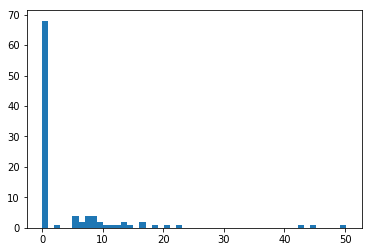

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline
length_list = [x for x in lengths if x < 100]
plt.hist(length_list, 50)

In [ ]:
a = Absorber(coefficient=0.0)
s = Scatterer(coefficient=1.0, phase_function=lambda : henyey_greenstein(g=0.99))
l = Luminophore(
           coefficient=[lambda x: bandgap(x, 555, 2.0)],
           emission=[lambda x: gaussian(x, 1.0, 600, 50)],
           x=np.linspace(300, 800, 500),
           phase_function=isotropic
        )
t1 = isinstance(a, Absorber), isinstance(a, Scatterer), isinstance(a, Luminophore)
t2 = isinstance(s, Absorber), isinstance(s, Scatterer), isinstance(s, Luminophore)
t3 = isinstance(l, Absorber), isinstance(l, Scatterer), isinstance(l, Luminophore)
(t1, t2, t3)

# It seems that refraction out of the cube is not actually bending some rays!?